# Setup 

In [1]:
from pathlib import Path
import os

SRCDIR = "tablediffusion"
DIR = Path("stuff")
DATADIR = Path("/home/azureuser/drive1/data")
RESULTDIR = DIR / "results"

!pwd

for p in [SRCDIR, DIR, DATADIR, RESULTDIR]:
    if not os.path.exists(p):
        print(f"{p} does not exist")

/home/azureuser/drive1/TableDiffusion


In [2]:
!python3 --version

Python 3.12.8


In [2]:
!nvidia-smi

Sat Jan 11 16:59:09 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.05              Driver Version: 560.35.05      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100 80GB PCIe          Off |   00000001:00:00.0 Off |                    0 |
| N/A   32C    P0             52W /  300W |       1MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [3]:
# %%capture
from __future__ import print_function
import argparse
import os
from datetime import datetime
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from IPython.display import HTML
import seaborn as sns
from tqdm import tqdm
import mlflow

In [5]:
# Decide which device we want to run on
DEVICE = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
print(DEVICE)

cuda:0


In [6]:
# Set random seed for reproducibility
SEED = 999
# SEED = random.randint(1, 10000) # use if you want new results
print("Random (meta) seed: ", SEED)

Random (meta) seed:  999


# Synthesis loop

Data synthesis over multiple synthesisers and datasets, with persistence.

In [7]:
%load_ext autoreload
%autoreload 2

In [8]:
import sys
import importlib

sys.path.append(str(SRCDIR))
print(sys.path)

['/home/azureuser/miniconda3/envs/table_diff/lib/python312.zip', '/home/azureuser/miniconda3/envs/table_diff/lib/python3.12', '/home/azureuser/miniconda3/envs/table_diff/lib/python3.12/lib-dynload', '', '/home/azureuser/miniconda3/envs/table_diff/lib/python3.12/site-packages', 'tablediffusion']


In [12]:
from tablediffusion.models import *
import tablediffusion.utilities.utils as utils
import tablediffusion.utilities.data_utils as data_utils
import tablediffusion.config.configs as configs
import tablediffusion.config as config

importlib.reload(utils)
importlib.reload(data_utils)
importlib.reload(config)
importlib.reload(configs)

# NOTES: Running with 10.0 budget very overkill. First few batches immediately burn through ~6.0. The rest of the epoch
# slowly accumulates to ~7.9. Then another half epoch was spend going from 7.9 to 8.2, so I'm guessing the benefits of another
# epoch are small. Total time elapsed 3 hr 20 min and training wasn't done. Gonna try doubling batch size (512 -> 1024) and only 1 epoch.

EPOCHS = 1
DIFFUSION_STEPS = 3

synthesisers = {
    "DPWGAN_Synthesiser": (
        WGAN_Synthesiser,
        {
            "batch_size": 1024,
            'gen_lr': 0.005,
            'dis_lr': 0.001,
            "latent_dim": 128,
            'n_critic': 2,
            "epoch_target": EPOCHS,
            "mlflow_logging": False,
            'gen_dims': (512, 512),
            'dis_dims': (512, 512)
        },
        {
            "n_epochs": EPOCHS,
        },
        {
            "use_raw_data": False,
        },
    ),
    "TableDiffusion_Synthesiser": (
        TableDiffusion_Synthesiser,
        {
            "batch_size": 1024,
            "lr": 0.005,
            "dims": (512, 512),
            "mlflow_logging": False,
            "epoch_target": EPOCHS * DIFFUSION_STEPS,
            "diffusion_steps": DIFFUSION_STEPS,
            "predict_noise": True,
        },
        {
            "n_epochs": EPOCHS,
            "verbose": True,
        },
        {
            "use_raw_data": True,
        },
    )
}
synthesisers

{'DPWGAN_Synthesiser': (models.dp_wgan.WGAN_Synthesiser,
  {'batch_size': 1024,
   'gen_lr': 0.005,
   'dis_lr': 0.001,
   'latent_dim': 128,
   'n_critic': 2,
   'epoch_target': 1,
   'mlflow_logging': False,
   'gen_dims': (512, 512),
   'dis_dims': (512, 512)},
  {'n_epochs': 1},
  {'use_raw_data': False}),
 'TableDiffusion_Synthesiser': (models.table_diffusion.TableDiffusion_Synthesiser,
  {'batch_size': 1024,
   'lr': 0.005,
   'dims': (512, 512),
   'mlflow_logging': False,
   'epoch_target': 3,
   'diffusion_steps': 3,
   'predict_noise': True},
  {'n_epochs': 1, 'verbose': True},
  {'use_raw_data': True})}



Running experiment: exp_250122_010651


CUDA status: True


Repeats:   0%|                                                                                                                                                                     | 0/1 [00:00<?, ?it/s]

Loaded appraise dataset (15116160, 4) from /home/azureuser/drive1/data/appraise_netflow_traffic_features.csv



ilon:   0%|                                                                                                                                                                     | 0/1 [00:00<?, ?it/s]

:   0%|                                                                                                                                                                      | 0/2 [00:00<?, ?it/s]

Training DPWGAN_Synthesiser on appraise with epsilon=2.0...


/home/azureuser/miniconda3/envs/table_diff/lib/python3.12/site-packages/opacus/privacy_engine.py:95: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
/home/azureuser/miniconda3/envs/table_diff/lib/python3.12/site-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
01/22/2025 01:06:58:WARNING:Ignoring drop_last as it is not compatible with DPDataLoader.
/home/azureuser/drive1/TableDiffusion/tablediffusion/models/dp_wgan.py:177: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at /home/conda/feedstock_root

[Epoch 0/1] [Batch 0/14761] [D loss: 0.0006] [G loss: -0.4948]
Epsilon: 0.000
[Epoch 0/1] [Batch 300/14761] [D loss: 0.0001] [G loss: -1.0000]
Epsilon: 1.790
[Epoch 0/1] [Batch 600/14761] [D loss: 0.0000] [G loss: -1.0000]
Epsilon: 1.819
[Epoch 0/1] [Batch 900/14761] [D loss: 0.0000] [G loss: -1.0000]
Epsilon: 1.839
[Epoch 0/1] [Batch 1200/14761] [D loss: 0.0000] [G loss: -1.0000]
Epsilon: 1.851
[Epoch 0/1] [Batch 1500/14761] [D loss: 0.0000] [G loss: -1.0000]
Epsilon: 1.864
[Epoch 0/1] [Batch 1800/14761] [D loss: 0.0000] [G loss: -1.0000]
Epsilon: 1.876
[Epoch 0/1] [Batch 2100/14761] [D loss: 0.0000] [G loss: -1.0000]
Epsilon: 1.883
[Epoch 0/1] [Batch 2400/14761] [D loss: 0.0000] [G loss: -1.0000]
Epsilon: 1.888
[Epoch 0/1] [Batch 2700/14761] [D loss: 0.0000] [G loss: -1.0000]
Epsilon: 1.894
[Epoch 0/1] [Batch 3000/14761] [D loss: 0.0000] [G loss: -1.0000]
Epsilon: 1.900
[Epoch 0/1] [Batch 3300/14761] [D loss: 0.0000] [G loss: -1.0000]
Epsilon: 1.905
[Epoch 0/1] [Batch 3600/14761] [D 




 Generation:   0%|                                                                                                                                                     | 0/3691 [00:00<?, ?it/s]


 Generation:   0%|▎                                                                                                                                            | 7/3691 [00:00<00:58, 63.03it/s]


 Generation:   0%|▌                                                                                                                                           | 14/3691 [00:00<00:59, 61.33it/s]


 Generation:   1%|▊                                                                                                                                           | 21/3691 [00:00<01:00, 60.97it/s]


 Generation:   1%|█                                                                                                                                           | 28/3691 [00:00<01:00, 60.81it/s]


 Generation:   1%|█▎  

Saving fake data...




:  50%|██████████████████████████████████████████████████████████████████████████████                                                                              | 1/2 [27:48<27:48, 1668.38s/it]

Training TableDiffusion_Synthesiser on appraise with epsilon=2.0...
MixedTypeGenerator(
  (seq): Sequential(
    (0): Residual(
      (fc): Linear(in_features=4, out_features=512, bias=True)
      (bn): GroupNorm(1, 512, eps=1e-05, affine=True)
      (relu): ReLU()
    )
    (1): Residual(
      (fc): Linear(in_features=516, out_features=512, bias=True)
      (bn): GroupNorm(1, 512, eps=1e-05, affine=True)
      (relu): ReLU()
    )
    (2): Linear(in_features=1028, out_features=4, bias=True)
  )
)


/home/azureuser/miniconda3/envs/table_diff/lib/python3.12/site-packages/opacus/privacy_engine.py:95: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
/home/azureuser/miniconda3/envs/table_diff/lib/python3.12/site-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(


[Epoch 0/1] [Batch 0/14761] numerical loss: 0.899845, categorical loss: 0.000000, epsilon: 0.000000
[Epoch 0/1] [Batch 20/14761] numerical loss: 0.360962, categorical loss: 0.000000, epsilon: 1.618581
[Epoch 0/1] [Batch 40/14761] numerical loss: 0.251932, categorical loss: 0.000000, epsilon: 1.643963
[Epoch 0/1] [Batch 60/14761] numerical loss: 0.314456, categorical loss: 0.000000, epsilon: 1.656762
[Epoch 0/1] [Batch 80/14761] numerical loss: 0.192343, categorical loss: 0.000000, epsilon: 1.669561
[Epoch 0/1] [Batch 100/14761] numerical loss: 0.177510, categorical loss: 0.000000, epsilon: 1.677984
[Epoch 0/1] [Batch 120/14761] numerical loss: 0.182196, categorical loss: 0.000000, epsilon: 1.683154
[Epoch 0/1] [Batch 140/14761] numerical loss: 0.166769, categorical loss: 0.000000, epsilon: 1.688324
[Epoch 0/1] [Batch 160/14761] numerical loss: 0.168382, categorical loss: 0.000000, epsilon: 1.693494
[Epoch 0/1] [Batch 180/14761] numerical loss: 0.143390, categorical loss: 0.000000, epsi




 Generation:   0%|                                                                                                                                                     | 0/3691 [00:00<?, ?it/s]


 Generation:   0%|                                                                                                                                             | 1/3691 [00:00<07:34,  8.13it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:   0%|                                                                                                                                             | 3/3691 [00:00<05:06, 12.05it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:   0%|▏                                                                                                                                            | 5/3691 [00:00<06:53,  8.90it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:   0%|▎                                                                                                                                            | 7/3691 [00:00<05:47, 10.60it/s]


 Generation:   0%|▎                                                                                                                                            | 9/3691 [00:00<05:13, 11.73it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:   0%|▍                                                                                                                                           | 11/3691 [00:00<04:55, 12.45it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:   0%|▍                                                                                                                                           | 13/3691 [00:01<06:32,  9.38it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:   0%|▌                                                                                                                                           | 15/3691 [00:01<05:49, 10.52it/s]


 Generation:   0%|▋                                                                                                                                           | 17/3691 [00:01<05:20, 11.46it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:   1%|▋                                                                                                                                           | 19/3691 [00:01<05:02, 12.12it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886


/home/azureuser/drive1/TableDiffusion/tablediffusion/models/table_diffusion.py:368: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(self.diffusion_steps, 4, figsize=(4*self.diffusion_steps, 4*4))



 Generation:   1%|▊                                                                                                                                           | 21/3691 [00:02<07:03,  8.66it/s]

Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:   1%|▊                                                                                                                                           | 23/3691 [00:02<06:13,  9.81it/s]


 Generation:   1%|▉                                                                                                                                           | 25/3691 [00:02<05:34, 10.97it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886





 Generation:   1%|█                                                                                                                                           | 27/3691 [00:02<05:02, 12.12it/s]


 Generation:   1%|█                                                                                                                                           | 29/3691 [00:02<04:40, 13.04it/s]

Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:   1%|█▏                                                                                                                                          | 31/3691 [00:03<07:11,  8.49it/s]


 Generation:   1%|█▎                                                                                                                                          | 33/3691 [00:03<06:10,  9.87it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:   1%|█▎                                                                                                                                          | 35/3691 [00:03<05:28, 11.14it/s]


 Generation:   1%|█▍                                                                                                                                          | 37/3691 [00:03<05:01, 12.12it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616





 Generation:   1%|█▍                                                                                                                                          | 39/3691 [00:03<04:42, 12.91it/s]

Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:   1%|█▌                                                                                                                                          | 41/3691 [00:03<04:30, 13.50it/s]


 Generation:   1%|█▋                                                                                                                                          | 43/3691 [00:03<04:18, 14.13it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:   1%|█▋                                                                                                                                          | 45/3691 [00:04<07:33,  8.05it/s]


 Generation:   1%|█▊                                                                                                                                          | 47/3691 [00:04<06:25,  9.46it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:   1%|█▊                                                                                                                                          | 49/3691 [00:04<05:38, 10.77it/s]


 Generation:   1%|█▉                                                                                                                                          | 51/3691 [00:04<05:04, 11.94it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616





 Generation:   1%|██                                                                                                                                          | 53/3691 [00:04<04:45, 12.73it/s]




Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794


 Generation:   1%|██                                                                                                                                          | 55/3691 [00:04<04:31, 13.39it/s]


 Generation:   2%|██▏                                                                                                                                         | 57/3691 [00:05<04:18, 14.06it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:   2%|██▏                                                                                                                                         | 59/3691 [00:05<04:11, 14.46it/s]


 Generation:   2%|██▎                                                                                                                                         | 61/3691 [00:05<04:04, 14.86it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:   2%|██▍                                                                                                                                         | 63/3691 [00:05<08:36,  7.02it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:   2%|██▍                                                                                                                                         | 65/3691 [00:06<07:12,  8.39it/s]


 Generation:   2%|██▌                                                                                                                                         | 67/3691 [00:06<06:10,  9.78it/s]


 Generation:   2%|██▌                                                                                                                                         | 69/3691 [00:06<05:26, 11.08it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:   2%|██▋                                                                                                                                         | 71/3691 [00:06<04:57, 12.16it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:   2%|██▊                                                                                                                                         | 73/3691 [00:06<04:36, 13.07it/s]


 Generation:   2%|██▊                                                                                                                                         | 75/3691 [00:06<04:22, 13.77it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:   2%|██▉                                                                                                                                         | 77/3691 [00:06<04:11, 14.36it/s]


 Generation:   2%|██▉                                                                                                                                         | 79/3691 [00:06<04:05, 14.72it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:   2%|███                                                                                                                                         | 81/3691 [00:07<04:01, 14.96it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:   2%|███▏                                                                                                                                        | 83/3691 [00:07<09:25,  6.38it/s]


 Generation:   2%|███▏                                                                                                                                        | 85/3691 [00:07<07:43,  7.78it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:   2%|███▎                                                                                                                                        | 87/3691 [00:08<06:32,  9.18it/s]


 Generation:   2%|███▍                                                                                                                                        | 89/3691 [00:08<05:42, 10.51it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:   2%|███▍                                                                                                                                        | 91/3691 [00:08<05:07, 11.70it/s]


 Generation:   3%|███▌                                                                                                                                        | 93/3691 [00:08<04:43, 12.71it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:   3%|███▌                                                                                                                                        | 95/3691 [00:08<04:27, 13.47it/s]


 Generation:   3%|███▋                                                                                                                                        | 97/3691 [00:08<04:14, 14.13it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:   3%|███▊                                                                                                                                        | 99/3691 [00:08<04:12, 14.22it/s]


 Generation:   3%|███▊                                                                                                                                       | 101/3691 [00:08<04:04, 14.69it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:   3%|███▉                                                                                                                                       | 103/3691 [00:09<03:58, 15.02it/s]


 Generation:   3%|███▉                                                                                                                                       | 105/3691 [00:09<03:58, 15.02it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:   3%|████                                                                                                                                       | 107/3691 [00:09<04:04, 14.69it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:   3%|████                                                                                                                                       | 109/3691 [00:10<10:48,  5.52it/s]


 Generation:   3%|████▏                                                                                                                                      | 111/3691 [00:10<08:41,  6.86it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:   3%|████▎                                                                                                                                      | 113/3691 [00:10<07:16,  8.19it/s]


 Generation:   3%|████▎                                                                                                                                      | 115/3691 [00:10<06:14,  9.55it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:   3%|████▍                                                                                                                                      | 117/3691 [00:10<05:31, 10.80it/s]


 Generation:   3%|████▍                                                                                                                                      | 119/3691 [00:10<05:00, 11.88it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:   3%|████▌                                                                                                                                      | 121/3691 [00:11<04:40, 12.75it/s]


 Generation:   3%|████▋                                                                                                                                      | 123/3691 [00:11<04:31, 13.15it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:   3%|████▋                                                                                                                                      | 125/3691 [00:11<04:24, 13.50it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886





 Generation:   3%|████▊                                                                                                                                      | 127/3691 [00:11<04:13, 14.07it/s]


 Generation:   3%|████▊                                                                                                                                      | 129/3691 [00:11<04:04, 14.56it/s]

Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:   4%|████▉                                                                                                                                      | 131/3691 [00:11<04:00, 14.81it/s]


 Generation:   4%|█████                                                                                                                                      | 133/3691 [00:11<03:55, 15.13it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:   4%|█████                                                                                                                                      | 135/3691 [00:11<03:52, 15.28it/s]


 Generation:   4%|█████▏                                                                                                                                     | 137/3691 [00:12<03:50, 15.42it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:   4%|█████▏                                                                                                                                     | 139/3691 [00:12<03:49, 15.50it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:   4%|█████▎                                                                                                                                     | 141/3691 [00:13<12:32,  4.72it/s]


 Generation:   4%|█████▍                                                                                                                                     | 143/3691 [00:13<09:54,  5.97it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:   4%|█████▍                                                                                                                                     | 145/3691 [00:13<08:04,  7.32it/s]


 Generation:   4%|█████▌                                                                                                                                     | 147/3691 [00:13<06:50,  8.64it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:   4%|█████▌                                                                                                                                     | 149/3691 [00:13<06:00,  9.81it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616





 Generation:   4%|█████▋                                                                                                                                     | 151/3691 [00:14<05:22, 10.98it/s]


 Generation:   4%|█████▊                                                                                                                                     | 153/3691 [00:14<04:58, 11.86it/s]

Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616





 Generation:   4%|█████▊                                                                                                                                     | 155/3691 [00:14<04:38, 12.68it/s]

Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:   4%|█████▉                                                                                                                                     | 157/3691 [00:14<04:24, 13.37it/s]


 Generation:   4%|█████▉                                                                                                                                     | 159/3691 [00:14<04:13, 13.92it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616





 Generation:   4%|██████                                                                                                                                     | 161/3691 [00:14<04:07, 14.26it/s]


 Generation:   4%|██████▏                                                                                                                                    | 163/3691 [00:14<04:02, 14.54it/s]

Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:   4%|██████▏                                                                                                                                    | 165/3691 [00:14<04:03, 14.48it/s]


 Generation:   5%|██████▎                                                                                                                                    | 167/3691 [00:15<04:03, 14.44it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:   5%|██████▎                                                                                                                                    | 169/3691 [00:15<03:59, 14.68it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616





 Generation:   5%|██████▍                                                                                                                                    | 171/3691 [00:15<03:57, 14.82it/s]


 Generation:   5%|██████▌                                                                                                                                    | 173/3691 [00:15<03:54, 14.98it/s]

Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:   5%|██████▌                                                                                                                                    | 175/3691 [00:15<03:53, 15.03it/s]


 Generation:   5%|██████▋                                                                                                                                    | 177/3691 [00:15<03:52, 15.12it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886





 Generation:   5%|██████▋                                                                                                                                    | 179/3691 [00:15<03:53, 15.04it/s]

Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:   5%|██████▊                                                                                                                                    | 181/3691 [00:15<03:52, 15.11it/s]


 Generation:   5%|██████▉                                                                                                                                    | 183/3691 [00:17<14:12,  4.12it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616





 Generation:   5%|██████▉                                                                                                                                    | 185/3691 [00:17<11:05,  5.27it/s]


 Generation:   5%|███████                                                                                                                                    | 187/3691 [00:17<08:56,  6.54it/s]

Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:   5%|███████                                                                                                                                    | 189/3691 [00:17<07:23,  7.91it/s]


 Generation:   5%|███████▏                                                                                                                                   | 191/3691 [00:17<06:19,  9.23it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886





 Generation:   5%|███████▎                                                                                                                                   | 193/3691 [00:17<05:35, 10.43it/s]

Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616





 Generation:   5%|███████▎                                                                                                                                   | 195/3691 [00:18<05:06, 11.40it/s]


 Generation:   5%|███████▍                                                                                                                                   | 197/3691 [00:18<04:45, 12.23it/s]

Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616





 Generation:   5%|███████▍                                                                                                                                   | 199/3691 [00:18<04:28, 13.01it/s]

Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616





 Generation:   5%|███████▌                                                                                                                                   | 201/3691 [00:18<04:21, 13.33it/s]


 Generation:   5%|███████▋                                                                                                                                   | 203/3691 [00:18<04:11, 13.86it/s]

Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:   6%|███████▋                                                                                                                                   | 205/3691 [00:18<04:05, 14.23it/s]


 Generation:   6%|███████▊                                                                                                                                   | 207/3691 [00:18<04:04, 14.24it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:   6%|███████▊                                                                                                                                   | 209/3691 [00:19<03:58, 14.58it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:   6%|███████▉                                                                                                                                   | 211/3691 [00:19<03:53, 14.89it/s]


 Generation:   6%|████████                                                                                                                                   | 213/3691 [00:19<03:50, 15.12it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:   6%|████████                                                                                                                                   | 215/3691 [00:19<03:48, 15.22it/s]


 Generation:   6%|████████▏                                                                                                                                  | 217/3691 [00:19<03:49, 15.15it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616





 Generation:   6%|████████▏                                                                                                                                  | 219/3691 [00:19<03:47, 15.25it/s]


 Generation:   6%|████████▎                                                                                                                                  | 221/3691 [00:19<03:45, 15.42it/s]

Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:   6%|████████▍                                                                                                                                  | 223/3691 [00:19<03:45, 15.40it/s]


 Generation:   6%|████████▍                                                                                                                                  | 225/3691 [00:20<03:44, 15.47it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:   6%|████████▌                                                                                                                                  | 227/3691 [00:20<03:44, 15.40it/s]


 Generation:   6%|████████▌                                                                                                                                  | 229/3691 [00:20<03:44, 15.45it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:   6%|████████▋                                                                                                                                  | 231/3691 [00:20<03:43, 15.47it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:   6%|████████▊                                                                                                                                  | 233/3691 [00:22<17:07,  3.37it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:   6%|████████▊                                                                                                                                  | 235/3691 [00:22<13:04,  4.41it/s]


 Generation:   6%|████████▉                                                                                                                                  | 237/3691 [00:22<10:14,  5.62it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886





 Generation:   6%|█████████                                                                                                                                  | 239/3691 [00:22<08:21,  6.88it/s]


 Generation:   7%|█████████                                                                                                                                  | 241/3691 [00:22<06:59,  8.23it/s]

Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:   7%|█████████▏                                                                                                                                 | 243/3691 [00:22<05:59,  9.58it/s]


 Generation:   7%|█████████▏                                                                                                                                 | 245/3691 [00:22<05:19, 10.80it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:   7%|█████████▎                                                                                                                                 | 247/3691 [00:23<04:49, 11.91it/s]


 Generation:   7%|█████████▍                                                                                                                                 | 249/3691 [00:23<04:29, 12.79it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:   7%|█████████▍                                                                                                                                 | 251/3691 [00:23<04:14, 13.49it/s]


 Generation:   7%|█████████▌                                                                                                                                 | 253/3691 [00:23<04:04, 14.07it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:   7%|█████████▌                                                                                                                                 | 255/3691 [00:23<03:59, 14.33it/s]


 Generation:   7%|█████████▋                                                                                                                                 | 257/3691 [00:23<04:00, 14.29it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:   7%|█████████▊                                                                                                                                 | 259/3691 [00:23<03:58, 14.38it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616





 Generation:   7%|█████████▊                                                                                                                                 | 261/3691 [00:23<03:52, 14.77it/s]


 Generation:   7%|█████████▉                                                                                                                                 | 263/3691 [00:24<03:49, 14.95it/s]

Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:   7%|█████████▉                                                                                                                                 | 265/3691 [00:24<03:48, 14.98it/s]


 Generation:   7%|██████████                                                                                                                                 | 267/3691 [00:24<03:45, 15.19it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:   7%|██████████▏                                                                                                                                | 269/3691 [00:24<03:43, 15.32it/s]


 Generation:   7%|██████████▏                                                                                                                                | 271/3691 [00:24<03:40, 15.49it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:   7%|██████████▎                                                                                                                                | 273/3691 [00:24<03:42, 15.35it/s]


 Generation:   7%|██████████▎                                                                                                                                | 275/3691 [00:24<03:44, 15.25it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:   8%|██████████▍                                                                                                                                | 277/3691 [00:25<03:45, 15.16it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:   8%|██████████▌                                                                                                                                | 279/3691 [00:25<03:43, 15.24it/s]


 Generation:   8%|██████████▌                                                                                                                                | 281/3691 [00:25<03:43, 15.29it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:   8%|██████████▋                                                                                                                                | 283/3691 [00:25<03:41, 15.36it/s]


 Generation:   8%|██████████▋                                                                                                                                | 285/3691 [00:25<03:40, 15.43it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:   8%|██████████▊                                                                                                                                | 287/3691 [00:25<03:39, 15.50it/s]


 Generation:   8%|██████████▉                                                                                                                                | 289/3691 [00:25<03:40, 15.41it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:   8%|██████████▉                                                                                                                                | 291/3691 [00:25<03:46, 15.03it/s]


 Generation:   8%|███████████                                                                                                                                | 293/3691 [00:26<03:47, 14.94it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:   8%|███████████                                                                                                                                | 295/3691 [00:28<19:12,  2.95it/s]


 Generation:   8%|███████████▏                                                                                                                               | 297/3691 [00:28<14:30,  3.90it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:   8%|███████████▎                                                                                                                               | 299/3691 [00:28<11:13,  5.03it/s]


 Generation:   8%|███████████▎                                                                                                                               | 301/3691 [00:28<08:56,  6.32it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:   8%|███████████▍                                                                                                                               | 303/3691 [00:28<07:21,  7.68it/s]


 Generation:   8%|███████████▍                                                                                                                               | 305/3691 [00:28<06:14,  9.05it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:   8%|███████████▌                                                                                                                               | 307/3691 [00:28<05:26, 10.35it/s]


 Generation:   8%|███████████▋                                                                                                                               | 309/3691 [00:28<04:53, 11.51it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:   8%|███████████▋                                                                                                                               | 311/3691 [00:29<04:31, 12.46it/s]


 Generation:   8%|███████████▊                                                                                                                               | 313/3691 [00:29<04:14, 13.26it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:   9%|███████████▊                                                                                                                               | 315/3691 [00:29<04:02, 13.90it/s]


 Generation:   9%|███████████▉                                                                                                                               | 317/3691 [00:29<03:54, 14.38it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:   9%|████████████                                                                                                                               | 319/3691 [00:29<03:48, 14.75it/s]


 Generation:   9%|████████████                                                                                                                               | 321/3691 [00:29<03:44, 15.04it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:   9%|████████████▏                                                                                                                              | 323/3691 [00:29<03:41, 15.20it/s]


 Generation:   9%|████████████▏                                                                                                                              | 325/3691 [00:29<03:39, 15.33it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:   9%|████████████▎                                                                                                                              | 327/3691 [00:30<03:38, 15.40it/s]


 Generation:   9%|████████████▍                                                                                                                              | 329/3691 [00:30<03:37, 15.46it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:   9%|████████████▍                                                                                                                              | 331/3691 [00:30<03:36, 15.53it/s]


 Generation:   9%|████████████▌                                                                                                                              | 333/3691 [00:30<03:36, 15.51it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:   9%|████████████▌                                                                                                                              | 335/3691 [00:30<03:36, 15.52it/s]


 Generation:   9%|████████████▋                                                                                                                              | 337/3691 [00:30<03:35, 15.59it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:   9%|████████████▊                                                                                                                              | 339/3691 [00:30<03:35, 15.57it/s]


 Generation:   9%|████████████▊                                                                                                                              | 341/3691 [00:30<03:35, 15.57it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:   9%|████████████▉                                                                                                                              | 343/3691 [00:31<03:35, 15.53it/s]


 Generation:   9%|████████████▉                                                                                                                              | 345/3691 [00:31<03:34, 15.59it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616





 Generation:   9%|█████████████                                                                                                                              | 347/3691 [00:31<03:40, 15.13it/s]

Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:   9%|█████████████▏                                                                                                                             | 349/3691 [00:31<03:39, 15.23it/s]


 Generation:  10%|█████████████▏                                                                                                                             | 351/3691 [00:31<03:37, 15.37it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  10%|█████████████▎                                                                                                                             | 353/3691 [00:31<03:36, 15.40it/s]


 Generation:  10%|█████████████▎                                                                                                                             | 355/3691 [00:31<03:37, 15.33it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616





 Generation:  10%|█████████████▍                                                                                                                             | 357/3691 [00:32<03:37, 15.35it/s]


 Generation:  10%|█████████████▌                                                                                                                             | 359/3691 [00:32<03:35, 15.44it/s]

Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  10%|█████████████▌                                                                                                                             | 361/3691 [00:32<03:34, 15.51it/s]


 Generation:  10%|█████████████▋                                                                                                                             | 363/3691 [00:32<03:33, 15.57it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  10%|█████████████▋                                                                                                                             | 365/3691 [00:32<03:36, 15.37it/s]


 Generation:  10%|█████████████▊                                                                                                                             | 367/3691 [00:32<03:34, 15.47it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  10%|█████████████▉                                                                                                                             | 369/3691 [00:32<03:33, 15.54it/s]


 Generation:  10%|█████████████▉                                                                                                                             | 371/3691 [00:32<03:33, 15.55it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  10%|██████████████                                                                                                                             | 373/3691 [00:35<22:24,  2.47it/s]


 Generation:  10%|██████████████                                                                                                                             | 375/3691 [00:35<16:43,  3.30it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  10%|██████████████▏                                                                                                                            | 377/3691 [00:35<12:46,  4.32it/s]


 Generation:  10%|██████████████▎                                                                                                                            | 379/3691 [00:35<10:02,  5.50it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  10%|██████████████▎                                                                                                                            | 381/3691 [00:35<08:08,  6.77it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616





 Generation:  10%|██████████████▍                                                                                                                            | 383/3691 [00:35<06:48,  8.11it/s]


 Generation:  10%|██████████████▍                                                                                                                            | 385/3691 [00:36<05:48,  9.48it/s]

Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  10%|██████████████▌                                                                                                                            | 387/3691 [00:36<05:07, 10.73it/s]


 Generation:  11%|██████████████▋                                                                                                                            | 389/3691 [00:36<04:39, 11.83it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  11%|██████████████▋                                                                                                                            | 391/3691 [00:36<04:19, 12.70it/s]


 Generation:  11%|██████████████▊                                                                                                                            | 393/3691 [00:36<04:05, 13.46it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  11%|██████████████▉                                                                                                                            | 395/3691 [00:36<03:54, 14.05it/s]


 Generation:  11%|██████████████▉                                                                                                                            | 397/3691 [00:36<03:47, 14.50it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  11%|███████████████                                                                                                                            | 399/3691 [00:37<03:43, 14.71it/s]


 Generation:  11%|███████████████                                                                                                                            | 401/3691 [00:37<03:40, 14.95it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886





 Generation:  11%|███████████████▏                                                                                                                           | 403/3691 [00:37<03:38, 15.02it/s]




Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794


 Generation:  11%|███████████████▎                                                                                                                           | 405/3691 [00:37<03:36, 15.20it/s]


 Generation:  11%|███████████████▎                                                                                                                           | 407/3691 [00:37<03:33, 15.35it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  11%|███████████████▍                                                                                                                           | 409/3691 [00:37<03:32, 15.41it/s]


 Generation:  11%|███████████████▍                                                                                                                           | 411/3691 [00:37<03:31, 15.49it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  11%|███████████████▌                                                                                                                           | 413/3691 [00:37<03:32, 15.43it/s]


 Generation:  11%|███████████████▋                                                                                                                           | 415/3691 [00:38<03:32, 15.42it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  11%|███████████████▋                                                                                                                           | 417/3691 [00:38<03:31, 15.46it/s]


 Generation:  11%|███████████████▊                                                                                                                           | 419/3691 [00:38<03:31, 15.50it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  11%|███████████████▊                                                                                                                           | 421/3691 [00:38<03:31, 15.48it/s]


 Generation:  11%|███████████████▉                                                                                                                           | 423/3691 [00:38<03:30, 15.52it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886





 Generation:  12%|████████████████                                                                                                                           | 425/3691 [00:38<03:33, 15.30it/s]


 Generation:  12%|████████████████                                                                                                                           | 427/3691 [00:38<03:31, 15.45it/s]

Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  12%|████████████████▏                                                                                                                          | 429/3691 [00:38<03:30, 15.48it/s]


 Generation:  12%|████████████████▏                                                                                                                          | 431/3691 [00:39<03:29, 15.59it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  12%|████████████████▎                                                                                                                          | 433/3691 [00:39<03:29, 15.59it/s]


 Generation:  12%|████████████████▍                                                                                                                          | 435/3691 [00:39<03:28, 15.63it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  12%|████████████████▍                                                                                                                          | 437/3691 [00:39<03:28, 15.64it/s]


 Generation:  12%|████████████████▌                                                                                                                          | 439/3691 [00:39<03:27, 15.64it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  12%|████████████████▌                                                                                                                          | 441/3691 [00:39<03:30, 15.47it/s]


 Generation:  12%|████████████████▋                                                                                                                          | 443/3691 [00:39<03:28, 15.54it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  12%|████████████████▊                                                                                                                          | 445/3691 [00:39<03:29, 15.50it/s]


 Generation:  12%|████████████████▊                                                                                                                          | 447/3691 [00:40<03:34, 15.13it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  12%|████████████████▉                                                                                                                          | 449/3691 [00:40<03:41, 14.63it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  12%|████████████████▉                                                                                                                          | 451/3691 [00:40<03:44, 14.46it/s]


 Generation:  12%|█████████████████                                                                                                                          | 453/3691 [00:40<03:38, 14.80it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  12%|█████████████████▏                                                                                                                         | 455/3691 [00:40<03:35, 15.04it/s]


 Generation:  12%|█████████████████▏                                                                                                                         | 457/3691 [00:40<03:33, 15.17it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616





 Generation:  12%|█████████████████▎                                                                                                                         | 459/3691 [00:40<03:34, 15.07it/s]

Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  12%|█████████████████▎                                                                                                                         | 461/3691 [00:41<03:33, 15.11it/s]


 Generation:  13%|█████████████████▍                                                                                                                         | 463/3691 [00:41<03:31, 15.26it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  13%|█████████████████▌                                                                                                                         | 465/3691 [00:41<03:29, 15.40it/s]


 Generation:  13%|█████████████████▌                                                                                                                         | 467/3691 [00:41<03:34, 15.05it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  13%|█████████████████▋                                                                                                                         | 469/3691 [00:44<27:36,  1.95it/s]


 Generation:  13%|█████████████████▋                                                                                                                         | 471/3691 [00:44<20:22,  2.63it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616





 Generation:  13%|█████████████████▊                                                                                                                         | 473/3691 [00:44<15:17,  3.51it/s]

Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  13%|█████████████████▉                                                                                                                         | 475/3691 [00:44<11:46,  4.55it/s]


 Generation:  13%|█████████████████▉                                                                                                                         | 477/3691 [00:45<09:17,  5.77it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  13%|██████████████████                                                                                                                         | 479/3691 [00:45<07:31,  7.12it/s]


 Generation:  13%|██████████████████                                                                                                                         | 481/3691 [00:45<06:16,  8.51it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  13%|██████████████████▏                                                                                                                        | 483/3691 [00:45<05:25,  9.86it/s]


 Generation:  13%|██████████████████▎                                                                                                                        | 485/3691 [00:45<04:49, 11.07it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  13%|██████████████████▎                                                                                                                        | 487/3691 [00:45<04:25, 12.09it/s]


 Generation:  13%|██████████████████▍                                                                                                                        | 489/3691 [00:45<04:10, 12.77it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  13%|██████████████████▍                                                                                                                        | 491/3691 [00:45<03:57, 13.47it/s]


 Generation:  13%|██████████████████▌                                                                                                                        | 493/3691 [00:46<03:51, 13.80it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  13%|██████████████████▋                                                                                                                        | 495/3691 [00:46<03:46, 14.09it/s]


 Generation:  13%|██████████████████▋                                                                                                                        | 497/3691 [00:46<03:40, 14.49it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  14%|██████████████████▊                                                                                                                        | 499/3691 [00:46<03:35, 14.81it/s]


 Generation:  14%|██████████████████▊                                                                                                                        | 501/3691 [00:46<03:32, 15.03it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616





 Generation:  14%|██████████████████▉                                                                                                                        | 503/3691 [00:46<03:32, 14.98it/s]

Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  14%|███████████████████                                                                                                                        | 505/3691 [00:46<03:32, 15.02it/s]


 Generation:  14%|███████████████████                                                                                                                        | 507/3691 [00:47<03:29, 15.17it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  14%|███████████████████▏                                                                                                                       | 509/3691 [00:47<03:27, 15.32it/s]


 Generation:  14%|███████████████████▏                                                                                                                       | 511/3691 [00:47<03:30, 15.10it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  14%|███████████████████▎                                                                                                                       | 513/3691 [00:47<03:34, 14.80it/s]


 Generation:  14%|███████████████████▍                                                                                                                       | 515/3691 [00:47<03:33, 14.89it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886





 Generation:  14%|███████████████████▍                                                                                                                       | 517/3691 [00:47<03:30, 15.10it/s]

Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  14%|███████████████████▌                                                                                                                       | 519/3691 [00:47<03:29, 15.13it/s]


 Generation:  14%|███████████████████▌                                                                                                                       | 521/3691 [00:47<03:29, 15.13it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  14%|███████████████████▋                                                                                                                       | 523/3691 [00:48<03:27, 15.24it/s]


 Generation:  14%|███████████████████▊                                                                                                                       | 525/3691 [00:48<03:25, 15.42it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  14%|███████████████████▊                                                                                                                       | 527/3691 [00:48<03:25, 15.43it/s]


 Generation:  14%|███████████████████▉                                                                                                                       | 529/3691 [00:48<03:23, 15.51it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  14%|███████████████████▉                                                                                                                       | 531/3691 [00:48<03:23, 15.52it/s]


 Generation:  14%|████████████████████                                                                                                                       | 533/3691 [00:48<03:22, 15.59it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  14%|████████████████████▏                                                                                                                      | 535/3691 [00:48<03:23, 15.47it/s]


 Generation:  15%|████████████████████▏                                                                                                                      | 537/3691 [00:49<03:26, 15.24it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  15%|████████████████████▎                                                                                                                      | 539/3691 [00:49<03:25, 15.33it/s]


 Generation:  15%|████████████████████▎                                                                                                                      | 541/3691 [00:49<03:23, 15.44it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  15%|████████████████████▍                                                                                                                      | 543/3691 [00:49<03:22, 15.55it/s]


 Generation:  15%|████████████████████▌                                                                                                                      | 545/3691 [00:49<03:22, 15.54it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  15%|████████████████████▌                                                                                                                      | 547/3691 [00:49<03:21, 15.59it/s]


 Generation:  15%|████████████████████▋                                                                                                                      | 549/3691 [00:49<03:22, 15.55it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  15%|████████████████████▊                                                                                                                      | 551/3691 [00:49<03:21, 15.57it/s]


 Generation:  15%|████████████████████▊                                                                                                                      | 553/3691 [00:50<03:21, 15.58it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  15%|████████████████████▉                                                                                                                      | 555/3691 [00:50<03:21, 15.53it/s]


 Generation:  15%|████████████████████▉                                                                                                                      | 557/3691 [00:50<03:21, 15.58it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  15%|█████████████████████                                                                                                                      | 559/3691 [00:50<03:21, 15.58it/s]


 Generation:  15%|█████████████████████▏                                                                                                                     | 561/3691 [00:50<03:20, 15.63it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  15%|█████████████████████▏                                                                                                                     | 563/3691 [00:50<03:20, 15.63it/s]


 Generation:  15%|█████████████████████▎                                                                                                                     | 565/3691 [00:50<03:19, 15.64it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616





 Generation:  15%|█████████████████████▎                                                                                                                     | 567/3691 [00:50<03:21, 15.49it/s]


 Generation:  15%|█████████████████████▍                                                                                                                     | 569/3691 [00:51<03:22, 15.38it/s]

Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  15%|█████████████████████▌                                                                                                                     | 571/3691 [00:51<03:21, 15.45it/s]


 Generation:  16%|█████████████████████▌                                                                                                                     | 573/3691 [00:51<03:21, 15.46it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  16%|█████████████████████▋                                                                                                                     | 575/3691 [00:51<03:22, 15.40it/s]


 Generation:  16%|█████████████████████▋                                                                                                                     | 577/3691 [00:51<03:27, 14.98it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  16%|█████████████████████▊                                                                                                                     | 579/3691 [00:51<03:26, 15.08it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  16%|█████████████████████▉                                                                                                                     | 581/3691 [00:51<03:24, 15.18it/s]


 Generation:  16%|█████████████████████▉                                                                                                                     | 583/3691 [00:51<03:24, 15.22it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616





 Generation:  16%|██████████████████████                                                                                                                     | 585/3691 [00:52<03:24, 15.22it/s]


 Generation:  16%|██████████████████████                                                                                                                     | 587/3691 [00:52<03:21, 15.38it/s]

Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  16%|██████████████████████▏                                                                                                                    | 589/3691 [00:56<31:35,  1.64it/s]


 Generation:  16%|██████████████████████▎                                                                                                                    | 591/3691 [00:56<23:06,  2.24it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  16%|██████████████████████▎                                                                                                                    | 593/3691 [00:56<17:08,  3.01it/s]


 Generation:  16%|██████████████████████▍                                                                                                                    | 595/3691 [00:56<12:59,  3.97it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  16%|██████████████████████▍                                                                                                                    | 597/3691 [00:56<10:06,  5.10it/s]


 Generation:  16%|██████████████████████▌                                                                                                                    | 599/3691 [00:56<08:02,  6.41it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  16%|██████████████████████▋                                                                                                                    | 601/3691 [00:56<06:38,  7.76it/s]


 Generation:  16%|██████████████████████▋                                                                                                                    | 603/3691 [00:56<05:41,  9.03it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616





 Generation:  16%|██████████████████████▊                                                                                                                    | 605/3691 [00:57<04:59, 10.30it/s]


 Generation:  16%|██████████████████████▊                                                                                                                    | 607/3691 [00:57<04:28, 11.48it/s]

Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  16%|██████████████████████▉                                                                                                                    | 609/3691 [00:57<04:07, 12.46it/s]


 Generation:  17%|███████████████████████                                                                                                                    | 611/3691 [00:57<03:52, 13.26it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  17%|███████████████████████                                                                                                                    | 613/3691 [00:57<03:42, 13.81it/s]


 Generation:  17%|███████████████████████▏                                                                                                                   | 615/3691 [00:57<03:39, 14.00it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  17%|███████████████████████▏                                                                                                                   | 617/3691 [00:57<03:36, 14.21it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  17%|███████████████████████▎                                                                                                                   | 619/3691 [00:57<03:35, 14.26it/s]


 Generation:  17%|███████████████████████▍                                                                                                                   | 621/3691 [00:58<03:30, 14.56it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616





 Generation:  17%|███████████████████████▍                                                                                                                   | 623/3691 [00:58<03:26, 14.86it/s]


 Generation:  17%|███████████████████████▌                                                                                                                   | 625/3691 [00:58<03:23, 15.06it/s]

Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  17%|███████████████████████▌                                                                                                                   | 627/3691 [00:58<03:23, 15.09it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  17%|███████████████████████▋                                                                                                                   | 629/3691 [00:58<03:21, 15.22it/s]


 Generation:  17%|███████████████████████▊                                                                                                                   | 631/3691 [00:58<03:19, 15.31it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616





 Generation:  17%|███████████████████████▊                                                                                                                   | 633/3691 [00:58<03:21, 15.17it/s]


 Generation:  17%|███████████████████████▉                                                                                                                   | 635/3691 [00:59<03:19, 15.31it/s]

Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  17%|███████████████████████▉                                                                                                                   | 637/3691 [00:59<03:19, 15.32it/s]


 Generation:  17%|████████████████████████                                                                                                                   | 639/3691 [00:59<03:19, 15.31it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616





 Generation:  17%|████████████████████████▏                                                                                                                  | 641/3691 [00:59<03:17, 15.42it/s]


 Generation:  17%|████████████████████████▏                                                                                                                  | 643/3691 [00:59<03:16, 15.53it/s]

Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  17%|████████████████████████▎                                                                                                                  | 645/3691 [00:59<03:15, 15.57it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  18%|████████████████████████▎                                                                                                                  | 647/3691 [00:59<03:16, 15.49it/s]


 Generation:  18%|████████████████████████▍                                                                                                                  | 649/3691 [00:59<03:18, 15.32it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  18%|████████████████████████▌                                                                                                                  | 651/3691 [01:00<03:16, 15.44it/s]


 Generation:  18%|████████████████████████▌                                                                                                                  | 653/3691 [01:00<03:15, 15.54it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  18%|████████████████████████▋                                                                                                                  | 655/3691 [01:00<03:14, 15.63it/s]


 Generation:  18%|████████████████████████▋                                                                                                                  | 657/3691 [01:00<03:13, 15.65it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  18%|████████████████████████▊                                                                                                                  | 659/3691 [01:00<03:14, 15.60it/s]


 Generation:  18%|████████████████████████▉                                                                                                                  | 661/3691 [01:00<03:13, 15.62it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  18%|████████████████████████▉                                                                                                                  | 663/3691 [01:00<03:13, 15.63it/s]


 Generation:  18%|█████████████████████████                                                                                                                  | 665/3691 [01:00<03:14, 15.57it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  18%|█████████████████████████                                                                                                                  | 667/3691 [01:01<03:14, 15.56it/s]


 Generation:  18%|█████████████████████████▏                                                                                                                 | 669/3691 [01:01<03:14, 15.56it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  18%|█████████████████████████▎                                                                                                                 | 671/3691 [01:01<03:13, 15.58it/s]


 Generation:  18%|█████████████████████████▎                                                                                                                 | 673/3691 [01:01<03:14, 15.51it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886





 Generation:  18%|█████████████████████████▍                                                                                                                 | 675/3691 [01:01<03:17, 15.27it/s]


 Generation:  18%|█████████████████████████▍                                                                                                                 | 677/3691 [01:01<03:16, 15.37it/s]

Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  18%|█████████████████████████▌                                                                                                                 | 679/3691 [01:01<03:16, 15.32it/s]


 Generation:  18%|█████████████████████████▋                                                                                                                 | 681/3691 [01:01<03:15, 15.37it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616





 Generation:  19%|█████████████████████████▋                                                                                                                 | 683/3691 [01:02<03:17, 15.21it/s]




Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794


 Generation:  19%|█████████████████████████▊                                                                                                                 | 685/3691 [01:02<03:16, 15.33it/s]


 Generation:  19%|█████████████████████████▊                                                                                                                 | 687/3691 [01:02<03:14, 15.43it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  19%|█████████████████████████▉                                                                                                                 | 689/3691 [01:02<03:13, 15.50it/s]


 Generation:  19%|██████████████████████████                                                                                                                 | 691/3691 [01:02<03:12, 15.59it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  19%|██████████████████████████                                                                                                                 | 693/3691 [01:02<03:12, 15.61it/s]


 Generation:  19%|██████████████████████████▏                                                                                                                | 695/3691 [01:02<03:12, 15.53it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616





 Generation:  19%|██████████████████████████▏                                                                                                                | 697/3691 [01:03<03:13, 15.49it/s]


 Generation:  19%|██████████████████████████▎                                                                                                                | 699/3691 [01:03<03:12, 15.56it/s]

Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  19%|██████████████████████████▍                                                                                                                | 701/3691 [01:03<03:13, 15.43it/s]


 Generation:  19%|██████████████████████████▍                                                                                                                | 703/3691 [01:03<03:12, 15.53it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  19%|██████████████████████████▌                                                                                                                | 705/3691 [01:03<03:11, 15.57it/s]


 Generation:  19%|██████████████████████████▋                                                                                                                | 707/3691 [01:03<03:10, 15.62it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  19%|██████████████████████████▋                                                                                                                | 709/3691 [01:03<03:10, 15.62it/s]


 Generation:  19%|██████████████████████████▊                                                                                                                | 711/3691 [01:03<03:11, 15.54it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  19%|██████████████████████████▊                                                                                                                | 713/3691 [01:04<03:11, 15.57it/s]


 Generation:  19%|██████████████████████████▉                                                                                                                | 715/3691 [01:04<03:10, 15.61it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  19%|███████████████████████████                                                                                                                | 717/3691 [01:04<03:10, 15.59it/s]


 Generation:  19%|███████████████████████████                                                                                                                | 719/3691 [01:04<03:10, 15.64it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  20%|███████████████████████████▏                                                                                                               | 721/3691 [01:04<03:09, 15.65it/s]


 Generation:  20%|███████████████████████████▏                                                                                                               | 723/3691 [01:04<03:10, 15.60it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  20%|███████████████████████████▎                                                                                                               | 725/3691 [01:04<03:09, 15.61it/s]


 Generation:  20%|███████████████████████████▍                                                                                                               | 727/3691 [01:04<03:10, 15.52it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  20%|███████████████████████████▍                                                                                                               | 729/3691 [01:05<03:09, 15.60it/s]


 Generation:  20%|███████████████████████████▌                                                                                                               | 731/3691 [01:05<03:09, 15.60it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  20%|███████████████████████████▌                                                                                                               | 733/3691 [01:05<03:09, 15.61it/s]


 Generation:  20%|███████████████████████████▋                                                                                                               | 735/3691 [01:05<03:09, 15.62it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  20%|███████████████████████████▊                                                                                                               | 737/3691 [01:05<03:08, 15.64it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  20%|███████████████████████████▊                                                                                                               | 739/3691 [01:10<36:13,  1.36it/s]


 Generation:  20%|███████████████████████████▉                                                                                                               | 741/3691 [01:10<26:17,  1.87it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  20%|███████████████████████████▉                                                                                                               | 743/3691 [01:10<19:19,  2.54it/s]


 Generation:  20%|████████████████████████████                                                                                                               | 745/3691 [01:10<14:27,  3.40it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  20%|████████████████████████████▏                                                                                                              | 747/3691 [01:10<11:03,  4.44it/s]


 Generation:  20%|████████████████████████████▏                                                                                                              | 749/3691 [01:10<08:42,  5.63it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886





 Generation:  20%|████████████████████████████▎                                                                                                              | 751/3691 [01:10<07:07,  6.88it/s]

Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  20%|████████████████████████████▎                                                                                                              | 753/3691 [01:11<05:55,  8.27it/s]


 Generation:  20%|████████████████████████████▍                                                                                                              | 755/3691 [01:11<05:05,  9.62it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  21%|████████████████████████████▌                                                                                                              | 757/3691 [01:11<04:29, 10.88it/s]


 Generation:  21%|████████████████████████████▌                                                                                                              | 759/3691 [01:11<04:05, 11.92it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  21%|████████████████████████████▋                                                                                                              | 761/3691 [01:11<03:48, 12.83it/s]


 Generation:  21%|████████████████████████████▋                                                                                                              | 763/3691 [01:11<03:41, 13.19it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886





 Generation:  21%|████████████████████████████▊                                                                                                              | 765/3691 [01:11<03:32, 13.76it/s]


 Generation:  21%|████████████████████████████▉                                                                                                              | 767/3691 [01:12<03:25, 14.25it/s]

Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  21%|████████████████████████████▉                                                                                                              | 769/3691 [01:12<03:21, 14.54it/s]


 Generation:  21%|█████████████████████████████                                                                                                              | 771/3691 [01:12<03:16, 14.84it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  21%|█████████████████████████████                                                                                                              | 773/3691 [01:12<03:13, 15.07it/s]


 Generation:  21%|█████████████████████████████▏                                                                                                             | 775/3691 [01:12<03:11, 15.24it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  21%|█████████████████████████████▎                                                                                                             | 777/3691 [01:12<03:09, 15.38it/s]


 Generation:  21%|█████████████████████████████▎                                                                                                             | 779/3691 [01:12<03:08, 15.45it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  21%|█████████████████████████████▍                                                                                                             | 781/3691 [01:12<03:08, 15.43it/s]


 Generation:  21%|█████████████████████████████▍                                                                                                             | 783/3691 [01:13<03:07, 15.52it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  21%|█████████████████████████████▌                                                                                                             | 785/3691 [01:13<03:06, 15.57it/s]


 Generation:  21%|█████████████████████████████▋                                                                                                             | 787/3691 [01:13<03:06, 15.58it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  21%|█████████████████████████████▋                                                                                                             | 789/3691 [01:13<03:05, 15.61it/s]


 Generation:  21%|█████████████████████████████▊                                                                                                             | 791/3691 [01:13<03:05, 15.63it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  21%|█████████████████████████████▊                                                                                                             | 793/3691 [01:13<03:04, 15.68it/s]


 Generation:  22%|█████████████████████████████▉                                                                                                             | 795/3691 [01:13<03:05, 15.61it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  22%|██████████████████████████████                                                                                                             | 797/3691 [01:13<03:05, 15.60it/s]


 Generation:  22%|██████████████████████████████                                                                                                             | 799/3691 [01:14<03:05, 15.62it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  22%|██████████████████████████████▏                                                                                                            | 801/3691 [01:14<03:07, 15.45it/s]


 Generation:  22%|██████████████████████████████▏                                                                                                            | 803/3691 [01:14<03:06, 15.48it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  22%|██████████████████████████████▎                                                                                                            | 805/3691 [01:14<03:05, 15.54it/s]


 Generation:  22%|██████████████████████████████▍                                                                                                            | 807/3691 [01:14<03:05, 15.58it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  22%|██████████████████████████████▍                                                                                                            | 809/3691 [01:14<03:05, 15.58it/s]


 Generation:  22%|██████████████████████████████▌                                                                                                            | 811/3691 [01:14<03:05, 15.50it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  22%|██████████████████████████████▌                                                                                                            | 813/3691 [01:15<03:11, 15.04it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616





 Generation:  22%|██████████████████████████████▋                                                                                                            | 815/3691 [01:15<03:08, 15.22it/s]


 Generation:  22%|██████████████████████████████▊                                                                                                            | 817/3691 [01:15<03:08, 15.24it/s]

Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  22%|██████████████████████████████▊                                                                                                            | 819/3691 [01:15<03:07, 15.32it/s]


 Generation:  22%|██████████████████████████████▉                                                                                                            | 821/3691 [01:15<03:05, 15.45it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  22%|██████████████████████████████▉                                                                                                            | 823/3691 [01:15<03:05, 15.49it/s]


 Generation:  22%|███████████████████████████████                                                                                                            | 825/3691 [01:15<03:04, 15.56it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  22%|███████████████████████████████▏                                                                                                           | 827/3691 [01:15<03:03, 15.60it/s]


 Generation:  22%|███████████████████████████████▏                                                                                                           | 829/3691 [01:16<03:03, 15.62it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  23%|███████████████████████████████▎                                                                                                           | 831/3691 [01:16<03:02, 15.66it/s]


 Generation:  23%|███████████████████████████████▎                                                                                                           | 833/3691 [01:16<03:02, 15.66it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  23%|███████████████████████████████▍                                                                                                           | 835/3691 [01:16<03:03, 15.54it/s]


 Generation:  23%|███████████████████████████████▌                                                                                                           | 837/3691 [01:16<03:04, 15.51it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  23%|███████████████████████████████▌                                                                                                           | 839/3691 [01:16<03:02, 15.60it/s]


 Generation:  23%|███████████████████████████████▋                                                                                                           | 841/3691 [01:16<03:02, 15.61it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  23%|███████████████████████████████▋                                                                                                           | 843/3691 [01:16<03:02, 15.58it/s]


 Generation:  23%|███████████████████████████████▊                                                                                                           | 845/3691 [01:17<03:02, 15.60it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  23%|███████████████████████████████▉                                                                                                           | 847/3691 [01:17<03:02, 15.58it/s]


 Generation:  23%|███████████████████████████████▉                                                                                                           | 849/3691 [01:17<03:02, 15.59it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  23%|████████████████████████████████                                                                                                           | 851/3691 [01:17<03:03, 15.48it/s]


 Generation:  23%|████████████████████████████████                                                                                                           | 853/3691 [01:17<03:02, 15.53it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  23%|████████████████████████████████▏                                                                                                          | 855/3691 [01:17<03:02, 15.55it/s]


 Generation:  23%|████████████████████████████████▎                                                                                                          | 857/3691 [01:17<03:01, 15.60it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  23%|████████████████████████████████▎                                                                                                          | 859/3691 [01:17<03:01, 15.60it/s]


 Generation:  23%|████████████████████████████████▍                                                                                                          | 861/3691 [01:18<03:01, 15.55it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  23%|████████████████████████████████▍                                                                                                          | 863/3691 [01:18<03:01, 15.55it/s]


 Generation:  23%|████████████████████████████████▌                                                                                                          | 865/3691 [01:18<03:01, 15.57it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  23%|████████████████████████████████▋                                                                                                          | 867/3691 [01:18<03:01, 15.58it/s]


 Generation:  24%|████████████████████████████████▋                                                                                                          | 869/3691 [01:18<03:02, 15.46it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616





 Generation:  24%|████████████████████████████████▊                                                                                                          | 871/3691 [01:18<03:01, 15.51it/s]


 Generation:  24%|████████████████████████████████▉                                                                                                          | 873/3691 [01:18<03:01, 15.52it/s]

Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  24%|████████████████████████████████▉                                                                                                          | 875/3691 [01:18<03:01, 15.54it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  24%|█████████████████████████████████                                                                                                          | 877/3691 [01:19<03:01, 15.48it/s]


 Generation:  24%|█████████████████████████████████                                                                                                          | 879/3691 [01:19<03:01, 15.51it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  24%|█████████████████████████████████▏                                                                                                         | 881/3691 [01:19<03:00, 15.55it/s]


 Generation:  24%|█████████████████████████████████▎                                                                                                         | 883/3691 [01:19<02:59, 15.61it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616





 Generation:  24%|█████████████████████████████████▎                                                                                                         | 885/3691 [01:19<03:01, 15.46it/s]


 Generation:  24%|█████████████████████████████████▍                                                                                                         | 887/3691 [01:19<03:02, 15.34it/s]

Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  24%|█████████████████████████████████▍                                                                                                         | 889/3691 [01:19<03:01, 15.44it/s]


 Generation:  24%|█████████████████████████████████▌                                                                                                         | 891/3691 [01:20<03:00, 15.50it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  24%|█████████████████████████████████▋                                                                                                         | 893/3691 [01:20<02:59, 15.55it/s]


 Generation:  24%|█████████████████████████████████▋                                                                                                         | 895/3691 [01:20<03:01, 15.42it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616





 Generation:  24%|█████████████████████████████████▊                                                                                                         | 897/3691 [01:20<03:00, 15.50it/s]


 Generation:  24%|█████████████████████████████████▊                                                                                                         | 899/3691 [01:20<02:59, 15.59it/s]

Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  24%|█████████████████████████████████▉                                                                                                         | 901/3691 [01:20<02:58, 15.63it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  24%|██████████████████████████████████                                                                                                         | 903/3691 [01:20<02:58, 15.65it/s]


 Generation:  25%|██████████████████████████████████                                                                                                         | 905/3691 [01:20<02:58, 15.61it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  25%|██████████████████████████████████▏                                                                                                        | 907/3691 [01:21<02:58, 15.62it/s]


 Generation:  25%|██████████████████████████████████▏                                                                                                        | 909/3691 [01:21<02:57, 15.63it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  25%|██████████████████████████████████▎                                                                                                        | 911/3691 [01:21<02:58, 15.54it/s]


 Generation:  25%|██████████████████████████████████▍                                                                                                        | 913/3691 [01:21<02:58, 15.58it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  25%|██████████████████████████████████▍                                                                                                        | 915/3691 [01:21<02:57, 15.63it/s]


 Generation:  25%|██████████████████████████████████▌                                                                                                        | 917/3691 [01:21<02:57, 15.63it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616





 Generation:  25%|██████████████████████████████████▌                                                                                                        | 919/3691 [01:21<03:00, 15.32it/s]


 Generation:  25%|██████████████████████████████████▋                                                                                                        | 921/3691 [01:21<03:02, 15.17it/s]

Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  25%|██████████████████████████████████▊                                                                                                        | 923/3691 [01:22<03:00, 15.32it/s]


 Generation:  25%|██████████████████████████████████▊                                                                                                        | 925/3691 [01:22<02:59, 15.42it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  25%|██████████████████████████████████▉                                                                                                        | 927/3691 [01:27<41:42,  1.10it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  25%|██████████████████████████████████▉                                                                                                        | 929/3691 [01:28<30:03,  1.53it/s]


 Generation:  25%|███████████████████████████████████                                                                                                        | 931/3691 [01:28<21:54,  2.10it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  25%|███████████████████████████████████▏                                                                                                       | 933/3691 [01:28<16:12,  2.84it/s]


 Generation:  25%|███████████████████████████████████▏                                                                                                       | 935/3691 [01:28<12:17,  3.74it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616





 Generation:  25%|███████████████████████████████████▎                                                                                                       | 937/3691 [01:28<09:28,  4.84it/s]


 Generation:  25%|███████████████████████████████████▎                                                                                                       | 939/3691 [01:28<07:30,  6.11it/s]

Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  25%|███████████████████████████████████▍                                                                                                       | 941/3691 [01:28<06:09,  7.43it/s]


 Generation:  26%|███████████████████████████████████▌                                                                                                       | 943/3691 [01:28<05:12,  8.81it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616





 Generation:  26%|███████████████████████████████████▌                                                                                                       | 945/3691 [01:29<04:31, 10.10it/s]


 Generation:  26%|███████████████████████████████████▋                                                                                                       | 947/3691 [01:29<04:02, 11.30it/s]

Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  26%|███████████████████████████████████▋                                                                                                       | 949/3691 [01:29<03:43, 12.30it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  26%|███████████████████████████████████▊                                                                                                       | 951/3691 [01:29<03:28, 13.16it/s]


 Generation:  26%|███████████████████████████████████▉                                                                                                       | 953/3691 [01:29<03:17, 13.84it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  26%|███████████████████████████████████▉                                                                                                       | 955/3691 [01:29<03:10, 14.36it/s]


 Generation:  26%|████████████████████████████████████                                                                                                       | 957/3691 [01:29<03:05, 14.70it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  26%|████████████████████████████████████                                                                                                       | 959/3691 [01:30<03:02, 15.00it/s]


 Generation:  26%|████████████████████████████████████▏                                                                                                      | 961/3691 [01:30<02:59, 15.17it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  26%|████████████████████████████████████▎                                                                                                      | 963/3691 [01:30<02:57, 15.33it/s]


 Generation:  26%|████████████████████████████████████▎                                                                                                      | 965/3691 [01:30<02:56, 15.41it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  26%|████████████████████████████████████▍                                                                                                      | 967/3691 [01:30<02:55, 15.53it/s]


 Generation:  26%|████████████████████████████████████▍                                                                                                      | 969/3691 [01:30<02:54, 15.59it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  26%|████████████████████████████████████▌                                                                                                      | 971/3691 [01:30<02:53, 15.65it/s]


 Generation:  26%|████████████████████████████████████▋                                                                                                      | 973/3691 [01:30<02:54, 15.55it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  26%|████████████████████████████████████▋                                                                                                      | 975/3691 [01:31<02:54, 15.55it/s]


 Generation:  26%|████████████████████████████████████▊                                                                                                      | 977/3691 [01:31<02:56, 15.41it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616





 Generation:  27%|████████████████████████████████████▊                                                                                                      | 979/3691 [01:31<02:55, 15.46it/s]


 Generation:  27%|████████████████████████████████████▉                                                                                                      | 981/3691 [01:31<02:54, 15.55it/s]

Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  27%|█████████████████████████████████████                                                                                                      | 983/3691 [01:31<02:54, 15.54it/s]


 Generation:  27%|█████████████████████████████████████                                                                                                      | 985/3691 [01:31<02:54, 15.54it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  27%|█████████████████████████████████████▏                                                                                                     | 987/3691 [01:31<02:54, 15.52it/s]


 Generation:  27%|█████████████████████████████████████▏                                                                                                     | 989/3691 [01:31<02:58, 15.12it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  27%|█████████████████████████████████████▎                                                                                                     | 991/3691 [01:32<02:57, 15.22it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  27%|█████████████████████████████████████▍                                                                                                     | 993/3691 [01:32<02:56, 15.29it/s]


 Generation:  27%|█████████████████████████████████████▍                                                                                                     | 995/3691 [01:32<02:55, 15.39it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  27%|█████████████████████████████████████▌                                                                                                     | 997/3691 [01:32<02:54, 15.42it/s]


 Generation:  27%|█████████████████████████████████████▌                                                                                                     | 999/3691 [01:32<02:53, 15.48it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  27%|█████████████████████████████████████▍                                                                                                    | 1001/3691 [01:32<02:52, 15.56it/s]


 Generation:  27%|█████████████████████████████████████▌                                                                                                    | 1003/3691 [01:32<02:56, 15.23it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616





 Generation:  27%|█████████████████████████████████████▌                                                                                                    | 1005/3691 [01:32<02:55, 15.35it/s]


 Generation:  27%|█████████████████████████████████████▋                                                                                                    | 1007/3691 [01:33<02:53, 15.45it/s]

Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  27%|█████████████████████████████████████▋                                                                                                    | 1009/3691 [01:33<02:54, 15.41it/s]


 Generation:  27%|█████████████████████████████████████▊                                                                                                    | 1011/3691 [01:33<02:52, 15.52it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  27%|█████████████████████████████████████▊                                                                                                    | 1013/3691 [01:33<02:52, 15.56it/s]


 Generation:  27%|█████████████████████████████████████▉                                                                                                    | 1015/3691 [01:33<02:51, 15.61it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  28%|██████████████████████████████████████                                                                                                    | 1017/3691 [01:33<02:51, 15.60it/s]


 Generation:  28%|██████████████████████████████████████                                                                                                    | 1019/3691 [01:33<02:52, 15.48it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616





 Generation:  28%|██████████████████████████████████████▏                                                                                                   | 1021/3691 [01:34<02:52, 15.49it/s]


 Generation:  28%|██████████████████████████████████████▏                                                                                                   | 1023/3691 [01:34<02:51, 15.56it/s]

Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  28%|██████████████████████████████████████▎                                                                                                   | 1025/3691 [01:34<02:51, 15.53it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  28%|██████████████████████████████████████▍                                                                                                   | 1027/3691 [01:34<02:50, 15.58it/s]


 Generation:  28%|██████████████████████████████████████▍                                                                                                   | 1029/3691 [01:34<02:50, 15.59it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  28%|██████████████████████████████████████▌                                                                                                   | 1031/3691 [01:34<02:50, 15.60it/s]


 Generation:  28%|██████████████████████████████████████▌                                                                                                   | 1033/3691 [01:34<02:51, 15.54it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  28%|██████████████████████████████████████▋                                                                                                   | 1035/3691 [01:34<02:51, 15.50it/s]


 Generation:  28%|██████████████████████████████████████▊                                                                                                   | 1037/3691 [01:35<02:51, 15.51it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  28%|██████████████████████████████████████▊                                                                                                   | 1039/3691 [01:35<02:50, 15.52it/s]


 Generation:  28%|██████████████████████████████████████▉                                                                                                   | 1041/3691 [01:35<02:51, 15.47it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  28%|██████████████████████████████████████▉                                                                                                   | 1043/3691 [01:35<02:50, 15.57it/s]


 Generation:  28%|███████████████████████████████████████                                                                                                   | 1045/3691 [01:35<02:49, 15.57it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  28%|███████████████████████████████████████▏                                                                                                  | 1047/3691 [01:35<02:49, 15.60it/s]


 Generation:  28%|███████████████████████████████████████▏                                                                                                  | 1049/3691 [01:35<02:48, 15.64it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616





 Generation:  28%|███████████████████████████████████████▎                                                                                                  | 1051/3691 [01:35<02:50, 15.47it/s]


 Generation:  29%|███████████████████████████████████████▎                                                                                                  | 1053/3691 [01:36<02:49, 15.54it/s]

Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  29%|███████████████████████████████████████▍                                                                                                  | 1055/3691 [01:36<02:49, 15.54it/s]


 Generation:  29%|███████████████████████████████████████▌                                                                                                  | 1057/3691 [01:36<02:48, 15.59it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  29%|███████████████████████████████████████▌                                                                                                  | 1059/3691 [01:36<02:48, 15.59it/s]


 Generation:  29%|███████████████████████████████████████▋                                                                                                  | 1061/3691 [01:36<02:48, 15.60it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  29%|███████████████████████████████████████▋                                                                                                  | 1063/3691 [01:36<02:48, 15.59it/s]


 Generation:  29%|███████████████████████████████████████▊                                                                                                  | 1065/3691 [01:36<02:48, 15.56it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  29%|███████████████████████████████████████▉                                                                                                  | 1067/3691 [01:36<02:49, 15.49it/s]


 Generation:  29%|███████████████████████████████████████▉                                                                                                  | 1069/3691 [01:37<02:48, 15.54it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886





 Generation:  29%|████████████████████████████████████████                                                                                                  | 1071/3691 [01:37<02:51, 15.24it/s]

Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  29%|████████████████████████████████████████                                                                                                  | 1073/3691 [01:37<02:50, 15.33it/s]


 Generation:  29%|████████████████████████████████████████▏                                                                                                 | 1075/3691 [01:37<02:49, 15.40it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  29%|████████████████████████████████████████▎                                                                                                 | 1077/3691 [01:37<02:49, 15.45it/s]


 Generation:  29%|████████████████████████████████████████▎                                                                                                 | 1079/3691 [01:37<02:49, 15.45it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  29%|████████████████████████████████████████▍                                                                                                 | 1081/3691 [01:37<02:49, 15.44it/s]


 Generation:  29%|████████████████████████████████████████▍                                                                                                 | 1083/3691 [01:38<02:48, 15.51it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  29%|████████████████████████████████████████▌                                                                                                 | 1085/3691 [01:38<02:47, 15.56it/s]


 Generation:  29%|████████████████████████████████████████▋                                                                                                 | 1087/3691 [01:38<02:47, 15.54it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  30%|████████████████████████████████████████▋                                                                                                 | 1089/3691 [01:38<02:47, 15.52it/s]


 Generation:  30%|████████████████████████████████████████▊                                                                                                 | 1091/3691 [01:38<02:46, 15.62it/s]




Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794


 Generation:  30%|████████████████████████████████████████▊                                                                                                 | 1093/3691 [01:38<02:45, 15.72it/s]


 Generation:  30%|████████████████████████████████████████▉                                                                                                 | 1095/3691 [01:38<02:44, 15.76it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  30%|█████████████████████████████████████████                                                                                                 | 1097/3691 [01:38<02:46, 15.56it/s]


 Generation:  30%|█████████████████████████████████████████                                                                                                 | 1099/3691 [01:39<02:45, 15.62it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  30%|█████████████████████████████████████████▏                                                                                                | 1101/3691 [01:39<02:45, 15.62it/s]


 Generation:  30%|█████████████████████████████████████████▏                                                                                                | 1103/3691 [01:39<02:45, 15.64it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  30%|█████████████████████████████████████████▎                                                                                                | 1105/3691 [01:39<02:45, 15.66it/s]


 Generation:  30%|█████████████████████████████████████████▍                                                                                                | 1107/3691 [01:39<02:44, 15.67it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  30%|█████████████████████████████████████████▍                                                                                                | 1109/3691 [01:39<02:44, 15.69it/s]


 Generation:  30%|█████████████████████████████████████████▌                                                                                                | 1111/3691 [01:39<02:44, 15.70it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  30%|█████████████████████████████████████████▌                                                                                                | 1113/3691 [01:39<02:44, 15.63it/s]


 Generation:  30%|█████████████████████████████████████████▋                                                                                                | 1115/3691 [01:40<02:44, 15.66it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  30%|█████████████████████████████████████████▊                                                                                                | 1117/3691 [01:40<02:44, 15.62it/s]


 Generation:  30%|█████████████████████████████████████████▊                                                                                                | 1119/3691 [01:40<02:45, 15.53it/s]




Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794


 Generation:  30%|█████████████████████████████████████████▉                                                                                                | 1121/3691 [01:40<02:44, 15.60it/s]


 Generation:  30%|█████████████████████████████████████████▉                                                                                                | 1123/3691 [01:40<02:43, 15.67it/s]




Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794


 Generation:  30%|██████████████████████████████████████████                                                                                                | 1125/3691 [01:40<02:42, 15.76it/s]


 Generation:  31%|██████████████████████████████████████████▏                                                                                               | 1127/3691 [01:40<02:42, 15.74it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  31%|██████████████████████████████████████████▏                                                                                               | 1129/3691 [01:40<02:43, 15.68it/s]


 Generation:  31%|██████████████████████████████████████████▎                                                                                               | 1131/3691 [01:41<02:44, 15.60it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  31%|██████████████████████████████████████████▎                                                                                               | 1133/3691 [01:41<02:43, 15.60it/s]


 Generation:  31%|██████████████████████████████████████████▍                                                                                               | 1135/3691 [01:41<02:43, 15.65it/s]




Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794


 Generation:  31%|██████████████████████████████████████████▌                                                                                               | 1137/3691 [01:41<02:42, 15.72it/s]


 Generation:  31%|██████████████████████████████████████████▌                                                                                               | 1139/3691 [01:41<02:46, 15.34it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616





 Generation:  31%|██████████████████████████████████████████▋                                                                                               | 1141/3691 [01:41<02:44, 15.46it/s]


 Generation:  31%|██████████████████████████████████████████▋                                                                                               | 1143/3691 [01:41<02:43, 15.58it/s]

Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  31%|██████████████████████████████████████████▊                                                                                               | 1145/3691 [01:41<02:45, 15.34it/s]


 Generation:  31%|██████████████████████████████████████████▉                                                                                               | 1147/3691 [01:42<02:47, 15.22it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886





 Generation:  31%|██████████████████████████████████████████▉                                                                                               | 1149/3691 [01:42<02:45, 15.33it/s]


Synthetic Generation:  31%|███████████████████████████████████████████                                                                                               | 1151/3691 [01:42<02:44, 15.46it/s]

Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  31%|███████████████████████████████████████████                                                                                               | 1153/3691 [01:42<02:43, 15.49it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  31%|███████████████████████████████████████████▏                                                                                              | 1155/3691 [01:42<02:42, 15.58it/s]


 Generation:  31%|███████████████████████████████████████████▎                                                                                              | 1157/3691 [01:42<02:41, 15.67it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  31%|███████████████████████████████████████████▎                                                                                              | 1159/3691 [01:49<43:53,  1.04s/it]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  31%|███████████████████████████████████████████▍                                                                                              | 1161/3691 [01:49<31:29,  1.34it/s]


 Generation:  32%|███████████████████████████████████████████▍                                                                                              | 1163/3691 [01:49<22:49,  1.85it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  32%|███████████████████████████████████████████▌                                                                                              | 1165/3691 [01:49<16:46,  2.51it/s]


 Generation:  32%|███████████████████████████████████████████▋                                                                                              | 1167/3691 [01:49<12:31,  3.36it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  32%|███████████████████████████████████████████▋                                                                                              | 1169/3691 [01:50<09:33,  4.40it/s]


 Generation:  32%|███████████████████████████████████████████▊                                                                                              | 1171/3691 [01:50<07:28,  5.61it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  32%|███████████████████████████████████████████▊                                                                                              | 1173/3691 [01:50<06:03,  6.93it/s]


 Generation:  32%|███████████████████████████████████████████▉                                                                                              | 1175/3691 [01:50<05:03,  8.28it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  32%|████████████████████████████████████████████                                                                                              | 1177/3691 [01:50<04:20,  9.64it/s]


 Generation:  32%|████████████████████████████████████████████                                                                                              | 1179/3691 [01:50<03:50, 10.90it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  32%|████████████████████████████████████████████▏                                                                                             | 1181/3691 [01:50<03:28, 12.02it/s]


 Generation:  32%|████████████████████████████████████████████▏                                                                                             | 1183/3691 [01:50<03:13, 12.97it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  32%|████████████████████████████████████████████▎                                                                                             | 1185/3691 [01:51<03:03, 13.67it/s]


 Generation:  32%|████████████████████████████████████████████▍                                                                                             | 1187/3691 [01:51<02:56, 14.20it/s]


Synthetic Generation:  32%|████████████████████████████████████████████▍                                                                                             | 1189/3691 [01:51<02:50, 14.68it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  32%|████████████████████████████████████████████▌                                                                                             | 1191/3691 [01:51<02:46, 14.98it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  32%|████████████████████████████████████████████▌                                                                                             | 1193/3691 [01:51<02:44, 15.20it/s]


 Generation:  32%|████████████████████████████████████████████▋                                                                                             | 1195/3691 [01:51<02:42, 15.37it/s]




Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794


 Generation:  32%|████████████████████████████████████████████▊                                                                                             | 1197/3691 [01:51<02:40, 15.53it/s]


 Generation:  32%|████████████████████████████████████████████▊                                                                                             | 1199/3691 [01:51<02:40, 15.56it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  33%|████████████████████████████████████████████▉                                                                                             | 1201/3691 [01:52<02:40, 15.56it/s]


 Generation:  33%|████████████████████████████████████████████▉                                                                                             | 1203/3691 [01:52<02:42, 15.31it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  33%|█████████████████████████████████████████████                                                                                             | 1205/3691 [01:52<02:40, 15.50it/s]


 Generation:  33%|█████████████████████████████████████████████▏                                                                                            | 1207/3691 [01:52<02:39, 15.57it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  33%|█████████████████████████████████████████████▏                                                                                            | 1209/3691 [01:52<02:39, 15.60it/s]


 Generation:  33%|█████████████████████████████████████████████▎                                                                                            | 1211/3691 [01:52<02:38, 15.67it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  33%|█████████████████████████████████████████████▎                                                                                            | 1213/3691 [01:52<02:38, 15.68it/s]


 Generation:  33%|█████████████████████████████████████████████▍                                                                                            | 1215/3691 [01:52<02:38, 15.62it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  33%|█████████████████████████████████████████████▌                                                                                            | 1217/3691 [01:53<02:38, 15.60it/s]


 Generation:  33%|█████████████████████████████████████████████▌                                                                                            | 1219/3691 [01:53<02:37, 15.67it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  33%|█████████████████████████████████████████████▋                                                                                            | 1221/3691 [01:53<02:37, 15.70it/s]


 Generation:  33%|█████████████████████████████████████████████▋                                                                                            | 1223/3691 [01:53<02:36, 15.73it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  33%|█████████████████████████████████████████████▊                                                                                            | 1225/3691 [01:53<02:36, 15.76it/s]


 Generation:  33%|█████████████████████████████████████████████▉                                                                                            | 1227/3691 [01:53<02:36, 15.79it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  33%|█████████████████████████████████████████████▉                                                                                            | 1229/3691 [01:53<02:36, 15.72it/s]


 Generation:  33%|██████████████████████████████████████████████                                                                                            | 1231/3691 [01:53<02:37, 15.57it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  33%|██████████████████████████████████████████████                                                                                            | 1233/3691 [01:54<02:37, 15.59it/s]


 Generation:  33%|██████████████████████████████████████████████▏                                                                                           | 1235/3691 [01:54<02:36, 15.66it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  34%|██████████████████████████████████████████████▏                                                                                           | 1237/3691 [01:54<02:37, 15.58it/s]


 Generation:  34%|██████████████████████████████████████████████▎                                                                                           | 1239/3691 [01:54<02:36, 15.68it/s]




Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794


 Generation:  34%|██████████████████████████████████████████████▍                                                                                           | 1241/3691 [01:54<02:35, 15.71it/s]


 Generation:  34%|██████████████████████████████████████████████▍                                                                                           | 1243/3691 [01:54<02:36, 15.59it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  34%|██████████████████████████████████████████████▌                                                                                           | 1245/3691 [01:54<02:37, 15.49it/s]


 Generation:  34%|██████████████████████████████████████████████▌                                                                                           | 1247/3691 [01:55<02:36, 15.57it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  34%|██████████████████████████████████████████████▋                                                                                           | 1249/3691 [01:55<02:36, 15.62it/s]


 Generation:  34%|██████████████████████████████████████████████▊                                                                                           | 1251/3691 [01:55<02:35, 15.66it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  34%|██████████████████████████████████████████████▊                                                                                           | 1253/3691 [01:55<02:35, 15.69it/s]


 Generation:  34%|██████████████████████████████████████████████▉                                                                                           | 1255/3691 [01:55<02:34, 15.74it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  34%|██████████████████████████████████████████████▉                                                                                           | 1257/3691 [01:55<02:34, 15.71it/s]


 Generation:  34%|███████████████████████████████████████████████                                                                                           | 1259/3691 [01:55<02:34, 15.77it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  34%|███████████████████████████████████████████████▏                                                                                          | 1261/3691 [01:55<02:35, 15.64it/s]


 Generation:  34%|███████████████████████████████████████████████▏                                                                                          | 1263/3691 [01:56<02:34, 15.71it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  34%|███████████████████████████████████████████████▎                                                                                          | 1265/3691 [01:56<02:34, 15.74it/s]


 Generation:  34%|███████████████████████████████████████████████▎                                                                                          | 1267/3691 [01:56<02:33, 15.75it/s]


Synthetic Generation:  34%|███████████████████████████████████████████████▍                                                                                          | 1269/3691 [01:56<02:32, 15.84it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  34%|███████████████████████████████████████████████▌                                                                                          | 1271/3691 [01:56<02:33, 15.73it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  34%|███████████████████████████████████████████████▌                                                                                          | 1273/3691 [01:56<02:33, 15.72it/s]


 Generation:  35%|███████████████████████████████████████████████▋                                                                                          | 1275/3691 [01:56<02:33, 15.76it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  35%|███████████████████████████████████████████████▋                                                                                          | 1277/3691 [01:56<02:34, 15.60it/s]


 Generation:  35%|███████████████████████████████████████████████▊                                                                                          | 1279/3691 [01:57<02:33, 15.69it/s]


Synthetic Generation:  35%|███████████████████████████████████████████████▉                                                                                          | 1281/3691 [01:57<02:32, 15.76it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  35%|███████████████████████████████████████████████▉                                                                                          | 1283/3691 [01:57<02:32, 15.75it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  35%|████████████████████████████████████████████████                                                                                          | 1285/3691 [01:57<02:32, 15.74it/s]


 Generation:  35%|████████████████████████████████████████████████                                                                                          | 1287/3691 [01:57<02:32, 15.79it/s]




Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794


 Generation:  35%|████████████████████████████████████████████████▏                                                                                         | 1289/3691 [01:57<02:31, 15.83it/s]


 Generation:  35%|████████████████████████████████████████████████▎                                                                                         | 1291/3691 [01:57<02:31, 15.85it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616





 Generation:  35%|████████████████████████████████████████████████▎                                                                                         | 1293/3691 [01:57<02:35, 15.45it/s]


 Generation:  35%|████████████████████████████████████████████████▍                                                                                         | 1295/3691 [01:58<02:34, 15.46it/s]

Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  35%|████████████████████████████████████████████████▍                                                                                         | 1297/3691 [01:58<02:34, 15.50it/s]


 Generation:  35%|████████████████████████████████████████████████▌                                                                                         | 1299/3691 [01:58<02:33, 15.56it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  35%|████████████████████████████████████████████████▋                                                                                         | 1301/3691 [01:58<02:32, 15.63it/s]


 Generation:  35%|████████████████████████████████████████████████▋                                                                                         | 1303/3691 [01:58<02:31, 15.74it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  35%|████████████████████████████████████████████████▊                                                                                         | 1305/3691 [01:58<02:31, 15.74it/s]


 Generation:  35%|████████████████████████████████████████████████▊                                                                                         | 1307/3691 [01:58<02:31, 15.77it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616





 Generation:  35%|████████████████████████████████████████████████▉                                                                                         | 1309/3691 [01:58<02:34, 15.45it/s]

Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  36%|█████████████████████████████████████████████████                                                                                         | 1311/3691 [01:59<02:35, 15.30it/s]


 Generation:  36%|█████████████████████████████████████████████████                                                                                         | 1313/3691 [01:59<02:33, 15.46it/s]




Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794


 Generation:  36%|█████████████████████████████████████████████████▏                                                                                        | 1315/3691 [01:59<02:32, 15.57it/s]


 Generation:  36%|█████████████████████████████████████████████████▏                                                                                        | 1317/3691 [01:59<02:32, 15.62it/s]




Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794


 Generation:  36%|█████████████████████████████████████████████████▎                                                                                        | 1319/3691 [01:59<02:30, 15.72it/s]


 Generation:  36%|█████████████████████████████████████████████████▍                                                                                        | 1321/3691 [01:59<02:30, 15.71it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  36%|█████████████████████████████████████████████████▍                                                                                        | 1323/3691 [01:59<02:30, 15.68it/s]


 Generation:  36%|█████████████████████████████████████████████████▌                                                                                        | 1325/3691 [01:59<02:31, 15.65it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  36%|█████████████████████████████████████████████████▌                                                                                        | 1327/3691 [02:00<02:30, 15.69it/s]


 Generation:  36%|█████████████████████████████████████████████████▋                                                                                        | 1329/3691 [02:00<02:31, 15.62it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  36%|█████████████████████████████████████████████████▊                                                                                        | 1331/3691 [02:00<02:30, 15.67it/s]


 Generation:  36%|█████████████████████████████████████████████████▊                                                                                        | 1333/3691 [02:00<02:29, 15.73it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  36%|█████████████████████████████████████████████████▉                                                                                        | 1335/3691 [02:00<02:30, 15.69it/s]


 Generation:  36%|█████████████████████████████████████████████████▉                                                                                        | 1337/3691 [02:00<02:29, 15.72it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  36%|██████████████████████████████████████████████████                                                                                        | 1339/3691 [02:00<02:31, 15.57it/s]


 Generation:  36%|██████████████████████████████████████████████████▏                                                                                       | 1341/3691 [02:00<02:30, 15.65it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  36%|██████████████████████████████████████████████████▏                                                                                       | 1343/3691 [02:01<02:29, 15.71it/s]


 Generation:  36%|██████████████████████████████████████████████████▎                                                                                       | 1345/3691 [02:01<02:30, 15.64it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  36%|██████████████████████████████████████████████████▎                                                                                       | 1347/3691 [02:01<02:29, 15.69it/s]


 Generation:  37%|██████████████████████████████████████████████████▍                                                                                       | 1349/3691 [02:01<02:28, 15.72it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  37%|██████████████████████████████████████████████████▌                                                                                       | 1351/3691 [02:01<02:28, 15.74it/s]


 Generation:  37%|██████████████████████████████████████████████████▌                                                                                       | 1353/3691 [02:01<02:28, 15.77it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  37%|██████████████████████████████████████████████████▋                                                                                       | 1355/3691 [02:01<02:29, 15.61it/s]


 Generation:  37%|██████████████████████████████████████████████████▋                                                                                       | 1357/3691 [02:02<02:29, 15.57it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  37%|██████████████████████████████████████████████████▊                                                                                       | 1359/3691 [02:02<02:29, 15.58it/s]


 Generation:  37%|██████████████████████████████████████████████████▉                                                                                       | 1361/3691 [02:02<02:34, 15.07it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  37%|██████████████████████████████████████████████████▉                                                                                       | 1363/3691 [02:02<02:33, 15.12it/s]


 Generation:  37%|███████████████████████████████████████████████████                                                                                       | 1365/3691 [02:02<02:32, 15.28it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  37%|███████████████████████████████████████████████████                                                                                       | 1367/3691 [02:02<02:30, 15.44it/s]


 Generation:  37%|███████████████████████████████████████████████████▏                                                                                      | 1369/3691 [02:02<02:29, 15.54it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  37%|███████████████████████████████████████████████████▎                                                                                      | 1371/3691 [02:02<02:29, 15.51it/s]


 Generation:  37%|███████████████████████████████████████████████████▎                                                                                      | 1373/3691 [02:03<02:28, 15.63it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  37%|███████████████████████████████████████████████████▍                                                                                      | 1375/3691 [02:03<02:27, 15.68it/s]


 Generation:  37%|███████████████████████████████████████████████████▍                                                                                      | 1377/3691 [02:03<02:27, 15.69it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  37%|███████████████████████████████████████████████████▌                                                                                      | 1379/3691 [02:03<02:29, 15.44it/s]


 Generation:  37%|███████████████████████████████████████████████████▋                                                                                      | 1381/3691 [02:03<02:29, 15.49it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  37%|███████████████████████████████████████████████████▋                                                                                      | 1383/3691 [02:03<02:28, 15.56it/s]


 Generation:  38%|███████████████████████████████████████████████████▊                                                                                      | 1385/3691 [02:03<02:27, 15.59it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616





 Generation:  38%|███████████████████████████████████████████████████▊                                                                                      | 1387/3691 [02:03<02:31, 15.20it/s]




Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794


 Generation:  38%|███████████████████████████████████████████████████▉                                                                                      | 1389/3691 [02:04<02:29, 15.40it/s]


 Generation:  38%|████████████████████████████████████████████████████                                                                                      | 1391/3691 [02:04<02:27, 15.58it/s]




Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794


 Generation:  38%|████████████████████████████████████████████████████                                                                                      | 1393/3691 [02:04<02:27, 15.63it/s]


 Generation:  38%|████████████████████████████████████████████████████▏                                                                                     | 1395/3691 [02:04<02:26, 15.65it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  38%|████████████████████████████████████████████████████▏                                                                                     | 1397/3691 [02:04<02:25, 15.72it/s]


 Generation:  38%|████████████████████████████████████████████████████▎                                                                                     | 1399/3691 [02:04<02:25, 15.75it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  38%|████████████████████████████████████████████████████▍                                                                                     | 1401/3691 [02:04<02:25, 15.72it/s]


 Generation:  38%|████████████████████████████████████████████████████▍                                                                                     | 1403/3691 [02:04<02:25, 15.72it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  38%|████████████████████████████████████████████████████▌                                                                                     | 1405/3691 [02:05<02:25, 15.69it/s]


 Generation:  38%|████████████████████████████████████████████████████▌                                                                                     | 1407/3691 [02:05<02:25, 15.73it/s]




Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794


 Generation:  38%|████████████████████████████████████████████████████▋                                                                                     | 1409/3691 [02:05<02:24, 15.79it/s]


 Generation:  38%|████████████████████████████████████████████████████▊                                                                                     | 1411/3691 [02:05<02:24, 15.78it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  38%|████████████████████████████████████████████████████▊                                                                                     | 1413/3691 [02:05<02:24, 15.79it/s]


 Generation:  38%|████████████████████████████████████████████████████▉                                                                                     | 1415/3691 [02:05<02:23, 15.83it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  38%|████████████████████████████████████████████████████▉                                                                                     | 1417/3691 [02:05<02:24, 15.74it/s]


 Generation:  38%|█████████████████████████████████████████████████████                                                                                     | 1419/3691 [02:05<02:24, 15.77it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  38%|█████████████████████████████████████████████████████▏                                                                                    | 1421/3691 [02:06<02:24, 15.76it/s]


 Generation:  39%|█████████████████████████████████████████████████████▏                                                                                    | 1423/3691 [02:06<02:23, 15.76it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  39%|█████████████████████████████████████████████████████▎                                                                                    | 1425/3691 [02:06<02:23, 15.77it/s]


 Generation:  39%|█████████████████████████████████████████████████████▎                                                                                    | 1427/3691 [02:06<02:23, 15.74it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  39%|█████████████████████████████████████████████████████▍                                                                                    | 1429/3691 [02:06<02:23, 15.75it/s]


 Generation:  39%|█████████████████████████████████████████████████████▌                                                                                    | 1431/3691 [02:06<02:23, 15.76it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  39%|█████████████████████████████████████████████████████▌                                                                                    | 1433/3691 [02:06<02:23, 15.73it/s]


 Generation:  39%|█████████████████████████████████████████████████████▋                                                                                    | 1435/3691 [02:07<02:23, 15.77it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  39%|█████████████████████████████████████████████████████▋                                                                                    | 1437/3691 [02:07<02:23, 15.76it/s]


 Generation:  39%|█████████████████████████████████████████████████████▊                                                                                    | 1439/3691 [02:07<02:22, 15.79it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  39%|█████████████████████████████████████████████████████▉                                                                                    | 1441/3691 [02:07<02:22, 15.76it/s]


 Generation:  39%|█████████████████████████████████████████████████████▉                                                                                    | 1443/3691 [02:07<02:22, 15.72it/s]




Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794


 Generation:  39%|██████████████████████████████████████████████████████                                                                                    | 1445/3691 [02:07<02:22, 15.78it/s]


 Generation:  39%|██████████████████████████████████████████████████████                                                                                    | 1447/3691 [02:15<47:53,  1.28s/it]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  39%|██████████████████████████████████████████████████████▏                                                                                   | 1449/3691 [02:16<34:11,  1.09it/s]


 Generation:  39%|██████████████████████████████████████████████████████▎                                                                                   | 1451/3691 [02:16<24:37,  1.52it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  39%|██████████████████████████████████████████████████████▎                                                                                   | 1453/3691 [02:16<17:55,  2.08it/s]


 Generation:  39%|██████████████████████████████████████████████████████▍                                                                                   | 1455/3691 [02:16<13:15,  2.81it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  39%|██████████████████████████████████████████████████████▍                                                                                   | 1457/3691 [02:16<10:04,  3.70it/s]


 Generation:  40%|██████████████████████████████████████████████████████▌                                                                                   | 1459/3691 [02:16<07:45,  4.79it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  40%|██████████████████████████████████████████████████████▌                                                                                   | 1461/3691 [02:16<06:08,  6.06it/s]


 Generation:  40%|██████████████████████████████████████████████████████▋                                                                                   | 1463/3691 [02:16<05:00,  7.43it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  40%|██████████████████████████████████████████████████████▊                                                                                   | 1465/3691 [02:17<04:13,  8.77it/s]


 Generation:  40%|██████████████████████████████████████████████████████▊                                                                                   | 1467/3691 [02:17<03:39, 10.11it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  40%|██████████████████████████████████████████████████████▉                                                                                   | 1469/3691 [02:17<03:15, 11.34it/s]


 Generation:  40%|██████████████████████████████████████████████████████▉                                                                                   | 1471/3691 [02:17<02:59, 12.40it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  40%|███████████████████████████████████████████████████████                                                                                   | 1473/3691 [02:17<02:47, 13.27it/s]


 Generation:  40%|███████████████████████████████████████████████████████▏                                                                                  | 1475/3691 [02:17<02:38, 13.95it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  40%|███████████████████████████████████████████████████████▏                                                                                  | 1477/3691 [02:17<02:33, 14.47it/s]


 Generation:  40%|███████████████████████████████████████████████████████▎                                                                                  | 1479/3691 [02:17<02:29, 14.83it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  40%|███████████████████████████████████████████████████████▎                                                                                  | 1481/3691 [02:18<02:26, 15.07it/s]


 Generation:  40%|███████████████████████████████████████████████████████▍                                                                                  | 1483/3691 [02:18<02:24, 15.28it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  40%|███████████████████████████████████████████████████████▌                                                                                  | 1485/3691 [02:18<02:23, 15.39it/s]


 Generation:  40%|███████████████████████████████████████████████████████▌                                                                                  | 1487/3691 [02:18<02:22, 15.51it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  40%|███████████████████████████████████████████████████████▋                                                                                  | 1489/3691 [02:18<02:21, 15.58it/s]


 Generation:  40%|███████████████████████████████████████████████████████▋                                                                                  | 1491/3691 [02:18<02:20, 15.62it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  40%|███████████████████████████████████████████████████████▊                                                                                  | 1493/3691 [02:18<02:20, 15.64it/s]


 Generation:  41%|███████████████████████████████████████████████████████▉                                                                                  | 1495/3691 [02:18<02:19, 15.72it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  41%|███████████████████████████████████████████████████████▉                                                                                  | 1497/3691 [02:19<02:19, 15.77it/s]


 Generation:  41%|████████████████████████████████████████████████████████                                                                                  | 1499/3691 [02:19<02:18, 15.81it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  41%|████████████████████████████████████████████████████████                                                                                  | 1501/3691 [02:19<02:19, 15.74it/s]


 Generation:  41%|████████████████████████████████████████████████████████▏                                                                                 | 1503/3691 [02:19<02:18, 15.75it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  41%|████████████████████████████████████████████████████████▎                                                                                 | 1505/3691 [02:19<02:18, 15.75it/s]


 Generation:  41%|████████████████████████████████████████████████████████▎                                                                                 | 1507/3691 [02:19<02:18, 15.77it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  41%|████████████████████████████████████████████████████████▍                                                                                 | 1509/3691 [02:19<02:19, 15.69it/s]


 Generation:  41%|████████████████████████████████████████████████████████▍                                                                                 | 1511/3691 [02:19<02:18, 15.75it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  41%|████████████████████████████████████████████████████████▌                                                                                 | 1513/3691 [02:20<02:19, 15.65it/s]


 Generation:  41%|████████████████████████████████████████████████████████▋                                                                                 | 1515/3691 [02:20<02:18, 15.68it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  41%|████████████████████████████████████████████████████████▋                                                                                 | 1517/3691 [02:20<02:18, 15.73it/s]


 Generation:  41%|████████████████████████████████████████████████████████▊                                                                                 | 1519/3691 [02:20<02:18, 15.68it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  41%|████████████████████████████████████████████████████████▊                                                                                 | 1521/3691 [02:20<02:18, 15.69it/s]


 Generation:  41%|████████████████████████████████████████████████████████▉                                                                                 | 1523/3691 [02:20<02:18, 15.66it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  41%|█████████████████████████████████████████████████████████                                                                                 | 1525/3691 [02:20<02:19, 15.51it/s]


 Generation:  41%|█████████████████████████████████████████████████████████                                                                                 | 1527/3691 [02:20<02:19, 15.48it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  41%|█████████████████████████████████████████████████████████▏                                                                                | 1529/3691 [02:21<02:19, 15.53it/s]


 Generation:  41%|█████████████████████████████████████████████████████████▏                                                                                | 1531/3691 [02:21<02:18, 15.62it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  42%|█████████████████████████████████████████████████████████▎                                                                                | 1533/3691 [02:21<02:18, 15.58it/s]


 Generation:  42%|█████████████████████████████████████████████████████████▍                                                                                | 1535/3691 [02:21<02:17, 15.64it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  42%|█████████████████████████████████████████████████████████▍                                                                                | 1537/3691 [02:21<02:17, 15.69it/s]


 Generation:  42%|█████████████████████████████████████████████████████████▌                                                                                | 1539/3691 [02:21<02:16, 15.74it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  42%|█████████████████████████████████████████████████████████▌                                                                                | 1541/3691 [02:21<02:17, 15.67it/s]


 Generation:  42%|█████████████████████████████████████████████████████████▋                                                                                | 1543/3691 [02:22<02:17, 15.67it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  42%|█████████████████████████████████████████████████████████▊                                                                                | 1545/3691 [02:22<02:17, 15.62it/s]


 Generation:  42%|█████████████████████████████████████████████████████████▊                                                                                | 1547/3691 [02:22<02:17, 15.64it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  42%|█████████████████████████████████████████████████████████▉                                                                                | 1549/3691 [02:22<02:16, 15.69it/s]


 Generation:  42%|█████████████████████████████████████████████████████████▉                                                                                | 1551/3691 [02:22<02:21, 15.16it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  42%|██████████████████████████████████████████████████████████                                                                                | 1553/3691 [02:22<02:23, 14.95it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  42%|██████████████████████████████████████████████████████████▏                                                                               | 1555/3691 [02:22<02:20, 15.18it/s]


 Generation:  42%|██████████████████████████████████████████████████████████▏                                                                               | 1557/3691 [02:22<02:21, 15.05it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886





 Generation:  42%|██████████████████████████████████████████████████████████▎                                                                               | 1559/3691 [02:23<02:23, 14.82it/s]


 Generation:  42%|██████████████████████████████████████████████████████████▎                                                                               | 1561/3691 [02:23<02:21, 15.06it/s]

Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  42%|██████████████████████████████████████████████████████████▍                                                                               | 1563/3691 [02:23<02:19, 15.26it/s]


 Generation:  42%|██████████████████████████████████████████████████████████▌                                                                               | 1565/3691 [02:23<02:19, 15.24it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  42%|██████████████████████████████████████████████████████████▌                                                                               | 1567/3691 [02:23<02:21, 15.01it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  43%|██████████████████████████████████████████████████████████▋                                                                               | 1569/3691 [02:23<02:19, 15.22it/s]


 Generation:  43%|██████████████████████████████████████████████████████████▋                                                                               | 1571/3691 [02:23<02:18, 15.27it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  43%|██████████████████████████████████████████████████████████▊                                                                               | 1573/3691 [02:23<02:18, 15.35it/s]


 Generation:  43%|██████████████████████████████████████████████████████████▉                                                                               | 1575/3691 [02:24<02:17, 15.43it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  43%|██████████████████████████████████████████████████████████▉                                                                               | 1577/3691 [02:24<02:16, 15.53it/s]


 Generation:  43%|███████████████████████████████████████████████████████████                                                                               | 1579/3691 [02:24<02:15, 15.57it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  43%|███████████████████████████████████████████████████████████                                                                               | 1581/3691 [02:24<02:15, 15.62it/s]


 Generation:  43%|███████████████████████████████████████████████████████████▏                                                                              | 1583/3691 [02:24<02:14, 15.70it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  43%|███████████████████████████████████████████████████████████▎                                                                              | 1585/3691 [02:24<02:15, 15.59it/s]


 Generation:  43%|███████████████████████████████████████████████████████████▎                                                                              | 1587/3691 [02:24<02:15, 15.51it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  43%|███████████████████████████████████████████████████████████▍                                                                              | 1589/3691 [02:25<02:15, 15.51it/s]


 Generation:  43%|███████████████████████████████████████████████████████████▍                                                                              | 1591/3691 [02:25<02:14, 15.62it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886





 Generation:  43%|███████████████████████████████████████████████████████████▌                                                                              | 1593/3691 [02:25<02:17, 15.25it/s]


 Generation:  43%|███████████████████████████████████████████████████████████▋                                                                              | 1595/3691 [02:25<02:16, 15.30it/s]

Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  43%|███████████████████████████████████████████████████████████▋                                                                              | 1597/3691 [02:25<02:15, 15.42it/s]


 Generation:  43%|███████████████████████████████████████████████████████████▊                                                                              | 1599/3691 [02:25<02:14, 15.53it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  43%|███████████████████████████████████████████████████████████▊                                                                              | 1601/3691 [02:25<02:14, 15.57it/s]


 Generation:  43%|███████████████████████████████████████████████████████████▉                                                                              | 1603/3691 [02:25<02:16, 15.30it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886





 Generation:  43%|████████████████████████████████████████████████████████████                                                                              | 1605/3691 [02:26<02:15, 15.42it/s]

Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  44%|████████████████████████████████████████████████████████████                                                                              | 1607/3691 [02:26<02:15, 15.43it/s]


 Generation:  44%|████████████████████████████████████████████████████████████▏                                                                             | 1609/3691 [02:26<02:13, 15.56it/s]




Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794


 Generation:  44%|████████████████████████████████████████████████████████████▏                                                                             | 1611/3691 [02:26<02:12, 15.66it/s]


 Generation:  44%|████████████████████████████████████████████████████████████▎                                                                             | 1613/3691 [02:26<02:13, 15.61it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  44%|████████████████████████████████████████████████████████████▍                                                                             | 1615/3691 [02:26<02:13, 15.60it/s]


 Generation:  44%|████████████████████████████████████████████████████████████▍                                                                             | 1617/3691 [02:26<02:12, 15.66it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  44%|████████████████████████████████████████████████████████████▌                                                                             | 1619/3691 [02:26<02:13, 15.53it/s]


 Generation:  44%|████████████████████████████████████████████████████████████▌                                                                             | 1621/3691 [02:27<02:13, 15.56it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  44%|████████████████████████████████████████████████████████████▋                                                                             | 1623/3691 [02:27<02:12, 15.59it/s]


 Generation:  44%|████████████████████████████████████████████████████████████▊                                                                             | 1625/3691 [02:27<02:12, 15.63it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  44%|████████████████████████████████████████████████████████████▊                                                                             | 1627/3691 [02:27<02:11, 15.68it/s]


 Generation:  44%|████████████████████████████████████████████████████████████▉                                                                             | 1629/3691 [02:27<02:10, 15.74it/s]




Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794


 Generation:  44%|████████████████████████████████████████████████████████████▉                                                                             | 1631/3691 [02:27<02:10, 15.79it/s]


 Generation:  44%|█████████████████████████████████████████████████████████████                                                                             | 1633/3691 [02:27<02:10, 15.77it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  44%|█████████████████████████████████████████████████████████████▏                                                                            | 1635/3691 [02:27<02:10, 15.72it/s]


 Generation:  44%|█████████████████████████████████████████████████████████████▏                                                                            | 1637/3691 [02:28<02:10, 15.74it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  44%|█████████████████████████████████████████████████████████████▎                                                                            | 1639/3691 [02:28<02:10, 15.74it/s]


 Generation:  44%|█████████████████████████████████████████████████████████████▎                                                                            | 1641/3691 [02:28<02:10, 15.76it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  45%|█████████████████████████████████████████████████████████████▍                                                                            | 1643/3691 [02:28<02:10, 15.72it/s]


 Generation:  45%|█████████████████████████████████████████████████████████████▌                                                                            | 1645/3691 [02:28<02:10, 15.68it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  45%|█████████████████████████████████████████████████████████████▌                                                                            | 1647/3691 [02:28<02:10, 15.70it/s]


 Generation:  45%|█████████████████████████████████████████████████████████████▋                                                                            | 1649/3691 [02:28<02:09, 15.76it/s]




Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794


 Generation:  45%|█████████████████████████████████████████████████████████████▋                                                                            | 1651/3691 [02:28<02:09, 15.79it/s]


 Generation:  45%|█████████████████████████████████████████████████████████████▊                                                                            | 1653/3691 [02:29<02:09, 15.75it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  45%|█████████████████████████████████████████████████████████████▉                                                                            | 1655/3691 [02:29<02:09, 15.73it/s]


 Generation:  45%|█████████████████████████████████████████████████████████████▉                                                                            | 1657/3691 [02:29<02:09, 15.76it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  45%|██████████████████████████████████████████████████████████████                                                                            | 1659/3691 [02:29<02:09, 15.65it/s]


 Generation:  45%|██████████████████████████████████████████████████████████████                                                                            | 1661/3691 [02:29<02:10, 15.52it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616





 Generation:  45%|██████████████████████████████████████████████████████████████▏                                                                           | 1663/3691 [02:29<02:11, 15.45it/s]


 Generation:  45%|██████████████████████████████████████████████████████████████▎                                                                           | 1665/3691 [02:29<02:10, 15.51it/s]

Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  45%|██████████████████████████████████████████████████████████████▎                                                                           | 1667/3691 [02:30<02:10, 15.49it/s]


 Generation:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 1669/3691 [02:30<02:10, 15.55it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 1671/3691 [02:30<02:09, 15.60it/s]


 Generation:  45%|██████████████████████████████████████████████████████████████▌                                                                           | 1673/3691 [02:30<02:09, 15.62it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  45%|██████████████████████████████████████████████████████████████▋                                                                           | 1675/3691 [02:30<02:08, 15.66it/s]


 Generation:  45%|██████████████████████████████████████████████████████████████▋                                                                           | 1677/3691 [02:30<02:09, 15.60it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  45%|██████████████████████████████████████████████████████████████▊                                                                           | 1679/3691 [02:30<02:08, 15.62it/s]


 Generation:  46%|██████████████████████████████████████████████████████████████▊                                                                           | 1681/3691 [02:30<02:08, 15.68it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  46%|██████████████████████████████████████████████████████████████▉                                                                           | 1683/3691 [02:31<02:08, 15.62it/s]


 Generation:  46%|██████████████████████████████████████████████████████████████▉                                                                           | 1685/3691 [02:31<02:08, 15.65it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  46%|███████████████████████████████████████████████████████████████                                                                           | 1687/3691 [02:31<02:08, 15.62it/s]


 Generation:  46%|███████████████████████████████████████████████████████████████▏                                                                          | 1689/3691 [02:31<02:07, 15.64it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  46%|███████████████████████████████████████████████████████████████▏                                                                          | 1691/3691 [02:31<02:07, 15.63it/s]


 Generation:  46%|███████████████████████████████████████████████████████████████▎                                                                          | 1693/3691 [02:31<02:08, 15.58it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  46%|███████████████████████████████████████████████████████████████▎                                                                          | 1695/3691 [02:31<02:07, 15.61it/s]


 Generation:  46%|███████████████████████████████████████████████████████████████▍                                                                          | 1697/3691 [02:31<02:07, 15.60it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  46%|███████████████████████████████████████████████████████████████▌                                                                          | 1699/3691 [02:32<02:08, 15.54it/s]


 Generation:  46%|███████████████████████████████████████████████████████████████▌                                                                          | 1701/3691 [02:32<02:07, 15.56it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  46%|███████████████████████████████████████████████████████████████▋                                                                          | 1703/3691 [02:32<02:07, 15.58it/s]


 Generation:  46%|███████████████████████████████████████████████████████████████▋                                                                          | 1705/3691 [02:32<02:07, 15.62it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  46%|███████████████████████████████████████████████████████████████▊                                                                          | 1707/3691 [02:32<02:07, 15.61it/s]


 Generation:  46%|███████████████████████████████████████████████████████████████▉                                                                          | 1709/3691 [02:32<02:09, 15.26it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  46%|███████████████████████████████████████████████████████████████▉                                                                          | 1711/3691 [02:32<02:11, 15.09it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  46%|████████████████████████████████████████████████████████████████                                                                          | 1713/3691 [02:32<02:09, 15.24it/s]


 Generation:  46%|████████████████████████████████████████████████████████████████                                                                          | 1715/3691 [02:33<02:08, 15.35it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  47%|████████████████████████████████████████████████████████████████▏                                                                         | 1717/3691 [02:33<02:07, 15.42it/s]


 Generation:  47%|████████████████████████████████████████████████████████████████▎                                                                         | 1719/3691 [02:33<02:07, 15.43it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616





 Generation:  47%|████████████████████████████████████████████████████████████████▎                                                                         | 1721/3691 [02:33<02:07, 15.43it/s]


 Generation:  47%|████████████████████████████████████████████████████████████████▍                                                                         | 1723/3691 [02:33<02:07, 15.48it/s]

Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  47%|████████████████████████████████████████████████████████████████▍                                                                         | 1725/3691 [02:33<02:07, 15.41it/s]


 Generation:  47%|████████████████████████████████████████████████████████████████▌                                                                         | 1727/3691 [02:33<02:06, 15.47it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  47%|████████████████████████████████████████████████████████████████▋                                                                         | 1729/3691 [02:34<02:09, 15.11it/s]


 Generation:  47%|████████████████████████████████████████████████████████████████▋                                                                         | 1731/3691 [02:34<02:11, 14.87it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  47%|████████████████████████████████████████████████████████████████▊                                                                         | 1733/3691 [02:34<02:10, 15.00it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  47%|████████████████████████████████████████████████████████████████▊                                                                         | 1735/3691 [02:34<02:09, 15.16it/s]


 Generation:  47%|████████████████████████████████████████████████████████████████▉                                                                         | 1737/3691 [02:34<02:07, 15.33it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  47%|█████████████████████████████████████████████████████████████████                                                                         | 1739/3691 [02:34<02:06, 15.44it/s]


 Generation:  47%|█████████████████████████████████████████████████████████████████                                                                         | 1741/3691 [02:34<02:05, 15.48it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  47%|█████████████████████████████████████████████████████████████████▏                                                                        | 1743/3691 [02:34<02:05, 15.49it/s]


 Generation:  47%|█████████████████████████████████████████████████████████████████▏                                                                        | 1745/3691 [02:35<02:05, 15.53it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  47%|█████████████████████████████████████████████████████████████████▎                                                                        | 1747/3691 [02:35<02:05, 15.48it/s]


 Generation:  47%|█████████████████████████████████████████████████████████████████▍                                                                        | 1749/3691 [02:35<02:05, 15.48it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  47%|█████████████████████████████████████████████████████████████████▍                                                                        | 1751/3691 [02:35<02:05, 15.50it/s]


 Generation:  47%|█████████████████████████████████████████████████████████████████▌                                                                        | 1753/3691 [02:35<02:04, 15.54it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  48%|█████████████████████████████████████████████████████████████████▌                                                                        | 1755/3691 [02:35<02:04, 15.54it/s]


 Generation:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 1757/3691 [02:35<02:04, 15.50it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  48%|█████████████████████████████████████████████████████████████████▊                                                                        | 1759/3691 [02:35<02:04, 15.54it/s]


 Generation:  48%|█████████████████████████████████████████████████████████████████▊                                                                        | 1761/3691 [02:36<02:04, 15.55it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616





 Generation:  48%|█████████████████████████████████████████████████████████████████▉                                                                        | 1763/3691 [02:36<02:05, 15.40it/s]


 Generation:  48%|█████████████████████████████████████████████████████████████████▉                                                                        | 1765/3691 [02:36<02:04, 15.45it/s]

Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  48%|██████████████████████████████████████████████████████████████████                                                                        | 1767/3691 [02:36<02:04, 15.47it/s]


 Generation:  48%|██████████████████████████████████████████████████████████████████▏                                                                       | 1769/3691 [02:36<02:03, 15.58it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  48%|██████████████████████████████████████████████████████████████████▏                                                                       | 1771/3691 [02:36<02:03, 15.58it/s]


 Generation:  48%|██████████████████████████████████████████████████████████████████▎                                                                       | 1773/3691 [02:36<02:03, 15.52it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  48%|██████████████████████████████████████████████████████████████████▎                                                                       | 1775/3691 [02:36<02:03, 15.52it/s]


 Generation:  48%|██████████████████████████████████████████████████████████████████▍                                                                       | 1777/3691 [02:37<02:02, 15.58it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  48%|██████████████████████████████████████████████████████████████████▌                                                                       | 1779/3691 [02:37<02:02, 15.60it/s]


 Generation:  48%|██████████████████████████████████████████████████████████████████▌                                                                       | 1781/3691 [02:37<02:02, 15.60it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  48%|██████████████████████████████████████████████████████████████████▋                                                                       | 1783/3691 [02:37<02:03, 15.48it/s]


 Generation:  48%|██████████████████████████████████████████████████████████████████▋                                                                       | 1785/3691 [02:37<02:02, 15.56it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  48%|██████████████████████████████████████████████████████████████████▊                                                                       | 1787/3691 [02:37<02:02, 15.56it/s]


 Generation:  48%|██████████████████████████████████████████████████████████████████▉                                                                       | 1789/3691 [02:37<02:02, 15.58it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  49%|██████████████████████████████████████████████████████████████████▉                                                                       | 1791/3691 [02:38<02:02, 15.47it/s]


 Generation:  49%|███████████████████████████████████████████████████████████████████                                                                       | 1793/3691 [02:38<02:02, 15.50it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616





 Generation:  49%|███████████████████████████████████████████████████████████████████                                                                       | 1795/3691 [02:38<02:02, 15.50it/s]

Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  49%|███████████████████████████████████████████████████████████████████▏                                                                      | 1797/3691 [02:38<02:04, 15.21it/s]


 Generation:  49%|███████████████████████████████████████████████████████████████████▎                                                                      | 1799/3691 [02:38<02:03, 15.29it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  49%|███████████████████████████████████████████████████████████████████▎                                                                      | 1801/3691 [02:38<02:03, 15.33it/s]


 Generation:  49%|███████████████████████████████████████████████████████████████████▍                                                                      | 1803/3691 [02:38<02:02, 15.36it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  49%|███████████████████████████████████████████████████████████████████▍                                                                      | 1803/3691 [02:49<02:02, 15.36it/s]


 Generation:  49%|███████████████████████████████████████████████████████████████████▍                                                                      | 1805/3691 [02:49<49:58,  1.59s/it]


 Generation:  49%|███████████████████████████████████████████████████████████████████▌                                                                      | 1807/3691 [02:49<35:32,  1.13s/it]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  49%|███████████████████████████████████████████████████████████████████▋                                                                      | 1809/3691 [02:49<25:27,  1.23it/s]


 Generation:  49%|███████████████████████████████████████████████████████████████████▋                                                                      | 1811/3691 [02:49<18:23,  1.70it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  49%|███████████████████████████████████████████████████████████████████▊                                                                      | 1813/3691 [02:49<13:27,  2.33it/s]


 Generation:  49%|███████████████████████████████████████████████████████████████████▊                                                                      | 1815/3691 [02:49<10:00,  3.12it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  49%|███████████████████████████████████████████████████████████████████▉                                                                      | 1817/3691 [02:49<07:35,  4.11it/s]


 Generation:  49%|████████████████████████████████████████████████████████████████████                                                                      | 1819/3691 [02:49<05:54,  5.28it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  49%|████████████████████████████████████████████████████████████████████                                                                      | 1821/3691 [02:50<04:43,  6.59it/s]


 Generation:  49%|████████████████████████████████████████████████████████████████████▏                                                                     | 1823/3691 [02:50<03:53,  7.98it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  49%|████████████████████████████████████████████████████████████████████▏                                                                     | 1825/3691 [02:50<03:19,  9.34it/s]


 Generation:  49%|████████████████████████████████████████████████████████████████████▎                                                                     | 1827/3691 [02:50<02:56, 10.57it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616





 Generation:  50%|████████████████████████████████████████████████████████████████████▍                                                                     | 1829/3691 [02:50<02:39, 11.69it/s]


 Generation:  50%|████████████████████████████████████████████████████████████████████▍                                                                     | 1831/3691 [02:50<02:26, 12.66it/s]

Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  50%|████████████████████████████████████████████████████████████████████▌                                                                     | 1833/3691 [02:50<02:18, 13.42it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  50%|████████████████████████████████████████████████████████████████████▌                                                                     | 1835/3691 [02:51<02:12, 13.96it/s]


 Generation:  50%|████████████████████████████████████████████████████████████████████▋                                                                     | 1837/3691 [02:51<02:08, 14.45it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  50%|████████████████████████████████████████████████████████████████████▊                                                                     | 1839/3691 [02:51<02:04, 14.82it/s]


 Generation:  50%|████████████████████████████████████████████████████████████████████▊                                                                     | 1841/3691 [02:51<02:02, 15.13it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886





 Generation:  50%|████████████████████████████████████████████████████████████████████▉                                                                     | 1843/3691 [02:51<02:03, 14.97it/s]


 Generation:  50%|████████████████████████████████████████████████████████████████████▉                                                                     | 1845/3691 [02:51<02:02, 15.13it/s]

Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 1847/3691 [02:51<02:01, 15.13it/s]


 Generation:  50%|█████████████████████████████████████████████████████████████████████▏                                                                    | 1849/3691 [02:51<02:00, 15.26it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  50%|█████████████████████████████████████████████████████████████████████▏                                                                    | 1851/3691 [02:52<01:59, 15.39it/s]


 Generation:  50%|█████████████████████████████████████████████████████████████████████▎                                                                    | 1853/3691 [02:52<01:58, 15.55it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  50%|█████████████████████████████████████████████████████████████████████▎                                                                    | 1855/3691 [02:52<01:57, 15.62it/s]


 Generation:  50%|█████████████████████████████████████████████████████████████████████▍                                                                    | 1857/3691 [02:52<01:57, 15.66it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  50%|█████████████████████████████████████████████████████████████████████▌                                                                    | 1859/3691 [02:52<01:57, 15.62it/s]


 Generation:  50%|█████████████████████████████████████████████████████████████████████▌                                                                    | 1861/3691 [02:52<01:57, 15.62it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  50%|█████████████████████████████████████████████████████████████████████▋                                                                    | 1863/3691 [02:52<01:57, 15.62it/s]


 Generation:  51%|█████████████████████████████████████████████████████████████████████▋                                                                    | 1865/3691 [02:52<02:00, 15.13it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886





 Generation:  51%|█████████████████████████████████████████████████████████████████████▊                                                                    | 1867/3691 [02:53<02:00, 15.12it/s]

Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  51%|█████████████████████████████████████████████████████████████████████▉                                                                    | 1869/3691 [02:53<01:59, 15.22it/s]


 Generation:  51%|█████████████████████████████████████████████████████████████████████▉                                                                    | 1871/3691 [02:53<01:58, 15.31it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  51%|██████████████████████████████████████████████████████████████████████                                                                    | 1873/3691 [02:53<01:57, 15.47it/s]


 Generation:  51%|██████████████████████████████████████████████████████████████████████                                                                    | 1875/3691 [02:53<01:56, 15.61it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  51%|██████████████████████████████████████████████████████████████████████▏                                                                   | 1877/3691 [02:53<01:56, 15.63it/s]


 Generation:  51%|██████████████████████████████████████████████████████████████████████▎                                                                   | 1879/3691 [02:53<01:56, 15.51it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616





 Generation:  51%|██████████████████████████████████████████████████████████████████████▎                                                                   | 1881/3691 [02:53<01:57, 15.47it/s]


 Generation:  51%|██████████████████████████████████████████████████████████████████████▍                                                                   | 1883/3691 [02:54<01:56, 15.45it/s]

Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  51%|██████████████████████████████████████████████████████████████████████▍                                                                   | 1885/3691 [02:54<01:56, 15.50it/s]


 Generation:  51%|██████████████████████████████████████████████████████████████████████▌                                                                   | 1887/3691 [02:54<01:56, 15.52it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  51%|██████████████████████████████████████████████████████████████████████▋                                                                   | 1889/3691 [02:54<01:55, 15.54it/s]


 Generation:  51%|██████████████████████████████████████████████████████████████████████▋                                                                   | 1891/3691 [02:54<01:55, 15.63it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  51%|██████████████████████████████████████████████████████████████████████▊                                                                   | 1893/3691 [02:54<01:55, 15.62it/s]


 Generation:  51%|██████████████████████████████████████████████████████████████████████▊                                                                   | 1895/3691 [02:54<01:56, 15.45it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616





 Generation:  51%|██████████████████████████████████████████████████████████████████████▉                                                                   | 1897/3691 [02:55<01:55, 15.49it/s]


 Generation:  51%|███████████████████████████████████████████████████████████████████████                                                                   | 1899/3691 [02:55<01:55, 15.57it/s]

Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  52%|███████████████████████████████████████████████████████████████████████                                                                   | 1901/3691 [02:55<01:55, 15.51it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  52%|███████████████████████████████████████████████████████████████████████▏                                                                  | 1903/3691 [02:55<01:55, 15.48it/s]


 Generation:  52%|███████████████████████████████████████████████████████████████████████▏                                                                  | 1905/3691 [02:55<01:55, 15.48it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  52%|███████████████████████████████████████████████████████████████████████▎                                                                  | 1907/3691 [02:55<01:54, 15.57it/s]


 Generation:  52%|███████████████████████████████████████████████████████████████████████▎                                                                  | 1909/3691 [02:55<01:54, 15.50it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  52%|███████████████████████████████████████████████████████████████████████▍                                                                  | 1911/3691 [02:55<01:56, 15.25it/s]


 Generation:  52%|███████████████████████████████████████████████████████████████████████▌                                                                  | 1913/3691 [02:56<01:55, 15.35it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  52%|███████████████████████████████████████████████████████████████████████▌                                                                  | 1915/3691 [02:56<01:55, 15.38it/s]


 Generation:  52%|███████████████████████████████████████████████████████████████████████▋                                                                  | 1917/3691 [02:56<01:54, 15.53it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  52%|███████████████████████████████████████████████████████████████████████▋                                                                  | 1919/3691 [02:56<01:53, 15.60it/s]


 Generation:  52%|███████████████████████████████████████████████████████████████████████▊                                                                  | 1921/3691 [02:56<01:53, 15.59it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  52%|███████████████████████████████████████████████████████████████████████▉                                                                  | 1923/3691 [02:56<01:53, 15.63it/s]


 Generation:  52%|███████████████████████████████████████████████████████████████████████▉                                                                  | 1925/3691 [02:56<01:53, 15.57it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616





 Generation:  52%|████████████████████████████████████████████████████████████████████████                                                                  | 1927/3691 [02:56<01:54, 15.41it/s]


Synthetic Generation:  52%|████████████████████████████████████████████████████████████████████████                                                                  | 1929/3691 [02:57<01:54, 15.44it/s]

Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  52%|████████████████████████████████████████████████████████████████████████▏                                                                 | 1931/3691 [02:57<01:53, 15.52it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 1933/3691 [02:57<01:52, 15.59it/s]


 Generation:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 1935/3691 [02:57<01:52, 15.59it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  52%|████████████████████████████████████████████████████████████████████████▍                                                                 | 1937/3691 [02:57<01:52, 15.61it/s]


 Generation:  53%|████████████████████████████████████████████████████████████████████████▍                                                                 | 1939/3691 [02:57<01:52, 15.63it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  53%|████████████████████████████████████████████████████████████████████████▌                                                                 | 1941/3691 [02:57<01:53, 15.47it/s]


 Generation:  53%|████████████████████████████████████████████████████████████████████████▋                                                                 | 1943/3691 [02:57<01:53, 15.42it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  53%|████████████████████████████████████████████████████████████████████████▋                                                                 | 1945/3691 [02:58<01:53, 15.39it/s]


 Generation:  53%|████████████████████████████████████████████████████████████████████████▊                                                                 | 1947/3691 [02:58<01:52, 15.47it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  53%|████████████████████████████████████████████████████████████████████████▊                                                                 | 1949/3691 [02:58<01:52, 15.50it/s]


 Generation:  53%|████████████████████████████████████████████████████████████████████████▉                                                                 | 1951/3691 [02:58<01:52, 15.53it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  53%|█████████████████████████████████████████████████████████████████████████                                                                 | 1953/3691 [02:58<01:51, 15.54it/s]


 Generation:  53%|█████████████████████████████████████████████████████████████████████████                                                                 | 1955/3691 [02:58<01:51, 15.51it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886





 Generation:  53%|█████████████████████████████████████████████████████████████████████████▏                                                                | 1957/3691 [02:58<01:53, 15.29it/s]


 Generation:  53%|█████████████████████████████████████████████████████████████████████████▏                                                                | 1959/3691 [02:59<01:52, 15.35it/s]

Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  53%|█████████████████████████████████████████████████████████████████████████▎                                                                | 1961/3691 [02:59<01:53, 15.26it/s]


 Generation:  53%|█████████████████████████████████████████████████████████████████████████▍                                                                | 1963/3691 [02:59<01:52, 15.34it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  53%|█████████████████████████████████████████████████████████████████████████▍                                                                | 1965/3691 [02:59<01:52, 15.41it/s]


 Generation:  53%|█████████████████████████████████████████████████████████████████████████▌                                                                | 1967/3691 [02:59<01:51, 15.50it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  53%|█████████████████████████████████████████████████████████████████████████▌                                                                | 1969/3691 [02:59<01:51, 15.50it/s]


 Generation:  53%|█████████████████████████████████████████████████████████████████████████▋                                                                | 1971/3691 [02:59<01:50, 15.58it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616





 Generation:  53%|█████████████████████████████████████████████████████████████████████████▊                                                                | 1973/3691 [02:59<01:51, 15.42it/s]


 Generation:  54%|█████████████████████████████████████████████████████████████████████████▊                                                                | 1975/3691 [03:00<01:51, 15.45it/s]

Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  54%|█████████████████████████████████████████████████████████████████████████▉                                                                | 1977/3691 [03:00<01:52, 15.30it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616





 Generation:  54%|█████████████████████████████████████████████████████████████████████████▉                                                                | 1979/3691 [03:00<01:51, 15.35it/s]


 Generation:  54%|██████████████████████████████████████████████████████████████████████████                                                                | 1981/3691 [03:00<01:50, 15.43it/s]

Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  54%|██████████████████████████████████████████████████████████████████████████▏                                                               | 1983/3691 [03:00<01:50, 15.47it/s]


 Generation:  54%|██████████████████████████████████████████████████████████████████████████▏                                                               | 1985/3691 [03:00<01:50, 15.45it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  54%|██████████████████████████████████████████████████████████████████████████▎                                                               | 1987/3691 [03:00<01:49, 15.53it/s]


 Generation:  54%|██████████████████████████████████████████████████████████████████████████▎                                                               | 1989/3691 [03:00<01:50, 15.47it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616





 Generation:  54%|██████████████████████████████████████████████████████████████████████████▍                                                               | 1991/3691 [03:01<01:49, 15.46it/s]


 Generation:  54%|██████████████████████████████████████████████████████████████████████████▌                                                               | 1993/3691 [03:01<01:49, 15.49it/s]

Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  54%|██████████████████████████████████████████████████████████████████████████▌                                                               | 1995/3691 [03:01<01:49, 15.52it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  54%|██████████████████████████████████████████████████████████████████████████▋                                                               | 1997/3691 [03:01<01:49, 15.54it/s]


 Generation:  54%|██████████████████████████████████████████████████████████████████████████▋                                                               | 1999/3691 [03:01<01:49, 15.49it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  54%|██████████████████████████████████████████████████████████████████████████▊                                                               | 2001/3691 [03:01<01:49, 15.42it/s]


 Generation:  54%|██████████████████████████████████████████████████████████████████████████▉                                                               | 2003/3691 [03:01<01:50, 15.33it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616





 Generation:  54%|██████████████████████████████████████████████████████████████████████████▉                                                               | 2005/3691 [03:02<01:49, 15.33it/s]


 Generation:  54%|███████████████████████████████████████████████████████████████████████████                                                               | 2007/3691 [03:02<01:49, 15.37it/s]

Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  54%|███████████████████████████████████████████████████████████████████████████                                                               | 2009/3691 [03:02<01:49, 15.38it/s]


 Generation:  54%|███████████████████████████████████████████████████████████████████████████▏                                                              | 2011/3691 [03:02<01:48, 15.46it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  55%|███████████████████████████████████████████████████████████████████████████▎                                                              | 2013/3691 [03:02<01:48, 15.50it/s]


 Generation:  55%|███████████████████████████████████████████████████████████████████████████▎                                                              | 2015/3691 [03:02<01:47, 15.54it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  55%|███████████████████████████████████████████████████████████████████████████▍                                                              | 2017/3691 [03:02<01:47, 15.60it/s]


 Generation:  55%|███████████████████████████████████████████████████████████████████████████▍                                                              | 2019/3691 [03:02<01:47, 15.53it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886





 Generation:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 2021/3691 [03:03<01:50, 15.12it/s]

Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886





 Generation:  55%|███████████████████████████████████████████████████████████████████████████▋                                                              | 2023/3691 [03:03<01:50, 15.12it/s]


 Generation:  55%|███████████████████████████████████████████████████████████████████████████▋                                                              | 2025/3691 [03:03<01:49, 15.24it/s]

Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  55%|███████████████████████████████████████████████████████████████████████████▊                                                              | 2027/3691 [03:03<01:48, 15.28it/s]


 Generation:  55%|███████████████████████████████████████████████████████████████████████████▊                                                              | 2029/3691 [03:03<01:48, 15.37it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  55%|███████████████████████████████████████████████████████████████████████████▉                                                              | 2031/3691 [03:03<01:47, 15.38it/s]


 Generation:  55%|████████████████████████████████████████████████████████████████████████████                                                              | 2033/3691 [03:03<01:47, 15.43it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  55%|████████████████████████████████████████████████████████████████████████████                                                              | 2035/3691 [03:03<01:47, 15.44it/s]


 Generation:  55%|████████████████████████████████████████████████████████████████████████████▏                                                             | 2037/3691 [03:04<01:47, 15.34it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616





 Generation:  55%|████████████████████████████████████████████████████████████████████████████▏                                                             | 2039/3691 [03:04<01:47, 15.40it/s]


 Generation:  55%|████████████████████████████████████████████████████████████████████████████▎                                                             | 2041/3691 [03:04<01:46, 15.46it/s]

Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  55%|████████████████████████████████████████████████████████████████████████████▍                                                             | 2043/3691 [03:04<01:46, 15.41it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886





 Generation:  55%|████████████████████████████████████████████████████████████████████████████▍                                                             | 2045/3691 [03:04<01:48, 15.22it/s]


 Generation:  55%|████████████████████████████████████████████████████████████████████████████▌                                                             | 2047/3691 [03:04<01:47, 15.32it/s]

Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  56%|████████████████████████████████████████████████████████████████████████████▌                                                             | 2049/3691 [03:04<01:46, 15.38it/s]


 Generation:  56%|████████████████████████████████████████████████████████████████████████████▋                                                             | 2051/3691 [03:04<01:45, 15.47it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  56%|████████████████████████████████████████████████████████████████████████████▊                                                             | 2053/3691 [03:05<01:46, 15.41it/s]


 Generation:  56%|████████████████████████████████████████████████████████████████████████████▊                                                             | 2055/3691 [03:05<01:45, 15.45it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  56%|████████████████████████████████████████████████████████████████████████████▉                                                             | 2057/3691 [03:05<01:45, 15.45it/s]


 Generation:  56%|████████████████████████████████████████████████████████████████████████████▉                                                             | 2059/3691 [03:05<01:45, 15.44it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616





 Generation:  56%|█████████████████████████████████████████████████████████████████████████████                                                             | 2061/3691 [03:05<01:45, 15.42it/s]


Synthetic Generation:  56%|█████████████████████████████████████████████████████████████████████████████▏                                                            | 2063/3691 [03:05<01:45, 15.44it/s]

Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  56%|█████████████████████████████████████████████████████████████████████████████▏                                                            | 2065/3691 [03:05<01:45, 15.39it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  56%|█████████████████████████████████████████████████████████████████████████████▎                                                            | 2067/3691 [03:06<01:45, 15.41it/s]


 Generation:  56%|█████████████████████████████████████████████████████████████████████████████▎                                                            | 2069/3691 [03:06<01:45, 15.31it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616





 Generation:  56%|█████████████████████████████████████████████████████████████████████████████▍                                                            | 2071/3691 [03:06<01:45, 15.35it/s]


 Generation:  56%|█████████████████████████████████████████████████████████████████████████████▌                                                            | 2073/3691 [03:06<01:45, 15.40it/s]

Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  56%|█████████████████████████████████████████████████████████████████████████████▌                                                            | 2075/3691 [03:06<01:44, 15.43it/s]


 Generation:  56%|█████████████████████████████████████████████████████████████████████████████▋                                                            | 2077/3691 [03:06<01:44, 15.48it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  56%|█████████████████████████████████████████████████████████████████████████████▋                                                            | 2079/3691 [03:06<01:44, 15.43it/s]


 Generation:  56%|█████████████████████████████████████████████████████████████████████████████▊                                                            | 2081/3691 [03:06<01:44, 15.46it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  56%|█████████████████████████████████████████████████████████████████████████████▉                                                            | 2083/3691 [03:07<01:43, 15.47it/s]


 Generation:  56%|█████████████████████████████████████████████████████████████████████████████▉                                                            | 2085/3691 [03:07<01:43, 15.52it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  57%|██████████████████████████████████████████████████████████████████████████████                                                            | 2087/3691 [03:07<01:43, 15.50it/s]


 Generation:  57%|██████████████████████████████████████████████████████████████████████████████                                                            | 2089/3691 [03:07<01:43, 15.52it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  57%|██████████████████████████████████████████████████████████████████████████████▏                                                           | 2091/3691 [03:07<01:43, 15.46it/s]


 Generation:  57%|██████████████████████████████████████████████████████████████████████████████▎                                                           | 2093/3691 [03:07<01:43, 15.46it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  57%|██████████████████████████████████████████████████████████████████████████████▎                                                           | 2095/3691 [03:07<01:43, 15.44it/s]


 Generation:  57%|██████████████████████████████████████████████████████████████████████████████▍                                                           | 2097/3691 [03:07<01:42, 15.48it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  57%|██████████████████████████████████████████████████████████████████████████████▍                                                           | 2099/3691 [03:08<01:42, 15.48it/s]


 Generation:  57%|██████████████████████████████████████████████████████████████████████████████▌                                                           | 2101/3691 [03:08<01:42, 15.48it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  57%|██████████████████████████████████████████████████████████████████████████████▋                                                           | 2103/3691 [03:08<01:42, 15.50it/s]


 Generation:  57%|██████████████████████████████████████████████████████████████████████████████▋                                                           | 2105/3691 [03:08<01:41, 15.58it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 2107/3691 [03:08<01:41, 15.60it/s]


 Generation:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 2109/3691 [03:08<01:41, 15.56it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  57%|██████████████████████████████████████████████████████████████████████████████▉                                                           | 2111/3691 [03:08<01:43, 15.22it/s]


 Generation:  57%|███████████████████████████████████████████████████████████████████████████████                                                           | 2113/3691 [03:09<01:44, 15.07it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  57%|███████████████████████████████████████████████████████████████████████████████                                                           | 2115/3691 [03:09<01:43, 15.16it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  57%|███████████████████████████████████████████████████████████████████████████████▏                                                          | 2117/3691 [03:09<01:42, 15.29it/s]


 Generation:  57%|███████████████████████████████████████████████████████████████████████████████▏                                                          | 2119/3691 [03:09<01:42, 15.38it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  57%|███████████████████████████████████████████████████████████████████████████████▎                                                          | 2121/3691 [03:09<01:41, 15.40it/s]


 Generation:  58%|███████████████████████████████████████████████████████████████████████████████▍                                                          | 2123/3691 [03:09<01:41, 15.48it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  58%|███████████████████████████████████████████████████████████████████████████████▍                                                          | 2125/3691 [03:09<01:41, 15.50it/s]


 Generation:  58%|███████████████████████████████████████████████████████████████████████████████▌                                                          | 2127/3691 [03:09<01:40, 15.50it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  58%|███████████████████████████████████████████████████████████████████████████████▌                                                          | 2129/3691 [03:10<01:40, 15.51it/s]


 Generation:  58%|███████████████████████████████████████████████████████████████████████████████▋                                                          | 2131/3691 [03:10<01:40, 15.56it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  58%|███████████████████████████████████████████████████████████████████████████████▋                                                          | 2133/3691 [03:10<01:40, 15.55it/s]


 Generation:  58%|███████████████████████████████████████████████████████████████████████████████▊                                                          | 2135/3691 [03:10<01:39, 15.59it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  58%|███████████████████████████████████████████████████████████████████████████████▉                                                          | 2137/3691 [03:10<01:39, 15.57it/s]


 Generation:  58%|███████████████████████████████████████████████████████████████████████████████▉                                                          | 2139/3691 [03:10<01:39, 15.58it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  58%|████████████████████████████████████████████████████████████████████████████████                                                          | 2141/3691 [03:10<01:39, 15.60it/s]


 Generation:  58%|████████████████████████████████████████████████████████████████████████████████                                                          | 2143/3691 [03:10<01:39, 15.61it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  58%|████████████████████████████████████████████████████████████████████████████████▏                                                         | 2145/3691 [03:11<01:39, 15.55it/s]


 Generation:  58%|████████████████████████████████████████████████████████████████████████████████▎                                                         | 2147/3691 [03:11<01:40, 15.44it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  58%|████████████████████████████████████████████████████████████████████████████████▎                                                         | 2149/3691 [03:11<01:39, 15.47it/s]


 Generation:  58%|████████████████████████████████████████████████████████████████████████████████▍                                                         | 2151/3691 [03:11<01:39, 15.47it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616





 Generation:  58%|████████████████████████████████████████████████████████████████████████████████▍                                                         | 2153/3691 [03:11<01:39, 15.40it/s]


 Generation:  58%|████████████████████████████████████████████████████████████████████████████████▌                                                         | 2155/3691 [03:11<01:39, 15.48it/s]

Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  58%|████████████████████████████████████████████████████████████████████████████████▋                                                         | 2157/3691 [03:11<01:39, 15.44it/s]


 Generation:  58%|████████████████████████████████████████████████████████████████████████████████▋                                                         | 2159/3691 [03:11<01:39, 15.45it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  59%|████████████████████████████████████████████████████████████████████████████████▊                                                         | 2161/3691 [03:12<01:39, 15.45it/s]


 Generation:  59%|████████████████████████████████████████████████████████████████████████████████▊                                                         | 2163/3691 [03:12<01:38, 15.49it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  59%|████████████████████████████████████████████████████████████████████████████████▉                                                         | 2165/3691 [03:12<01:38, 15.47it/s]


 Generation:  59%|█████████████████████████████████████████████████████████████████████████████████                                                         | 2167/3691 [03:12<01:38, 15.50it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  59%|█████████████████████████████████████████████████████████████████████████████████                                                         | 2169/3691 [03:12<01:38, 15.47it/s]


 Generation:  59%|█████████████████████████████████████████████████████████████████████████████████▏                                                        | 2171/3691 [03:12<01:37, 15.51it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  59%|█████████████████████████████████████████████████████████████████████████████████▏                                                        | 2173/3691 [03:12<01:38, 15.40it/s]


 Generation:  59%|█████████████████████████████████████████████████████████████████████████████████▎                                                        | 2175/3691 [03:13<01:38, 15.41it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886





 Generation:  59%|█████████████████████████████████████████████████████████████████████████████████▍                                                        | 2177/3691 [03:13<01:41, 14.97it/s]

Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  59%|█████████████████████████████████████████████████████████████████████████████████▍                                                        | 2179/3691 [03:13<01:41, 14.91it/s]


 Generation:  59%|█████████████████████████████████████████████████████████████████████████████████▌                                                        | 2181/3691 [03:13<01:40, 15.05it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616





 Generation:  59%|█████████████████████████████████████████████████████████████████████████████████▌                                                        | 2183/3691 [03:13<01:39, 15.20it/s]




Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794


 Generation:  59%|█████████████████████████████████████████████████████████████████████████████████▋                                                        | 2185/3691 [03:13<01:38, 15.24it/s]


 Generation:  59%|█████████████████████████████████████████████████████████████████████████████████▊                                                        | 2187/3691 [03:13<01:38, 15.33it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  59%|█████████████████████████████████████████████████████████████████████████████████▊                                                        | 2189/3691 [03:13<01:38, 15.29it/s]


 Generation:  59%|█████████████████████████████████████████████████████████████████████████████████▉                                                        | 2191/3691 [03:14<01:38, 15.28it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616





 Generation:  59%|█████████████████████████████████████████████████████████████████████████████████▉                                                        | 2193/3691 [03:14<01:37, 15.31it/s]


 Generation:  59%|██████████████████████████████████████████████████████████████████████████████████                                                        | 2195/3691 [03:14<01:37, 15.35it/s]

Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 2197/3691 [03:14<01:37, 15.37it/s]


 Generation:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 2199/3691 [03:14<01:37, 15.37it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  60%|██████████████████████████████████████████████████████████████████████████████████▎                                                       | 2201/3691 [03:14<01:36, 15.42it/s]


 Generation:  60%|██████████████████████████████████████████████████████████████████████████████████▎                                                       | 2203/3691 [03:14<01:36, 15.45it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886





 Generation:  60%|██████████████████████████████████████████████████████████████████████████████████▍                                                       | 2205/3691 [03:14<01:39, 14.94it/s]

Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  60%|██████████████████████████████████████████████████████████████████████████████████▌                                                       | 2207/3691 [03:15<01:39, 14.96it/s]


 Generation:  60%|██████████████████████████████████████████████████████████████████████████████████▌                                                       | 2209/3691 [03:15<01:37, 15.13it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  60%|██████████████████████████████████████████████████████████████████████████████████▋                                                       | 2211/3691 [03:15<01:37, 15.25it/s]


 Generation:  60%|██████████████████████████████████████████████████████████████████████████████████▋                                                       | 2213/3691 [03:15<01:36, 15.33it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  60%|██████████████████████████████████████████████████████████████████████████████████▊                                                       | 2215/3691 [03:15<01:36, 15.35it/s]


 Generation:  60%|██████████████████████████████████████████████████████████████████████████████████▉                                                       | 2217/3691 [03:15<01:35, 15.36it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616





 Generation:  60%|██████████████████████████████████████████████████████████████████████████████████▉                                                       | 2219/3691 [03:15<01:35, 15.37it/s]


Synthetic Generation:  60%|███████████████████████████████████████████████████████████████████████████████████                                                       | 2221/3691 [03:16<01:35, 15.40it/s]

Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  60%|███████████████████████████████████████████████████████████████████████████████████                                                       | 2223/3691 [03:16<01:35, 15.37it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  60%|███████████████████████████████████████████████████████████████████████████████████▏                                                      | 2225/3691 [03:16<01:35, 15.37it/s]


 Generation:  60%|███████████████████████████████████████████████████████████████████████████████████▎                                                      | 2227/3691 [03:16<01:34, 15.47it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  60%|███████████████████████████████████████████████████████████████████████████████████▎                                                      | 2229/3691 [03:16<01:34, 15.47it/s]


 Generation:  60%|███████████████████████████████████████████████████████████████████████████████████▍                                                      | 2231/3691 [03:16<01:34, 15.48it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  60%|███████████████████████████████████████████████████████████████████████████████████▍                                                      | 2233/3691 [03:16<01:33, 15.52it/s]


 Generation:  61%|███████████████████████████████████████████████████████████████████████████████████▌                                                      | 2235/3691 [03:16<01:34, 15.48it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616





 Generation:  61%|███████████████████████████████████████████████████████████████████████████████████▋                                                      | 2237/3691 [03:17<01:34, 15.32it/s]


 Generation:  61%|███████████████████████████████████████████████████████████████████████████████████▋                                                      | 2239/3691 [03:17<01:34, 15.37it/s]

Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  61%|███████████████████████████████████████████████████████████████████████████████████▊                                                      | 2241/3691 [03:17<01:34, 15.38it/s]


 Generation:  61%|███████████████████████████████████████████████████████████████████████████████████▊                                                      | 2243/3691 [03:17<01:33, 15.45it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  61%|███████████████████████████████████████████████████████████████████████████████████▉                                                      | 2245/3691 [03:17<01:35, 15.07it/s]


 Generation:  61%|████████████████████████████████████████████████████████████████████████████████████                                                      | 2247/3691 [03:17<01:35, 15.05it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886





 Generation:  61%|████████████████████████████████████████████████████████████████████████████████████                                                      | 2249/3691 [03:17<01:35, 15.16it/s]

Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  61%|████████████████████████████████████████████████████████████████████████████████████                                                      | 2249/3691 [03:31<01:35, 15.16it/s]


 Generation:  61%|████████████████████████████████████████████████████████████████████████████████████▏                                                     | 2251/3691 [03:31<48:46,  2.03s/it]


 Generation:  61%|████████████████████████████████████████████████████████████████████████████████████▏                                                     | 2253/3691 [03:31<34:34,  1.44s/it]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886





 Generation:  61%|████████████████████████████████████████████████████████████████████████████████████▎                                                     | 2255/3691 [03:31<24:37,  1.03s/it]

Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  61%|████████████████████████████████████████████████████████████████████████████████████▍                                                     | 2257/3691 [03:31<17:40,  1.35it/s]


 Generation:  61%|████████████████████████████████████████████████████████████████████████████████████▍                                                     | 2259/3691 [03:31<12:49,  1.86it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  61%|████████████████████████████████████████████████████████████████████████████████████▌                                                     | 2261/3691 [03:31<09:25,  2.53it/s]


 Generation:  61%|████████████████████████████████████████████████████████████████████████████████████▌                                                     | 2263/3691 [03:31<07:03,  3.37it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616





 Generation:  61%|████████████████████████████████████████████████████████████████████████████████████▋                                                     | 2265/3691 [03:32<05:24,  4.39it/s]


 Generation:  61%|████████████████████████████████████████████████████████████████████████████████████▊                                                     | 2267/3691 [03:32<04:14,  5.59it/s]

Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  61%|████████████████████████████████████████████████████████████████████████████████████▊                                                     | 2269/3691 [03:32<03:25,  6.92it/s]


 Generation:  62%|████████████████████████████████████████████████████████████████████████████████████▉                                                     | 2271/3691 [03:32<02:50,  8.31it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  62%|████████████████████████████████████████████████████████████████████████████████████▉                                                     | 2273/3691 [03:32<02:27,  9.64it/s]


 Generation:  62%|█████████████████████████████████████████████████████████████████████████████████████                                                     | 2275/3691 [03:32<02:09, 10.90it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  62%|█████████████████████████████████████████████████████████████████████████████████████▏                                                    | 2277/3691 [03:32<01:58, 11.93it/s]


 Generation:  62%|█████████████████████████████████████████████████████████████████████████████████████▏                                                    | 2279/3691 [03:32<01:49, 12.84it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  62%|█████████████████████████████████████████████████████████████████████████████████████▎                                                    | 2281/3691 [03:33<01:44, 13.50it/s]


 Generation:  62%|█████████████████████████████████████████████████████████████████████████████████████▎                                                    | 2283/3691 [03:33<01:40, 14.08it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886





 Generation:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 2285/3691 [03:33<01:39, 14.12it/s]

Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616





 Generation:  62%|█████████████████████████████████████████████████████████████████████████████████████▌                                                    | 2287/3691 [03:33<01:37, 14.41it/s]


 Generation:  62%|█████████████████████████████████████████████████████████████████████████████████████▌                                                    | 2289/3691 [03:33<01:35, 14.74it/s]

Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  62%|█████████████████████████████████████████████████████████████████████████████████████▋                                                    | 2291/3691 [03:33<01:33, 14.94it/s]


 Generation:  62%|█████████████████████████████████████████████████████████████████████████████████████▋                                                    | 2293/3691 [03:33<01:32, 15.05it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616





 Generation:  62%|█████████████████████████████████████████████████████████████████████████████████████▊                                                    | 2295/3691 [03:33<01:32, 15.11it/s]




Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794


 Generation:  62%|█████████████████████████████████████████████████████████████████████████████████████▉                                                    | 2297/3691 [03:34<01:31, 15.20it/s]


 Generation:  62%|█████████████████████████████████████████████████████████████████████████████████████▉                                                    | 2299/3691 [03:34<01:31, 15.25it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  62%|██████████████████████████████████████████████████████████████████████████████████████                                                    | 2301/3691 [03:34<01:30, 15.35it/s]


 Generation:  62%|██████████████████████████████████████████████████████████████████████████████████████                                                    | 2303/3691 [03:34<01:30, 15.41it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  62%|██████████████████████████████████████████████████████████████████████████████████████▏                                                   | 2305/3691 [03:34<01:29, 15.44it/s]


 Generation:  63%|██████████████████████████████████████████████████████████████████████████████████████▎                                                   | 2307/3691 [03:34<01:29, 15.45it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616





 Generation:  63%|██████████████████████████████████████████████████████████████████████████████████████▎                                                   | 2309/3691 [03:34<01:29, 15.38it/s]


 Generation:  63%|██████████████████████████████████████████████████████████████████████████████████████▍                                                   | 2311/3691 [03:35<01:31, 15.13it/s]

Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616





 Generation:  63%|██████████████████████████████████████████████████████████████████████████████████████▍                                                   | 2313/3691 [03:35<01:30, 15.17it/s]


 Generation:  63%|██████████████████████████████████████████████████████████████████████████████████████▌                                                   | 2315/3691 [03:35<01:30, 15.24it/s]

Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  63%|██████████████████████████████████████████████████████████████████████████████████████▋                                                   | 2317/3691 [03:35<01:29, 15.33it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  63%|██████████████████████████████████████████████████████████████████████████████████████▋                                                   | 2319/3691 [03:35<01:29, 15.36it/s]


 Generation:  63%|██████████████████████████████████████████████████████████████████████████████████████▊                                                   | 2321/3691 [03:35<01:28, 15.41it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  63%|██████████████████████████████████████████████████████████████████████████████████████▊                                                   | 2323/3691 [03:35<01:28, 15.43it/s]


 Generation:  63%|██████████████████████████████████████████████████████████████████████████████████████▉                                                   | 2325/3691 [03:35<01:28, 15.47it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  63%|███████████████████████████████████████████████████████████████████████████████████████                                                   | 2327/3691 [03:36<01:28, 15.45it/s]


 Generation:  63%|███████████████████████████████████████████████████████████████████████████████████████                                                   | 2329/3691 [03:36<01:28, 15.34it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616





 Generation:  63%|███████████████████████████████████████████████████████████████████████████████████████▏                                                  | 2331/3691 [03:36<01:28, 15.36it/s]


 Generation:  63%|███████████████████████████████████████████████████████████████████████████████████████▏                                                  | 2333/3691 [03:36<01:28, 15.42it/s]

Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  63%|███████████████████████████████████████████████████████████████████████████████████████▎                                                  | 2335/3691 [03:36<01:27, 15.42it/s]


 Generation:  63%|███████████████████████████████████████████████████████████████████████████████████████▍                                                  | 2337/3691 [03:36<01:27, 15.47it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  63%|███████████████████████████████████████████████████████████████████████████████████████▍                                                  | 2339/3691 [03:36<01:27, 15.46it/s]


 Generation:  63%|███████████████████████████████████████████████████████████████████████████████████████▌                                                  | 2341/3691 [03:36<01:27, 15.50it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  63%|███████████████████████████████████████████████████████████████████████████████████████▌                                                  | 2343/3691 [03:37<01:26, 15.51it/s]


 Generation:  64%|███████████████████████████████████████████████████████████████████████████████████████▋                                                  | 2345/3691 [03:37<01:26, 15.58it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  64%|███████████████████████████████████████████████████████████████████████████████████████▊                                                  | 2347/3691 [03:37<01:26, 15.56it/s]


 Generation:  64%|███████████████████████████████████████████████████████████████████████████████████████▊                                                  | 2349/3691 [03:37<01:26, 15.55it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616





 Generation:  64%|███████████████████████████████████████████████████████████████████████████████████████▉                                                  | 2351/3691 [03:37<01:26, 15.52it/s]


 Generation:  64%|███████████████████████████████████████████████████████████████████████████████████████▉                                                  | 2353/3691 [03:37<01:26, 15.55it/s]

Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  64%|████████████████████████████████████████████████████████████████████████████████████████                                                  | 2355/3691 [03:37<01:26, 15.44it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  64%|████████████████████████████████████████████████████████████████████████████████████████                                                  | 2357/3691 [03:37<01:26, 15.46it/s]


 Generation:  64%|████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 2359/3691 [03:38<01:26, 15.48it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  64%|████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 2361/3691 [03:38<01:25, 15.55it/s]


 Generation:  64%|████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 2363/3691 [03:38<01:25, 15.55it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  64%|████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 2365/3691 [03:38<01:25, 15.59it/s]


 Generation:  64%|████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 2367/3691 [03:38<01:25, 15.54it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  64%|████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 2369/3691 [03:38<01:25, 15.52it/s]


 Generation:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 2371/3691 [03:38<01:26, 15.23it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 2373/3691 [03:39<01:26, 15.27it/s]


 Generation:  64%|████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 2375/3691 [03:39<01:27, 15.02it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  64%|████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 2377/3691 [03:39<01:28, 14.80it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886





 Generation:  64%|████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 2379/3691 [03:39<01:28, 14.86it/s]


 Generation:  65%|█████████████████████████████████████████████████████████████████████████████████████████                                                 | 2381/3691 [03:39<01:26, 15.07it/s]

Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  65%|█████████████████████████████████████████████████████████████████████████████████████████                                                 | 2383/3691 [03:39<01:26, 15.18it/s]


 Generation:  65%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                | 2385/3691 [03:39<01:25, 15.32it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  65%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                | 2387/3691 [03:39<01:24, 15.35it/s]


 Generation:  65%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                | 2389/3691 [03:40<01:24, 15.43it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  65%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                | 2391/3691 [03:40<01:24, 15.34it/s]


 Generation:  65%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                | 2393/3691 [03:40<01:24, 15.39it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  65%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                | 2395/3691 [03:40<01:24, 15.41it/s]


 Generation:  65%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                | 2397/3691 [03:40<01:23, 15.45it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  65%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                | 2399/3691 [03:40<01:23, 15.47it/s]


 Generation:  65%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                | 2401/3691 [03:40<01:23, 15.48it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  65%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                | 2403/3691 [03:40<01:23, 15.47it/s]


 Generation:  65%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                | 2405/3691 [03:41<01:23, 15.48it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616





 Generation:  65%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                | 2407/3691 [03:41<01:23, 15.30it/s]

Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  65%|██████████████████████████████████████████████████████████████████████████████████████████                                                | 2409/3691 [03:41<01:23, 15.39it/s]


 Generation:  65%|██████████████████████████████████████████████████████████████████████████████████████████▏                                               | 2411/3691 [03:41<01:22, 15.45it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  65%|██████████████████████████████████████████████████████████████████████████████████████████▏                                               | 2413/3691 [03:41<01:23, 15.39it/s]


 Generation:  65%|██████████████████████████████████████████████████████████████████████████████████████████▎                                               | 2415/3691 [03:41<01:22, 15.43it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  65%|██████████████████████████████████████████████████████████████████████████████████████████▎                                               | 2417/3691 [03:41<01:22, 15.43it/s]


 Generation:  66%|██████████████████████████████████████████████████████████████████████████████████████████▍                                               | 2419/3691 [03:42<01:22, 15.46it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  66%|██████████████████████████████████████████████████████████████████████████████████████████▌                                               | 2421/3691 [03:42<01:22, 15.48it/s]


 Generation:  66%|██████████████████████████████████████████████████████████████████████████████████████████▌                                               | 2423/3691 [03:42<01:23, 15.25it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886





 Generation:  66%|██████████████████████████████████████████████████████████████████████████████████████████▋                                               | 2425/3691 [03:42<01:22, 15.33it/s]


 Generation:  66%|██████████████████████████████████████████████████████████████████████████████████████████▋                                               | 2427/3691 [03:42<01:22, 15.36it/s]

Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  66%|██████████████████████████████████████████████████████████████████████████████████████████▊                                               | 2429/3691 [03:42<01:22, 15.39it/s]


 Generation:  66%|██████████████████████████████████████████████████████████████████████████████████████████▉                                               | 2431/3691 [03:42<01:21, 15.40it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  66%|██████████████████████████████████████████████████████████████████████████████████████████▉                                               | 2433/3691 [03:42<01:21, 15.43it/s]


 Generation:  66%|███████████████████████████████████████████████████████████████████████████████████████████                                               | 2435/3691 [03:43<01:21, 15.37it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616





 Generation:  66%|███████████████████████████████████████████████████████████████████████████████████████████                                               | 2437/3691 [03:43<01:21, 15.40it/s]

Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  66%|███████████████████████████████████████████████████████████████████████████████████████████▏                                              | 2439/3691 [03:43<01:21, 15.33it/s]


 Generation:  66%|███████████████████████████████████████████████████████████████████████████████████████████▎                                              | 2441/3691 [03:43<01:23, 15.01it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616





 Generation:  66%|███████████████████████████████████████████████████████████████████████████████████████████▎                                              | 2443/3691 [03:43<01:22, 15.10it/s]


 Generation:  66%|███████████████████████████████████████████████████████████████████████████████████████████▍                                              | 2445/3691 [03:43<01:23, 14.87it/s]

Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886





 Generation:  66%|███████████████████████████████████████████████████████████████████████████████████████████▍                                              | 2447/3691 [03:43<01:22, 15.04it/s]

Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  66%|███████████████████████████████████████████████████████████████████████████████████████████▌                                              | 2449/3691 [03:44<01:21, 15.17it/s]


 Generation:  66%|███████████████████████████████████████████████████████████████████████████████████████████▋                                              | 2451/3691 [03:44<01:21, 15.20it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886





 Generation:  66%|███████████████████████████████████████████████████████████████████████████████████████████▋                                              | 2453/3691 [03:44<01:21, 15.12it/s]


 Generation:  67%|███████████████████████████████████████████████████████████████████████████████████████████▊                                              | 2455/3691 [03:44<01:21, 15.25it/s]

Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  67%|███████████████████████████████████████████████████████████████████████████████████████████▊                                              | 2457/3691 [03:44<01:20, 15.35it/s]


 Generation:  67%|███████████████████████████████████████████████████████████████████████████████████████████▉                                              | 2459/3691 [03:44<01:20, 15.37it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 2461/3691 [03:44<01:19, 15.44it/s]


 Generation:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 2463/3691 [03:44<01:19, 15.48it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  67%|████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 2465/3691 [03:45<01:19, 15.49it/s]


 Generation:  67%|████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 2467/3691 [03:45<01:18, 15.51it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  67%|████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 2469/3691 [03:45<01:18, 15.48it/s]


 Generation:  67%|████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 2471/3691 [03:45<01:18, 15.51it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  67%|████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 2473/3691 [03:45<01:18, 15.51it/s]


 Generation:  67%|████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 2475/3691 [03:45<01:18, 15.55it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  67%|████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 2477/3691 [03:45<01:18, 15.51it/s]


 Generation:  67%|████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 2479/3691 [03:45<01:17, 15.56it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  67%|████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 2481/3691 [03:46<01:17, 15.54it/s]


 Generation:  67%|████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 2483/3691 [03:46<01:17, 15.59it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  67%|████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 2485/3691 [03:46<01:17, 15.51it/s]


 Generation:  67%|████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 2487/3691 [03:46<01:17, 15.55it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  67%|█████████████████████████████████████████████████████████████████████████████████████████████                                             | 2489/3691 [03:46<01:17, 15.55it/s]


 Generation:  67%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 2491/3691 [03:46<01:17, 15.55it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  68%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 2493/3691 [03:46<01:17, 15.53it/s]


 Generation:  68%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 2495/3691 [03:46<01:17, 15.49it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  68%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 2497/3691 [03:47<01:17, 15.49it/s]


 Generation:  68%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 2499/3691 [03:47<01:17, 15.44it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616





 Generation:  68%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 2501/3691 [03:47<01:16, 15.49it/s]


 Generation:  68%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 2503/3691 [03:47<01:16, 15.51it/s]

Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  68%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 2505/3691 [03:47<01:16, 15.45it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  68%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 2507/3691 [03:47<01:16, 15.46it/s]


 Generation:  68%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 2509/3691 [03:47<01:16, 15.49it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886





 Generation:  68%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 2511/3691 [03:48<01:17, 15.21it/s]


 Generation:  68%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 2513/3691 [03:48<01:18, 15.05it/s]

Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886





 Generation:  68%|██████████████████████████████████████████████████████████████████████████████████████████████                                            | 2515/3691 [03:48<01:17, 15.19it/s]

Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  68%|██████████████████████████████████████████████████████████████████████████████████████████████                                            | 2517/3691 [03:48<01:16, 15.27it/s]


 Generation:  68%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 2519/3691 [03:48<01:16, 15.29it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  68%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 2521/3691 [03:48<01:16, 15.36it/s]


 Generation:  68%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 2523/3691 [03:48<01:15, 15.40it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  68%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 2525/3691 [03:48<01:15, 15.41it/s]


 Generation:  68%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 2527/3691 [03:49<01:15, 15.42it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  69%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 2529/3691 [03:49<01:15, 15.40it/s]


 Generation:  69%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 2531/3691 [03:49<01:15, 15.40it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  69%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 2533/3691 [03:49<01:14, 15.47it/s]


 Generation:  69%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 2535/3691 [03:49<01:14, 15.47it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  69%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 2537/3691 [03:49<01:14, 15.48it/s]


 Generation:  69%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 2539/3691 [03:49<01:14, 15.39it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616





 Generation:  69%|███████████████████████████████████████████████████████████████████████████████████████████████                                           | 2541/3691 [03:49<01:14, 15.38it/s]


 Generation:  69%|███████████████████████████████████████████████████████████████████████████████████████████████                                           | 2543/3691 [03:50<01:14, 15.40it/s]

Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 2545/3691 [03:50<01:14, 15.43it/s]


 Generation:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 2547/3691 [03:50<01:14, 15.45it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 2549/3691 [03:50<01:14, 15.38it/s]


 Generation:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 2551/3691 [03:50<01:13, 15.42it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 2553/3691 [03:50<01:14, 15.34it/s]


 Generation:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 2555/3691 [03:50<01:15, 14.99it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 2557/3691 [03:51<01:14, 15.14it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 2559/3691 [03:51<01:14, 15.23it/s]


 Generation:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 2561/3691 [03:51<01:14, 15.24it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 2563/3691 [03:51<01:13, 15.26it/s]


 Generation:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 2565/3691 [03:51<01:13, 15.34it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  70%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 2567/3691 [03:51<01:13, 15.37it/s]


 Generation:  70%|████████████████████████████████████████████████████████████████████████████████████████████████                                          | 2569/3691 [03:51<01:12, 15.43it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616





 Generation:  70%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 2571/3691 [03:51<01:13, 15.26it/s]


 Generation:  70%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 2573/3691 [03:52<01:12, 15.35it/s]

Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  70%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 2575/3691 [03:52<01:12, 15.35it/s]


 Generation:  70%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 2577/3691 [03:52<01:12, 15.30it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  70%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 2579/3691 [03:52<01:13, 15.11it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886





 Generation:  70%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 2581/3691 [03:52<01:13, 15.04it/s]


 Generation:  70%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 2583/3691 [03:52<01:13, 15.17it/s]

Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  70%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 2585/3691 [03:52<01:12, 15.26it/s]


 Generation:  70%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 2587/3691 [03:52<01:11, 15.34it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  70%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 2589/3691 [03:53<01:11, 15.38it/s]


 Generation:  70%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 2591/3691 [03:53<01:11, 15.38it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616





 Generation:  70%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 2593/3691 [03:53<01:11, 15.36it/s]

Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886





 Generation:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████                                         | 2595/3691 [03:53<01:13, 14.90it/s]


 Generation:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████                                         | 2597/3691 [03:53<01:12, 15.09it/s]

Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 2599/3691 [03:53<01:11, 15.18it/s]


 Generation:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 2601/3691 [03:53<01:12, 14.99it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 2603/3691 [03:54<01:12, 15.04it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 2605/3691 [03:54<01:11, 15.15it/s]


 Generation:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 2607/3691 [03:54<01:11, 15.21it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 2609/3691 [03:54<01:10, 15.30it/s]


 Generation:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 2611/3691 [03:54<01:10, 15.35it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 2613/3691 [03:54<01:10, 15.39it/s]


 Generation:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 2615/3691 [03:54<01:09, 15.42it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616





 Generation:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 2617/3691 [03:54<01:10, 15.25it/s]


 Generation:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 2619/3691 [03:55<01:09, 15.32it/s]

Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 2621/3691 [03:55<01:09, 15.33it/s]


 Generation:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████                                        | 2623/3691 [03:55<01:09, 15.39it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 2625/3691 [03:55<01:09, 15.38it/s]


 Generation:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 2627/3691 [03:55<01:09, 15.29it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616





 Generation:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 2629/3691 [03:55<01:09, 15.38it/s]


Synthetic Generation:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 2631/3691 [03:55<01:08, 15.37it/s]

Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 2633/3691 [03:55<01:08, 15.41it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 2635/3691 [03:56<01:08, 15.37it/s]


 Generation:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 2637/3691 [03:56<01:08, 15.37it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 2639/3691 [03:56<01:08, 15.42it/s]


 Generation:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 2641/3691 [03:56<01:07, 15.49it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 2643/3691 [03:56<01:07, 15.50it/s]


 Generation:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 2645/3691 [03:56<01:09, 15.11it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 2647/3691 [03:56<01:09, 14.95it/s]


 Generation:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████                                       | 2649/3691 [03:57<01:08, 15.12it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████                                       | 2651/3691 [03:57<01:08, 15.20it/s]


 Generation:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 2653/3691 [03:57<01:07, 15.31it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 2655/3691 [03:57<01:07, 15.35it/s]


 Generation:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 2657/3691 [03:57<01:07, 15.38it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 2659/3691 [03:57<01:07, 15.39it/s]


 Generation:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 2661/3691 [03:57<01:06, 15.50it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616





 Generation:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 2663/3691 [03:57<01:07, 15.16it/s]

Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616





 Generation:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 2665/3691 [03:58<01:08, 15.05it/s]


 Generation:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 2667/3691 [03:58<01:08, 14.99it/s]

Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 2669/3691 [03:58<01:07, 15.14it/s]


 Generation:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 2671/3691 [03:58<01:06, 15.26it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 2673/3691 [03:58<01:06, 15.30it/s]


 Generation:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 2675/3691 [03:58<01:06, 15.38it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 2677/3691 [03:58<01:06, 15.20it/s]


 Generation:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 2679/3691 [03:59<01:06, 15.13it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886





 Generation:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 2681/3691 [03:59<01:07, 15.04it/s]

Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886





 Generation:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 2683/3691 [03:59<01:07, 14.85it/s]


 Generation:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 2685/3691 [03:59<01:07, 14.85it/s]

Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616





 Generation:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 2687/3691 [03:59<01:06, 15.02it/s]

Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 2689/3691 [03:59<01:06, 15.07it/s]


 Generation:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 2691/3691 [03:59<01:05, 15.19it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886





 Generation:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 2693/3691 [03:59<01:06, 14.99it/s]


 Generation:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 2695/3691 [04:00<01:05, 15.14it/s]

Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 2697/3691 [04:00<01:05, 15.21it/s]


 Generation:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 2699/3691 [04:00<01:04, 15.28it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 2701/3691 [04:00<01:04, 15.24it/s]


 Generation:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 2703/3691 [04:00<01:04, 15.33it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 2705/3691 [04:00<01:04, 15.38it/s]


 Generation:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 2707/3691 [04:00<01:04, 15.33it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616





 Generation:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 2709/3691 [04:00<01:04, 15.28it/s]

Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886





 Generation:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 2711/3691 [04:01<01:05, 14.90it/s]


 Generation:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 2713/3691 [04:01<01:05, 15.00it/s]

Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 2715/3691 [04:01<01:04, 15.10it/s]


 Generation:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 2717/3691 [04:01<01:03, 15.22it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616





 Generation:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 2719/3691 [04:01<01:03, 15.24it/s]


 Generation:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 2721/3691 [04:01<01:03, 15.34it/s]

Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 2723/3691 [04:01<01:03, 15.19it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616





 Generation:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 2725/3691 [04:02<01:03, 15.25it/s]


 Generation:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 2727/3691 [04:02<01:03, 15.27it/s]

Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 2729/3691 [04:02<01:03, 15.16it/s]


 Generation:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 2731/3691 [04:02<01:02, 15.24it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616





 Generation:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 2733/3691 [04:02<01:02, 15.36it/s]


Synthetic Generation:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 2735/3691 [04:02<01:02, 15.36it/s]

Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 2737/3691 [04:02<01:02, 15.38it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 2739/3691 [04:02<01:02, 15.31it/s]


 Generation:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 2741/3691 [04:03<01:01, 15.39it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 2743/3691 [04:03<01:01, 15.40it/s]


 Generation:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 2745/3691 [04:03<01:03, 14.96it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 2747/3691 [04:03<01:03, 14.91it/s]


 Generation:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 2749/3691 [04:03<01:03, 14.74it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 2751/3691 [04:03<01:02, 14.95it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616





 Generation:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 2753/3691 [04:03<01:02, 14.95it/s]


 Generation:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 2755/3691 [04:04<01:02, 15.10it/s]

Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 2757/3691 [04:04<01:01, 15.26it/s]


 Generation:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 2759/3691 [04:04<01:00, 15.34it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 2761/3691 [04:04<01:00, 15.32it/s]


 Generation:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 2763/3691 [04:04<01:00, 15.39it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 2765/3691 [04:04<01:00, 15.38it/s]


 Generation:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 2767/3691 [04:04<01:00, 15.38it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886





 Generation:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 2769/3691 [04:04<01:00, 15.27it/s]

Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 2771/3691 [04:05<01:00, 15.33it/s]


 Generation:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 2773/3691 [04:05<00:59, 15.42it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 2775/3691 [04:05<00:59, 15.34it/s]


 Generation:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 2777/3691 [04:05<01:00, 15.14it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 2779/3691 [04:05<00:59, 15.21it/s]


 Generation:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 2781/3691 [04:05<00:59, 15.36it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 2783/3691 [04:05<00:59, 15.38it/s]


 Generation:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 2785/3691 [04:05<00:58, 15.38it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616





 Generation:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 2787/3691 [04:06<00:59, 15.24it/s]


 Generation:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 2789/3691 [04:06<00:58, 15.29it/s]

Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 2791/3691 [04:06<00:58, 15.26it/s]


 Generation:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 2793/3691 [04:06<00:58, 15.35it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 2795/3691 [04:06<00:58, 15.37it/s]


 Generation:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 2797/3691 [04:06<00:57, 15.47it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 2799/3691 [04:06<00:57, 15.42it/s]


 Generation:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 2801/3691 [04:07<00:57, 15.40it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 2803/3691 [04:07<00:57, 15.43it/s]


 Generation:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 2805/3691 [04:07<00:57, 15.46it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 2805/3691 [04:23<00:57, 15.46it/s]


 Generation:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 2806/3691 [04:23<43:23,  2.94s/it]


 Generation:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 2808/3691 [04:23<29:07,  1.98s/it]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 2810/3691 [04:23<19:58,  1.36s/it]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 2812/3691 [04:24<13:55,  1.05it/s]


 Generation:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 2814/3691 [04:24<09:51,  1.48it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 2816/3691 [04:24<07:05,  2.06it/s]


 Generation:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 2818/3691 [04:24<05:11,  2.80it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 2820/3691 [04:24<03:53,  3.73it/s]


 Generation:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 2822/3691 [04:24<02:59,  4.84it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 2824/3691 [04:24<02:21,  6.11it/s]


 Generation:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 2826/3691 [04:24<01:55,  7.49it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 2828/3691 [04:25<01:37,  8.88it/s]


 Generation:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 2830/3691 [04:25<01:24, 10.24it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 2832/3691 [04:25<01:15, 11.42it/s]


 Generation:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 2834/3691 [04:25<01:08, 12.43it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 2836/3691 [04:25<01:04, 13.24it/s]


 Generation:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 2838/3691 [04:25<01:01, 13.90it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 2840/3691 [04:25<00:59, 14.37it/s]


 Generation:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 2842/3691 [04:25<00:58, 14.60it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616





 Generation:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 2844/3691 [04:26<00:57, 14.83it/s]


 Generation:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 2846/3691 [04:26<00:56, 15.03it/s]

Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 2848/3691 [04:26<00:55, 15.13it/s]


 Generation:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 2850/3691 [04:26<00:55, 15.28it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 2852/3691 [04:26<00:54, 15.37it/s]


 Generation:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 2854/3691 [04:26<00:54, 15.47it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 2856/3691 [04:26<00:53, 15.52it/s]


 Generation:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 2858/3691 [04:26<00:53, 15.52it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616





 Generation:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 2860/3691 [04:27<00:55, 15.10it/s]

Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 2862/3691 [04:27<00:54, 15.29it/s]


 Generation:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 2864/3691 [04:27<00:53, 15.39it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 2866/3691 [04:27<00:53, 15.48it/s]


 Generation:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 2868/3691 [04:27<00:53, 15.42it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616





 Generation:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 2870/3691 [04:27<00:53, 15.37it/s]


 Generation:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 2872/3691 [04:27<00:53, 15.43it/s]

Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 2874/3691 [04:28<00:52, 15.48it/s]


 Generation:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 2876/3691 [04:28<00:52, 15.55it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 2878/3691 [04:28<00:52, 15.53it/s]


 Generation:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 2880/3691 [04:28<00:52, 15.57it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 2882/3691 [04:28<00:51, 15.59it/s]


 Generation:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 2884/3691 [04:28<00:51, 15.59it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 2886/3691 [04:28<00:51, 15.61it/s]


 Generation:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 2888/3691 [04:28<00:51, 15.52it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 2890/3691 [04:29<00:51, 15.56it/s]


 Generation:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 2892/3691 [04:29<00:51, 15.58it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 2894/3691 [04:29<00:51, 15.54it/s]


 Generation:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 2896/3691 [04:29<00:51, 15.44it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616





 Generation:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 2898/3691 [04:29<00:51, 15.49it/s]


 Generation:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 2900/3691 [04:29<00:50, 15.55it/s]

Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 2902/3691 [04:29<00:50, 15.53it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 2904/3691 [04:29<00:50, 15.54it/s]


 Generation:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 2906/3691 [04:30<00:50, 15.61it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 2908/3691 [04:30<00:50, 15.61it/s]


 Generation:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 2910/3691 [04:30<00:49, 15.63it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 2912/3691 [04:30<00:49, 15.68it/s]


 Generation:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 2914/3691 [04:30<00:49, 15.72it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 2916/3691 [04:30<00:49, 15.70it/s]


 Generation:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 2918/3691 [04:30<00:49, 15.69it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 2920/3691 [04:30<00:49, 15.64it/s]


 Generation:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 2922/3691 [04:31<00:49, 15.65it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 2924/3691 [04:31<00:49, 15.64it/s]


 Generation:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 2926/3691 [04:31<00:49, 15.42it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616





 Generation:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 2928/3691 [04:31<00:49, 15.36it/s]


 Generation:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 2930/3691 [04:31<00:49, 15.46it/s]

Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 2932/3691 [04:31<00:49, 15.44it/s]


 Generation:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 2934/3691 [04:31<00:48, 15.48it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 2936/3691 [04:32<00:48, 15.46it/s]


 Generation:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 2938/3691 [04:32<00:48, 15.52it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 2940/3691 [04:32<00:48, 15.53it/s]


 Generation:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 2942/3691 [04:32<00:48, 15.56it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 2944/3691 [04:32<00:48, 15.55it/s]


 Generation:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 2946/3691 [04:32<00:47, 15.62it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 2948/3691 [04:32<00:47, 15.49it/s]


 Generation:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 2950/3691 [04:32<00:47, 15.54it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 2952/3691 [04:33<00:47, 15.57it/s]


 Generation:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 2954/3691 [04:33<00:47, 15.59it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 2956/3691 [04:33<00:47, 15.61it/s]


 Generation:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 2958/3691 [04:33<00:47, 15.59it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886





 Generation:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 2960/3691 [04:33<00:48, 15.09it/s]

Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616





 Generation:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 2962/3691 [04:33<00:48, 15.14it/s]


 Generation:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 2964/3691 [04:33<00:48, 15.00it/s]

Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886





 Generation:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 2966/3691 [04:33<00:49, 14.68it/s]

Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616





 Generation:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 2968/3691 [04:34<00:48, 14.91it/s]


 Generation:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 2970/3691 [04:34<00:48, 14.99it/s]

Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 2972/3691 [04:34<00:47, 15.05it/s]


 Generation:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 2974/3691 [04:34<00:47, 15.21it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 2976/3691 [04:34<00:46, 15.27it/s]


 Generation:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 2978/3691 [04:34<00:46, 15.39it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 2980/3691 [04:34<00:46, 15.41it/s]


 Generation:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 2982/3691 [04:35<00:46, 15.36it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616





 Generation:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 2984/3691 [04:35<00:45, 15.43it/s]


 Generation:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 2986/3691 [04:35<00:45, 15.51it/s]

Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 2988/3691 [04:35<00:45, 15.47it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 2990/3691 [04:35<00:45, 15.52it/s]


 Generation:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 2992/3691 [04:35<00:45, 15.33it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 2994/3691 [04:35<00:45, 15.18it/s]


 Generation:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 2996/3691 [04:35<00:45, 15.23it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616





 Generation:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 2998/3691 [04:36<00:45, 15.10it/s]

Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 3000/3691 [04:36<00:45, 15.19it/s]


 Generation:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 3002/3691 [04:36<00:45, 15.25it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 3004/3691 [04:36<00:44, 15.33it/s]


 Generation:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 3006/3691 [04:36<00:44, 15.43it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 3008/3691 [04:36<00:44, 15.50it/s]


 Generation:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 3010/3691 [04:36<00:43, 15.53it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 3012/3691 [04:36<00:43, 15.44it/s]


 Generation:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 3014/3691 [04:37<00:44, 15.38it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 3016/3691 [04:37<00:43, 15.42it/s]


 Generation:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 3018/3691 [04:37<00:43, 15.55it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 3020/3691 [04:37<00:43, 15.46it/s]


 Generation:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 3022/3691 [04:37<00:43, 15.25it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886





 Generation:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 3024/3691 [04:37<00:43, 15.23it/s]


 Generation:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 3026/3691 [04:37<00:43, 15.18it/s]

Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 3028/3691 [04:38<00:43, 15.30it/s]


 Generation:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 3030/3691 [04:38<00:42, 15.44it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 3032/3691 [04:38<00:42, 15.50it/s]


 Generation:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 3034/3691 [04:38<00:42, 15.56it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 3036/3691 [04:38<00:42, 15.58it/s]


 Generation:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 3038/3691 [04:38<00:41, 15.59it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 3040/3691 [04:38<00:41, 15.63it/s]


 Generation:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 3042/3691 [04:38<00:41, 15.64it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 3044/3691 [04:39<00:41, 15.52it/s]


 Generation:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 3046/3691 [04:39<00:41, 15.55it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 3048/3691 [04:39<00:41, 15.51it/s]


 Generation:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 3050/3691 [04:39<00:41, 15.57it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 3052/3691 [04:39<00:40, 15.62it/s]


 Generation:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 3054/3691 [04:39<00:40, 15.61it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 3056/3691 [04:39<00:40, 15.61it/s]


 Generation:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 3058/3691 [04:39<00:40, 15.65it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 3060/3691 [04:40<00:40, 15.51it/s]


 Generation:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 3062/3691 [04:40<00:40, 15.52it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 3064/3691 [04:40<00:40, 15.54it/s]


 Generation:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 3066/3691 [04:40<00:40, 15.50it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616





 Generation:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 3068/3691 [04:40<00:40, 15.54it/s]


 Generation:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 3070/3691 [04:40<00:39, 15.59it/s]

Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 3072/3691 [04:40<00:39, 15.57it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 3074/3691 [04:40<00:39, 15.57it/s]


 Generation:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 3076/3691 [04:41<00:39, 15.57it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 3078/3691 [04:41<00:39, 15.62it/s]


 Generation:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 3080/3691 [04:41<00:39, 15.64it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 3082/3691 [04:41<00:39, 15.54it/s]


 Generation:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 3084/3691 [04:41<00:38, 15.59it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 3086/3691 [04:41<00:38, 15.53it/s]


 Generation:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 3088/3691 [04:41<00:38, 15.63it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 3090/3691 [04:41<00:38, 15.61it/s]


 Generation:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 3092/3691 [04:42<00:38, 15.63it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 3094/3691 [04:42<00:38, 15.64it/s]


 Generation:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 3096/3691 [04:42<00:38, 15.59it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 3098/3691 [04:42<00:38, 15.55it/s]


 Generation:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 3100/3691 [04:42<00:37, 15.55it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 3102/3691 [04:42<00:37, 15.57it/s]


 Generation:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 3104/3691 [04:42<00:37, 15.60it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 3106/3691 [04:43<00:37, 15.58it/s]


 Generation:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 3108/3691 [04:43<00:37, 15.61it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 3110/3691 [04:43<00:37, 15.63it/s]


 Generation:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 3112/3691 [04:43<00:36, 15.65it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 3114/3691 [04:43<00:36, 15.66it/s]


 Generation:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 3116/3691 [04:43<00:36, 15.67it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 3118/3691 [04:43<00:36, 15.66it/s]


 Generation:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 3120/3691 [04:43<00:36, 15.63it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886





 Generation:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 3122/3691 [04:44<00:37, 15.25it/s]


 Generation:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 3124/3691 [04:44<00:37, 15.32it/s]

Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 3126/3691 [04:44<00:36, 15.33it/s]


 Generation:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 3128/3691 [04:44<00:37, 15.03it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 3130/3691 [04:44<00:36, 15.19it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 3132/3691 [04:44<00:36, 15.18it/s]


 Generation:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 3134/3691 [04:44<00:36, 15.30it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 3136/3691 [04:44<00:35, 15.43it/s]


 Generation:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 3138/3691 [04:45<00:35, 15.50it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 3140/3691 [04:45<00:35, 15.53it/s]


 Generation:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 3142/3691 [04:45<00:35, 15.58it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 3144/3691 [04:45<00:35, 15.60it/s]


 Generation:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 3146/3691 [04:45<00:34, 15.62it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 3148/3691 [04:45<00:34, 15.61it/s]


 Generation:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 3150/3691 [04:45<00:35, 15.29it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616





 Generation:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 3152/3691 [04:46<00:35, 15.33it/s]


 Generation:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 3154/3691 [04:46<00:34, 15.44it/s]

Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 3156/3691 [04:46<00:34, 15.51it/s]


 Generation:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 3158/3691 [04:46<00:34, 15.54it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 3160/3691 [04:46<00:34, 15.53it/s]


 Generation:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 3162/3691 [04:46<00:33, 15.57it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 3164/3691 [04:46<00:34, 15.29it/s]


 Generation:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 3166/3691 [04:46<00:35, 14.96it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 3168/3691 [04:47<00:34, 15.07it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 3170/3691 [04:47<00:34, 15.16it/s]


 Generation:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 3172/3691 [04:47<00:33, 15.30it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 3174/3691 [04:47<00:33, 15.27it/s]


 Generation:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 3176/3691 [04:47<00:33, 15.39it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 3178/3691 [04:47<00:33, 15.46it/s]


 Generation:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 3180/3691 [04:47<00:33, 15.46it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886





 Generation:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 3182/3691 [04:47<00:33, 15.30it/s]


 Generation:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 3184/3691 [04:48<00:32, 15.43it/s]

Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 3186/3691 [04:48<00:32, 15.48it/s]


 Generation:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 3188/3691 [04:48<00:32, 15.52it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 3190/3691 [04:48<00:32, 15.54it/s]


 Generation:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 3192/3691 [04:48<00:32, 15.58it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 3194/3691 [04:48<00:32, 15.28it/s]


 Generation:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 3196/3691 [04:48<00:32, 15.34it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616





 Generation:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 3198/3691 [04:48<00:32, 15.40it/s]


 Generation:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 3200/3691 [04:49<00:31, 15.50it/s]

Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 3202/3691 [04:49<00:31, 15.46it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 3204/3691 [04:49<00:31, 15.49it/s]


 Generation:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 3206/3691 [04:49<00:31, 15.57it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 3208/3691 [04:49<00:30, 15.59it/s]


 Generation:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 3210/3691 [04:49<00:30, 15.59it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 3212/3691 [04:49<00:30, 15.61it/s]


 Generation:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 3214/3691 [04:50<00:30, 15.62it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 3216/3691 [04:50<00:30, 15.64it/s]


 Generation:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 3218/3691 [04:50<00:30, 15.67it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 3220/3691 [04:50<00:30, 15.64it/s]


 Generation:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 3222/3691 [04:50<00:30, 15.63it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 3224/3691 [04:50<00:29, 15.65it/s]


 Generation:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 3226/3691 [04:50<00:29, 15.70it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 3228/3691 [04:50<00:29, 15.65it/s]


 Generation:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 3230/3691 [04:51<00:29, 15.65it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 3232/3691 [04:51<00:29, 15.54it/s]


 Generation:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 3234/3691 [04:51<00:29, 15.45it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 3236/3691 [04:51<00:29, 15.47it/s]


 Generation:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 3238/3691 [04:51<00:29, 15.54it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 3240/3691 [04:51<00:28, 15.56it/s]


 Generation:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 3242/3691 [04:51<00:28, 15.57it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 3244/3691 [04:51<00:28, 15.48it/s]


 Generation:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 3246/3691 [04:52<00:28, 15.49it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 3248/3691 [04:52<00:28, 15.49it/s]


 Generation:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 3250/3691 [04:52<00:28, 15.50it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 3252/3691 [04:52<00:28, 15.56it/s]


 Generation:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 3254/3691 [04:52<00:28, 15.55it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 3256/3691 [04:52<00:27, 15.57it/s]


 Generation:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 3258/3691 [04:52<00:27, 15.64it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 3260/3691 [04:52<00:27, 15.61it/s]


 Generation:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 3262/3691 [04:53<00:28, 15.24it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886





 Generation:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 3264/3691 [04:53<00:28, 15.22it/s]


 Generation:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 3266/3691 [04:53<00:27, 15.32it/s]

Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 3268/3691 [04:53<00:27, 15.36it/s]


 Generation:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 3270/3691 [04:53<00:27, 15.42it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 3272/3691 [04:53<00:27, 15.49it/s]


 Generation:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 3274/3691 [04:53<00:27, 15.42it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616





 Generation:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 3276/3691 [04:54<00:27, 15.31it/s]

Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886





 Generation:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 3278/3691 [04:54<00:27, 15.01it/s]


 Generation:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 3280/3691 [04:54<00:27, 15.15it/s]

Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616





 Generation:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 3282/3691 [04:54<00:27, 15.04it/s]


 Generation:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 3284/3691 [04:54<00:26, 15.21it/s]

Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 3286/3691 [04:54<00:26, 15.32it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 3288/3691 [04:54<00:26, 15.44it/s]


 Generation:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 3290/3691 [04:54<00:26, 15.25it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616





 Generation:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 3292/3691 [04:55<00:26, 15.25it/s]


 Generation:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 3294/3691 [04:55<00:25, 15.32it/s]

Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 3296/3691 [04:55<00:25, 15.28it/s]


 Generation:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 3298/3691 [04:55<00:25, 15.21it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886





 Generation:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 3300/3691 [04:55<00:25, 15.30it/s]




Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794


 Generation:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 3302/3691 [04:55<00:25, 15.41it/s]


 Generation:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 3304/3691 [04:55<00:25, 15.32it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 3306/3691 [04:55<00:25, 15.39it/s]


 Generation:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 3308/3691 [04:56<00:24, 15.48it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 3310/3691 [04:56<00:24, 15.50it/s]


 Generation:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 3312/3691 [04:56<00:24, 15.57it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 3314/3691 [04:56<00:24, 15.57it/s]


 Generation:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 3316/3691 [04:56<00:24, 15.60it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 3318/3691 [04:56<00:23, 15.61it/s]


 Generation:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 3320/3691 [04:56<00:24, 15.38it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886





 Generation:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 3322/3691 [04:57<00:24, 15.32it/s]


 Generation:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 3324/3691 [04:57<00:23, 15.42it/s]

Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 3326/3691 [04:57<00:23, 15.45it/s]


 Generation:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 3328/3691 [04:57<00:23, 15.25it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886





 Generation:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 3330/3691 [04:57<00:23, 15.29it/s]

Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 3332/3691 [04:57<00:23, 15.20it/s]


 Generation:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 3334/3691 [04:57<00:23, 15.31it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616





 Generation:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 3336/3691 [04:57<00:23, 15.18it/s]


 Generation:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 3338/3691 [04:58<00:23, 15.24it/s]

Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 3340/3691 [04:58<00:22, 15.29it/s]


 Generation:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 3342/3691 [04:58<00:22, 15.38it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 3344/3691 [04:58<00:22, 15.42it/s]


 Generation:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 3346/3691 [04:58<00:22, 15.47it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616





 Generation:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 3348/3691 [04:58<00:22, 15.26it/s]

Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 3350/3691 [04:58<00:22, 15.25it/s]


 Generation:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 3352/3691 [04:58<00:22, 15.25it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 3354/3691 [04:59<00:22, 15.26it/s]


 Generation:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 3356/3691 [04:59<00:21, 15.36it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 3358/3691 [04:59<00:21, 15.44it/s]


 Generation:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 3360/3691 [04:59<00:21, 15.46it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 3362/3691 [04:59<00:21, 15.52it/s]


 Generation:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 3364/3691 [04:59<00:21, 15.51it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616





 Generation:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 3366/3691 [04:59<00:21, 15.29it/s]


 Generation:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 3368/3691 [05:00<00:21, 15.29it/s]

Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 3370/3691 [05:00<00:20, 15.37it/s]


 Generation:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 3372/3691 [05:00<00:20, 15.43it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 3374/3691 [05:00<00:20, 15.45it/s]


 Generation:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 3376/3691 [05:00<00:20, 15.53it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 3378/3691 [05:00<00:20, 15.52it/s]


 Generation:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 3380/3691 [05:00<00:20, 15.53it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 3382/3691 [05:00<00:20, 15.43it/s]


 Generation:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 3384/3691 [05:01<00:19, 15.47it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 3386/3691 [05:01<00:19, 15.48it/s]


 Generation:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 3388/3691 [05:01<00:19, 15.51it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 3390/3691 [05:01<00:19, 15.46it/s]


 Generation:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 3392/3691 [05:01<00:19, 15.37it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886





 Generation:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 3394/3691 [05:01<00:19, 15.13it/s]

Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616





 Generation:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 3396/3691 [05:01<00:19, 15.17it/s]


 Generation:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 3398/3691 [05:01<00:19, 15.20it/s]

Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 3400/3691 [05:02<00:19, 15.26it/s]


 Generation:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 3402/3691 [05:02<00:18, 15.31it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 3404/3691 [05:02<00:18, 15.41it/s]


 Generation:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 3406/3691 [05:02<00:18, 15.41it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 3408/3691 [05:02<00:18, 15.47it/s]


 Generation:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 3410/3691 [05:02<00:18, 15.52it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 3412/3691 [05:02<00:18, 15.43it/s]


 Generation:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 3414/3691 [05:03<00:18, 15.38it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616





 Generation:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 3416/3691 [05:03<00:17, 15.47it/s]


 Generation:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 3418/3691 [05:03<00:17, 15.53it/s]

Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 3420/3691 [05:03<00:17, 15.55it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 3422/3691 [05:03<00:17, 15.59it/s]


 Generation:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 3424/3691 [05:03<00:17, 15.62it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 3426/3691 [05:03<00:16, 15.61it/s]


 Generation:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 3428/3691 [05:03<00:16, 15.54it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616





 Generation:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 3430/3691 [05:04<00:16, 15.45it/s]


 Generation:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 3432/3691 [05:04<00:16, 15.41it/s]

Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616





 Generation:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 3434/3691 [05:04<00:17, 15.10it/s]


 Generation:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 3436/3691 [05:04<00:16, 15.28it/s]

Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 3438/3691 [05:04<00:16, 15.35it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 3440/3691 [05:04<00:16, 15.42it/s]


 Generation:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 3442/3691 [05:04<00:16, 15.47it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 3444/3691 [05:04<00:15, 15.46it/s]


 Generation:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 3446/3691 [05:05<00:15, 15.51it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 3448/3691 [05:05<00:15, 15.50it/s]


 Generation:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 3450/3691 [05:05<00:15, 15.55it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 3452/3691 [05:05<00:15, 15.51it/s]


 Generation:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 3454/3691 [05:05<00:15, 15.58it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 3456/3691 [05:05<00:15, 15.61it/s]


 Generation:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 3458/3691 [05:05<00:14, 15.59it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 3460/3691 [05:05<00:14, 15.45it/s]


 Generation:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 3462/3691 [05:06<00:15, 15.11it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886





 Generation:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 3464/3691 [05:06<00:14, 15.14it/s]


 Generation:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 3466/3691 [05:06<00:14, 15.22it/s]

Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 3468/3691 [05:06<00:14, 15.17it/s]


 Generation:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 3470/3691 [05:06<00:14, 15.32it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 3472/3691 [05:06<00:14, 15.42it/s]


 Generation:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 3474/3691 [05:06<00:14, 15.49it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 3476/3691 [05:07<00:13, 15.51it/s]


 Generation:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 3478/3691 [05:07<00:13, 15.51it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616





 Generation:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 3480/3691 [05:07<00:13, 15.38it/s]


 Generation:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 3482/3691 [05:07<00:13, 15.46it/s]

Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 3484/3691 [05:07<00:13, 15.49it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 3486/3691 [05:07<00:13, 15.43it/s]


 Generation:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 3488/3691 [05:07<00:13, 15.48it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 3490/3691 [05:07<00:12, 15.53it/s]


 Generation:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 3492/3691 [05:08<00:12, 15.56it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 3494/3691 [05:08<00:12, 15.57it/s]




Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794


 Generation:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 3494/3691 [05:27<00:12, 15.57it/s]


 Generation:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 3496/3691 [05:27<09:43,  2.99s/it]


 Generation:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 3498/3691 [05:27<06:48,  2.12s/it]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886





 Generation:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 3500/3691 [05:28<04:46,  1.50s/it]


Synthetic Generation:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 3502/3691 [05:28<03:22,  1.07s/it]

Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 3504/3691 [05:28<02:23,  1.30it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 3506/3691 [05:28<01:42,  1.80it/s]


 Generation:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 3508/3691 [05:28<01:14,  2.45it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 3510/3691 [05:28<00:55,  3.27it/s]


 Generation:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 3512/3691 [05:28<00:41,  4.28it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 3514/3691 [05:28<00:32,  5.47it/s]


 Generation:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 3516/3691 [05:29<00:25,  6.79it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 3518/3691 [05:29<00:21,  8.17it/s]


 Generation:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 3520/3691 [05:29<00:17,  9.54it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616





 Generation:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 3522/3691 [05:29<00:15, 10.70it/s]


 Generation:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 3524/3691 [05:29<00:14, 11.74it/s]

Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 3526/3691 [05:29<00:13, 12.66it/s]


 Generation:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 3528/3691 [05:29<00:12, 13.41it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 3530/3691 [05:30<00:11, 13.97it/s]


 Generation:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 3532/3691 [05:30<00:11, 14.43it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 3534/3691 [05:30<00:10, 14.78it/s]


 Generation:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 3536/3691 [05:30<00:10, 15.02it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 3538/3691 [05:30<00:10, 15.11it/s]


 Generation:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 3540/3691 [05:30<00:09, 15.26it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 3542/3691 [05:30<00:09, 15.27it/s]


 Generation:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 3544/3691 [05:30<00:09, 15.25it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616





 Generation:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 3546/3691 [05:31<00:09, 15.38it/s]


 Generation:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 3548/3691 [05:31<00:09, 15.46it/s]

Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 3550/3691 [05:31<00:09, 15.48it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 3552/3691 [05:31<00:08, 15.54it/s]


 Generation:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 3554/3691 [05:31<00:08, 15.58it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 3556/3691 [05:31<00:08, 15.59it/s]


 Generation:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 3558/3691 [05:31<00:08, 15.58it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886





 Generation:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 3560/3691 [05:31<00:08, 15.24it/s]


 Generation:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 3562/3691 [05:32<00:08, 15.03it/s]

Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 3564/3691 [05:32<00:08, 15.09it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 3566/3691 [05:32<00:08, 15.24it/s]


 Generation:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 3568/3691 [05:32<00:08, 15.37it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 3570/3691 [05:32<00:07, 15.47it/s]


 Generation:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 3572/3691 [05:32<00:07, 15.53it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 3574/3691 [05:32<00:07, 15.48it/s]


 Generation:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 3576/3691 [05:33<00:07, 15.52it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 3578/3691 [05:33<00:07, 15.52it/s]


 Generation:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 3580/3691 [05:33<00:07, 15.51it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 3582/3691 [05:33<00:07, 15.52it/s]


 Generation:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 3584/3691 [05:33<00:06, 15.55it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 3586/3691 [05:33<00:06, 15.44it/s]


 Generation:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 3588/3691 [05:33<00:06, 15.47it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 3590/3691 [05:33<00:06, 15.43it/s]


 Generation:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 3592/3691 [05:34<00:06, 15.45it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 3594/3691 [05:34<00:06, 15.47it/s]


 Generation:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 3596/3691 [05:34<00:06, 15.45it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 3598/3691 [05:34<00:06, 15.47it/s]


 Generation:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 3600/3691 [05:34<00:06, 15.07it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616





 Generation:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 3602/3691 [05:34<00:05, 15.27it/s]


 Generation:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 3604/3691 [05:34<00:05, 15.37it/s]

Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 3606/3691 [05:34<00:05, 15.40it/s]


 Generation:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 3608/3691 [05:35<00:05, 15.47it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 3610/3691 [05:35<00:05, 15.52it/s]


 Generation:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 3612/3691 [05:35<00:05, 15.56it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 3614/3691 [05:35<00:04, 15.56it/s]


 Generation:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 3616/3691 [05:35<00:04, 15.59it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 3618/3691 [05:35<00:04, 15.57it/s]


 Generation:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 3620/3691 [05:35<00:04, 15.56it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 3622/3691 [05:35<00:04, 15.55it/s]


 Generation:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 3624/3691 [05:36<00:04, 15.58it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 3626/3691 [05:36<00:04, 15.45it/s]


 Generation:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 3628/3691 [05:36<00:04, 15.20it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 3630/3691 [05:36<00:03, 15.28it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 3632/3691 [05:36<00:03, 15.39it/s]


 Generation:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 3634/3691 [05:36<00:03, 15.48it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 3636/3691 [05:36<00:03, 15.51it/s]


 Generation:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 3638/3691 [05:37<00:03, 15.53it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616





 Generation:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 3640/3691 [05:37<00:03, 15.35it/s]


 Generation:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 3642/3691 [05:37<00:03, 15.46it/s]

Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 3644/3691 [05:37<00:03, 15.46it/s]


 Generation:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 3646/3691 [05:37<00:02, 15.50it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 3648/3691 [05:37<00:02, 15.57it/s]


 Generation:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 3650/3691 [05:37<00:02, 15.53it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886





 Generation:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 3652/3691 [05:37<00:02, 15.29it/s]

Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886





 Generation:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 3654/3691 [05:38<00:02, 15.06it/s]


 Generation:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 3656/3691 [05:38<00:02, 15.25it/s]

Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 3658/3691 [05:38<00:02, 15.34it/s]


 Generation:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 3660/3691 [05:38<00:02, 15.45it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 3662/3691 [05:38<00:01, 15.47it/s]


 Generation:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 3664/3691 [05:38<00:01, 15.49it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 3666/3691 [05:38<00:01, 15.50it/s]


 Generation:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 3668/3691 [05:38<00:01, 15.52it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 3670/3691 [05:39<00:01, 15.43it/s]


 Generation:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 3672/3691 [05:39<00:01, 15.48it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 3674/3691 [05:39<00:01, 15.50it/s]


 Generation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 3676/3691 [05:39<00:00, 15.53it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 3678/3691 [05:39<00:00, 15.55it/s]


 Generation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 3680/3691 [05:39<00:00, 15.60it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 3682/3691 [05:39<00:00, 15.55it/s]


 Generation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 3684/3691 [05:39<00:00, 15.58it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





 Generation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 3686/3691 [05:40<00:00, 15.53it/s]


 Generation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 3688/3691 [05:40<00:00, 15.55it/s]

Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794





Synthetic Generation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3691/3691 [05:40<00:00, 10.84it/s]


Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Sampling t=2, np.sqrt(beta_t)=0.9219544457292886
Sampling t=1, np.sqrt(beta_t)=0.5916079783099616
Sampling t=0, np.sqrt(beta_t)=0.31622776601683794
Saving fake data...




Synths: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [1:04:25<00:00, 1932.64s/it]

Repeats: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [1:04:27<00:00, 3867.82s/it]


Time Elapsed: 64.46505523522696 min
Error in callback <function _draw_all_if_interactive at 0x7b637bb782c0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

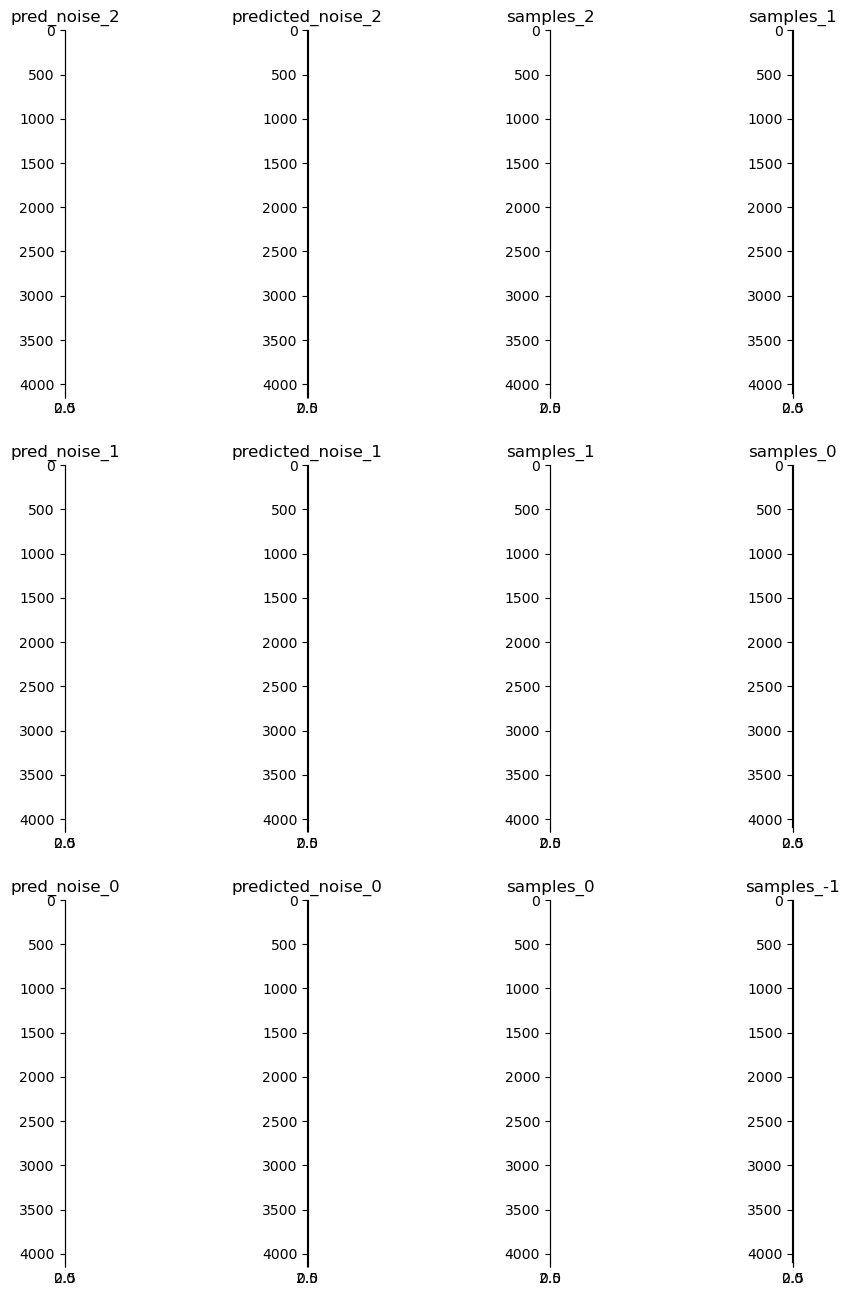

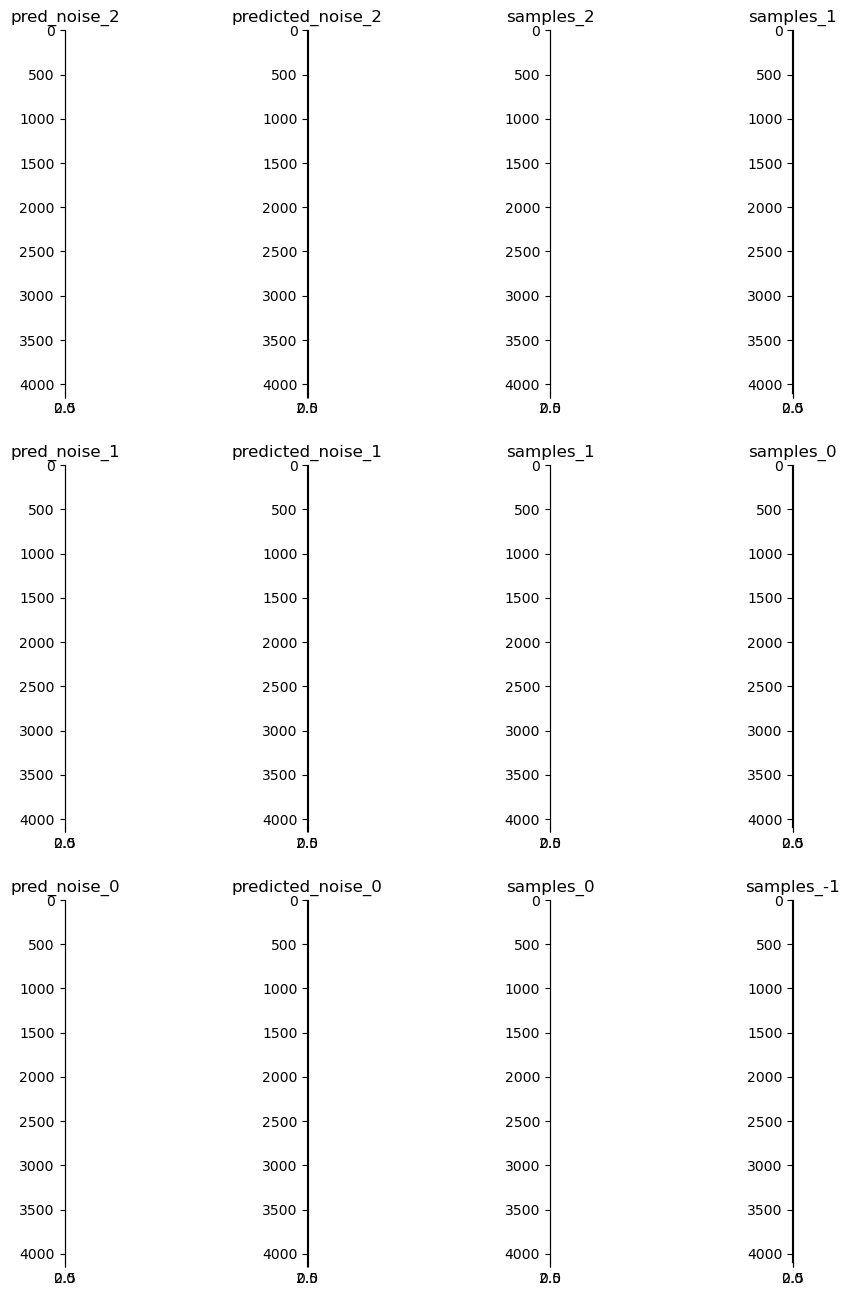

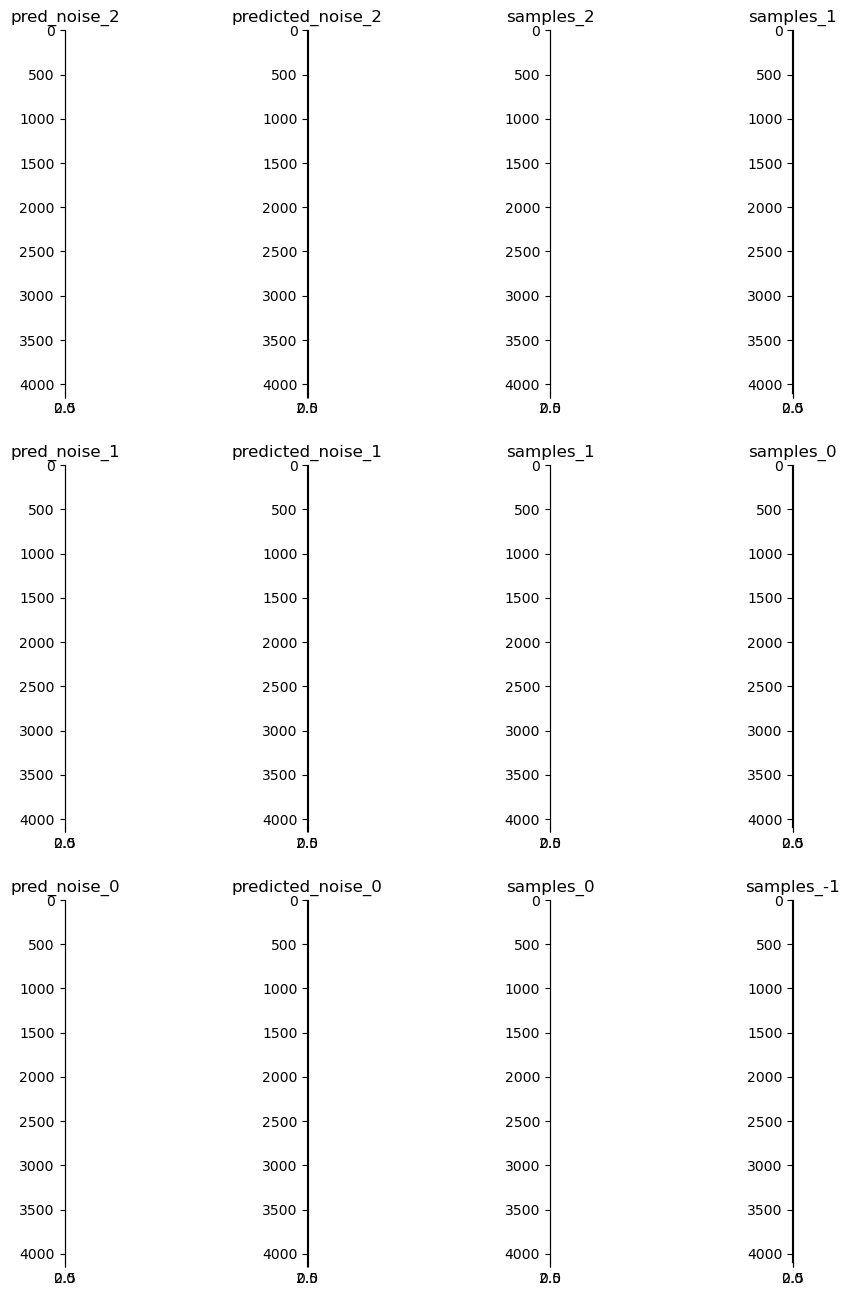

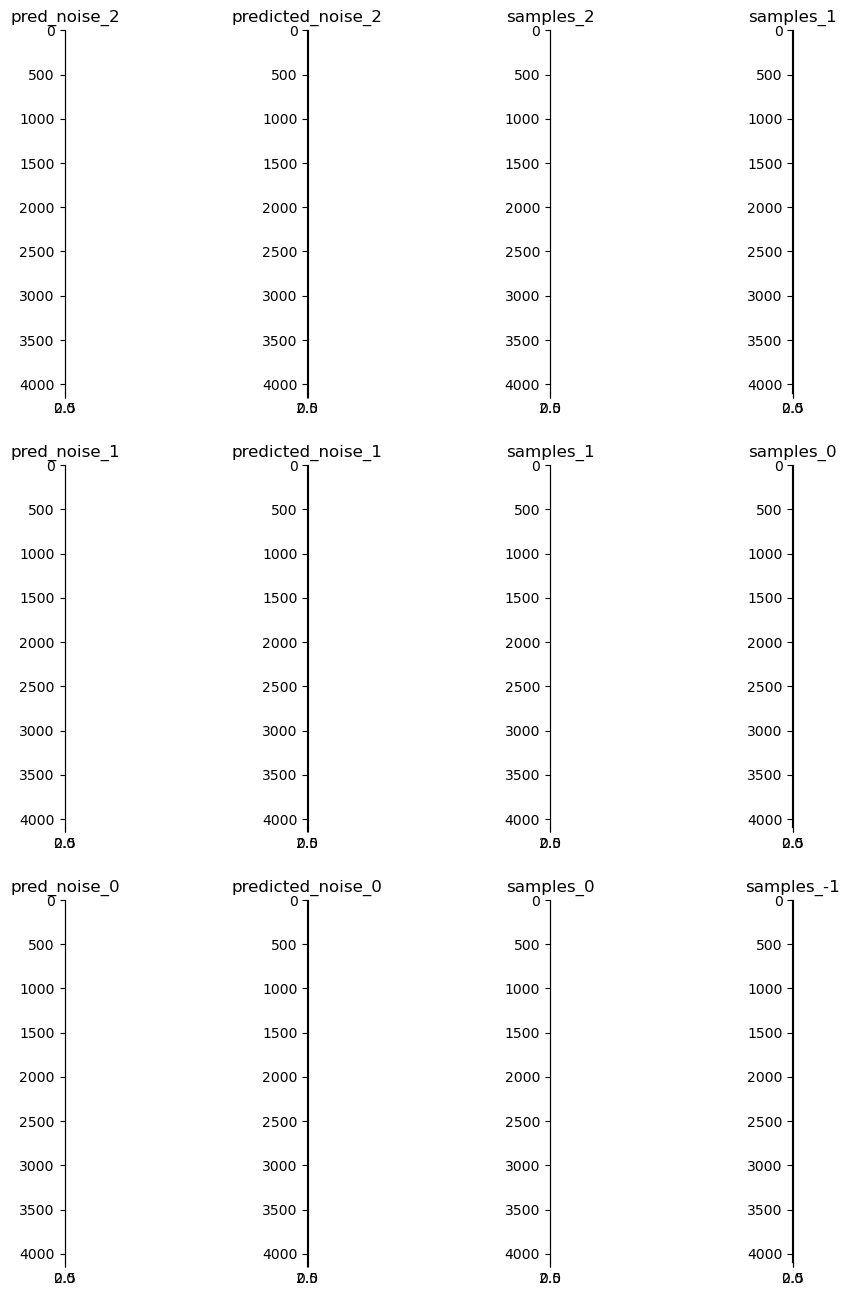

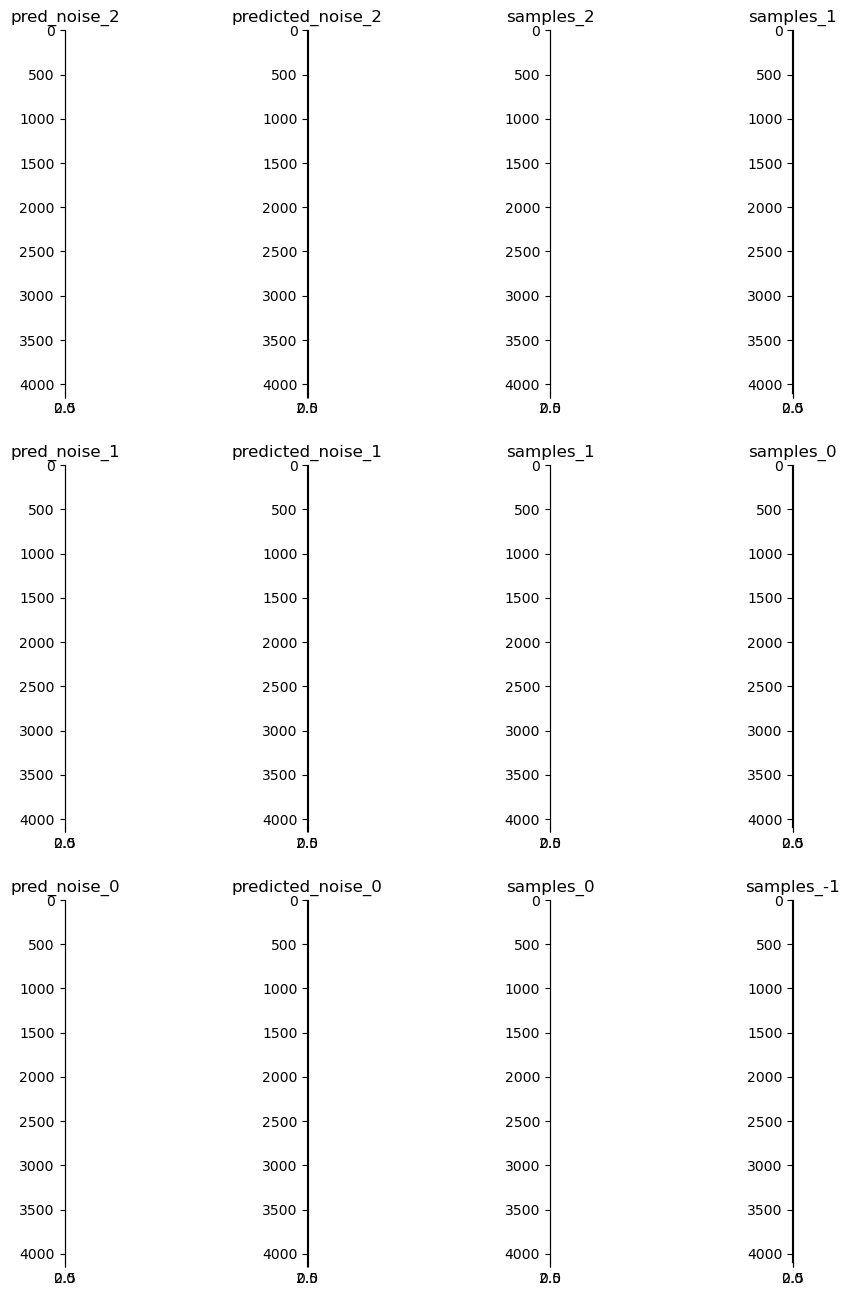

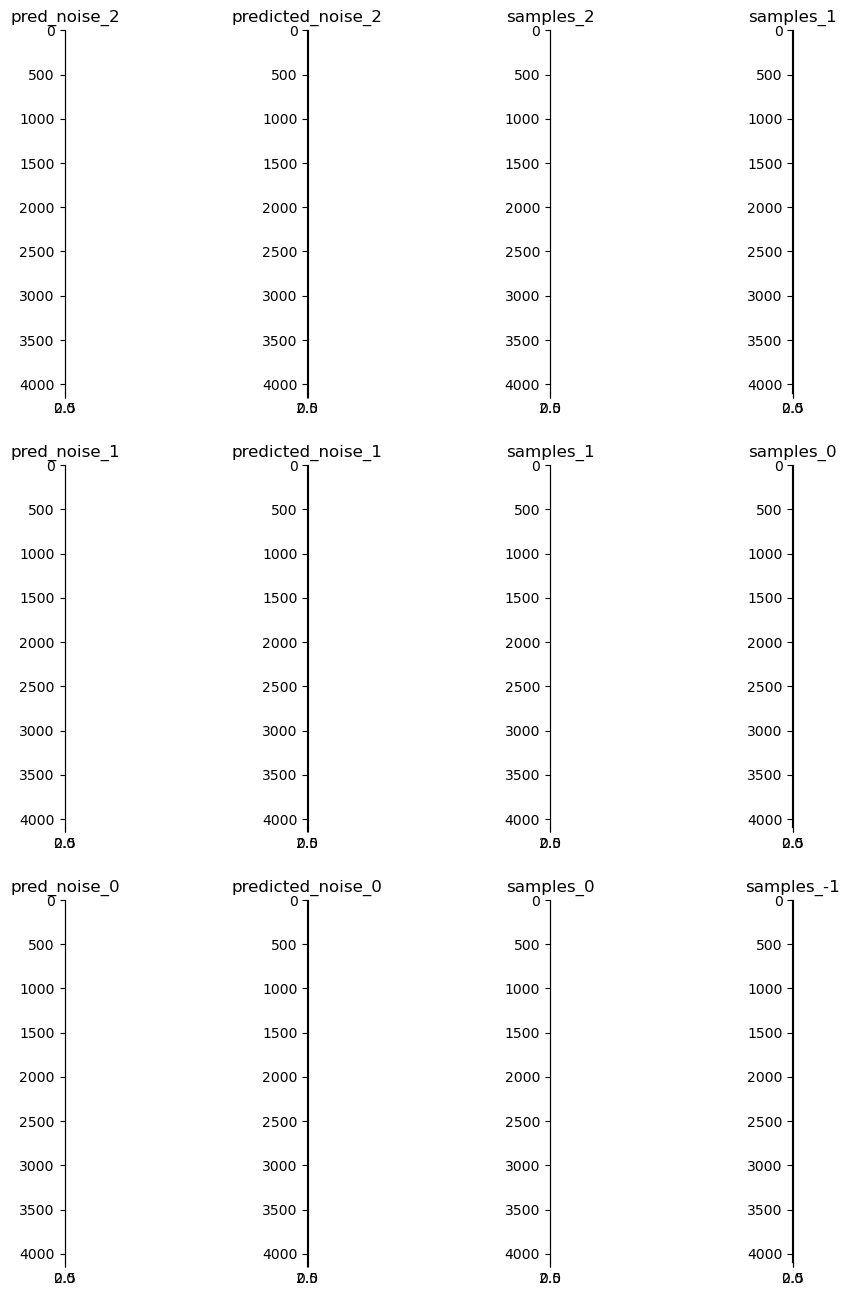

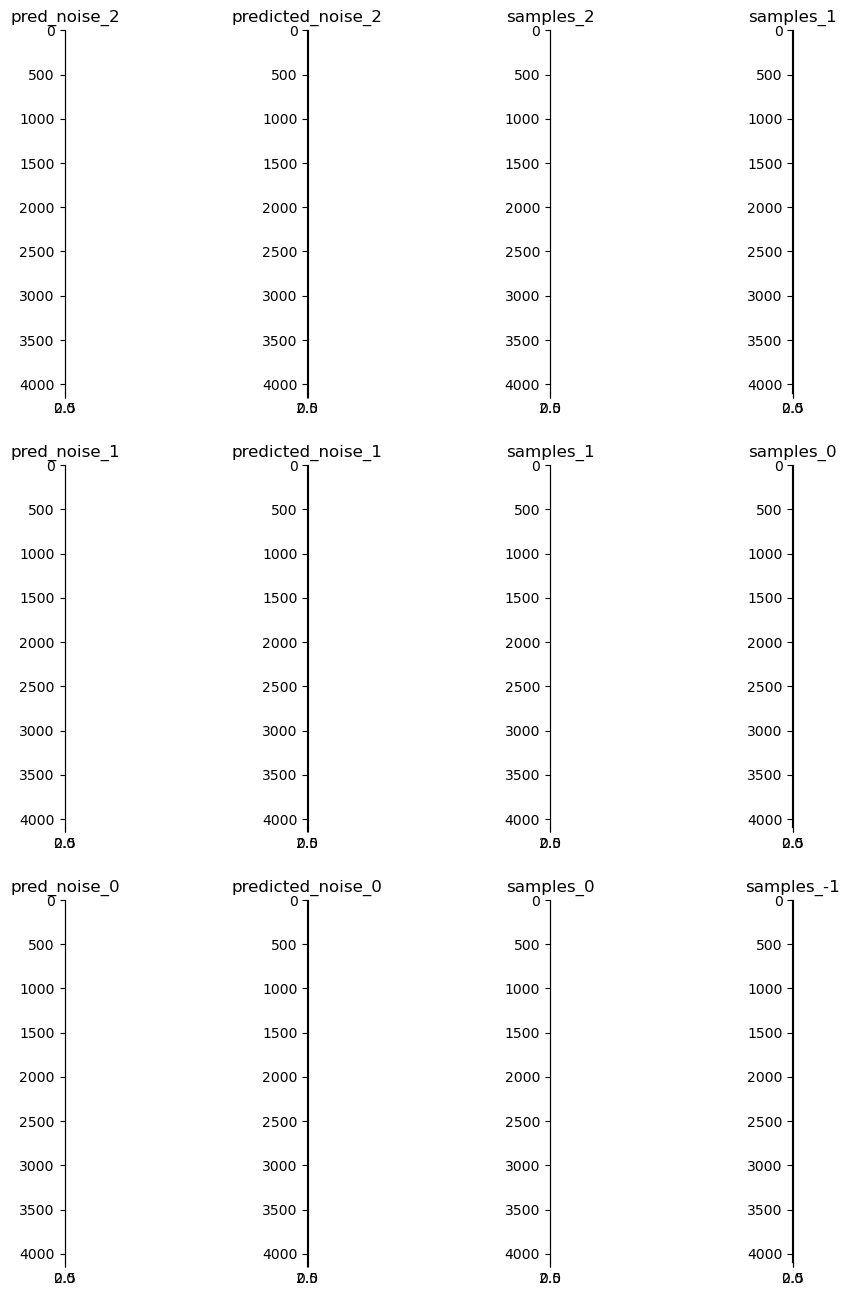

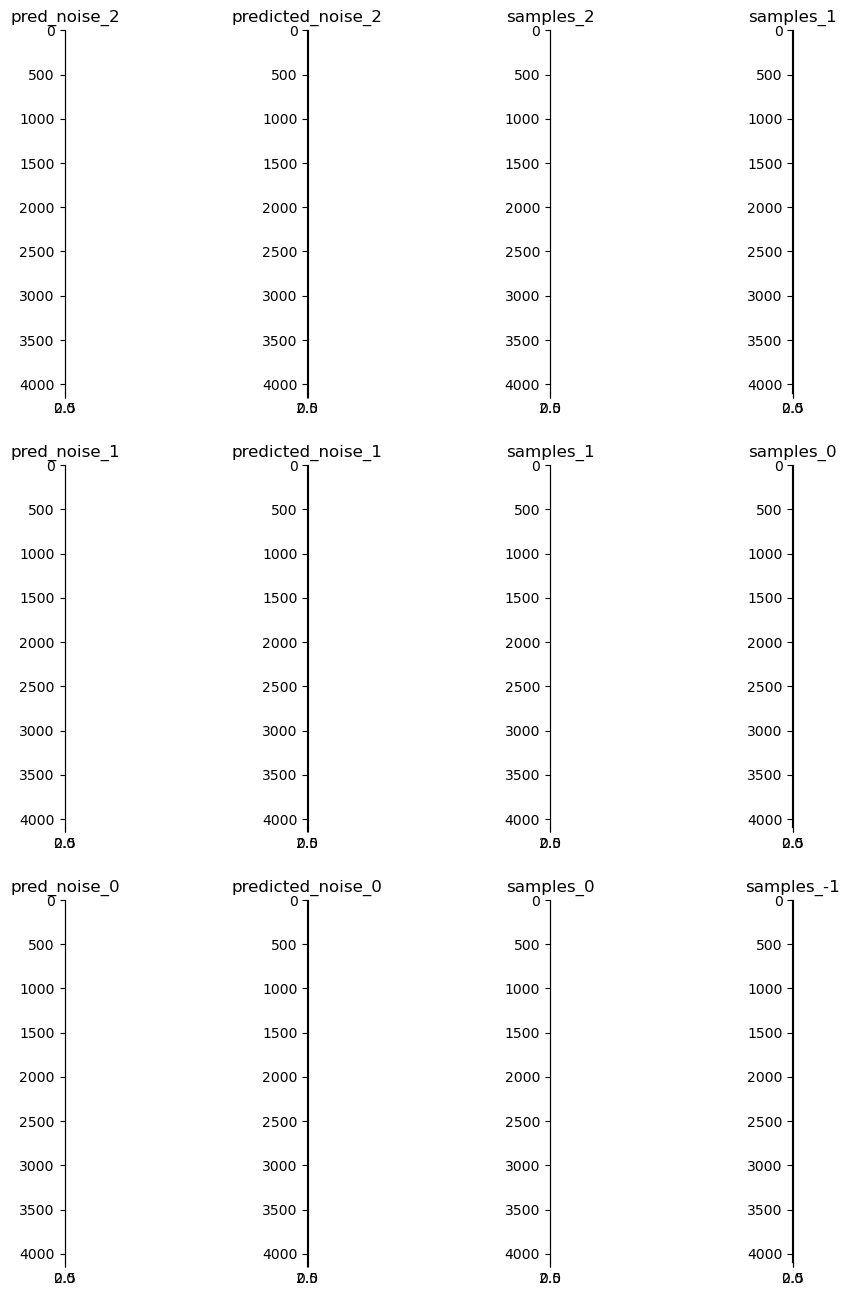

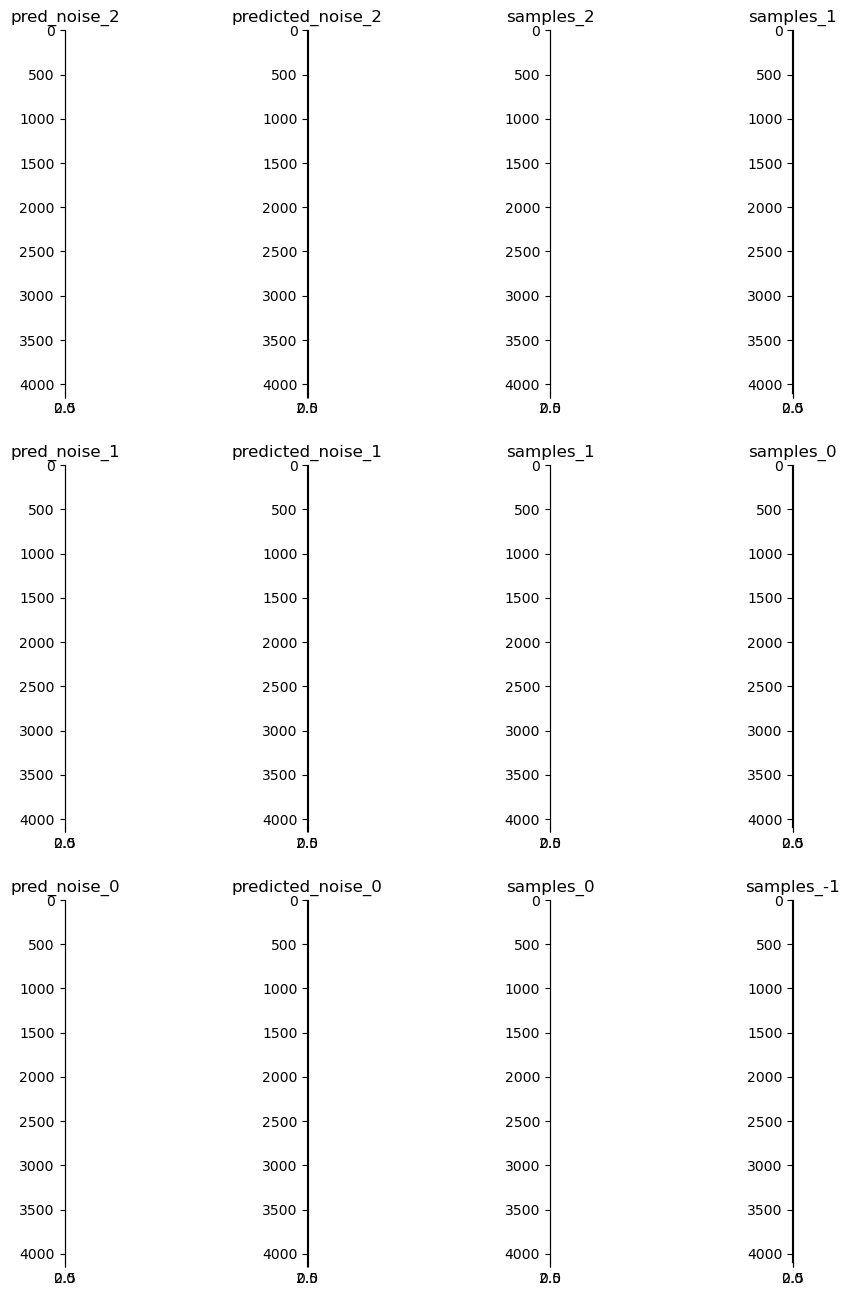

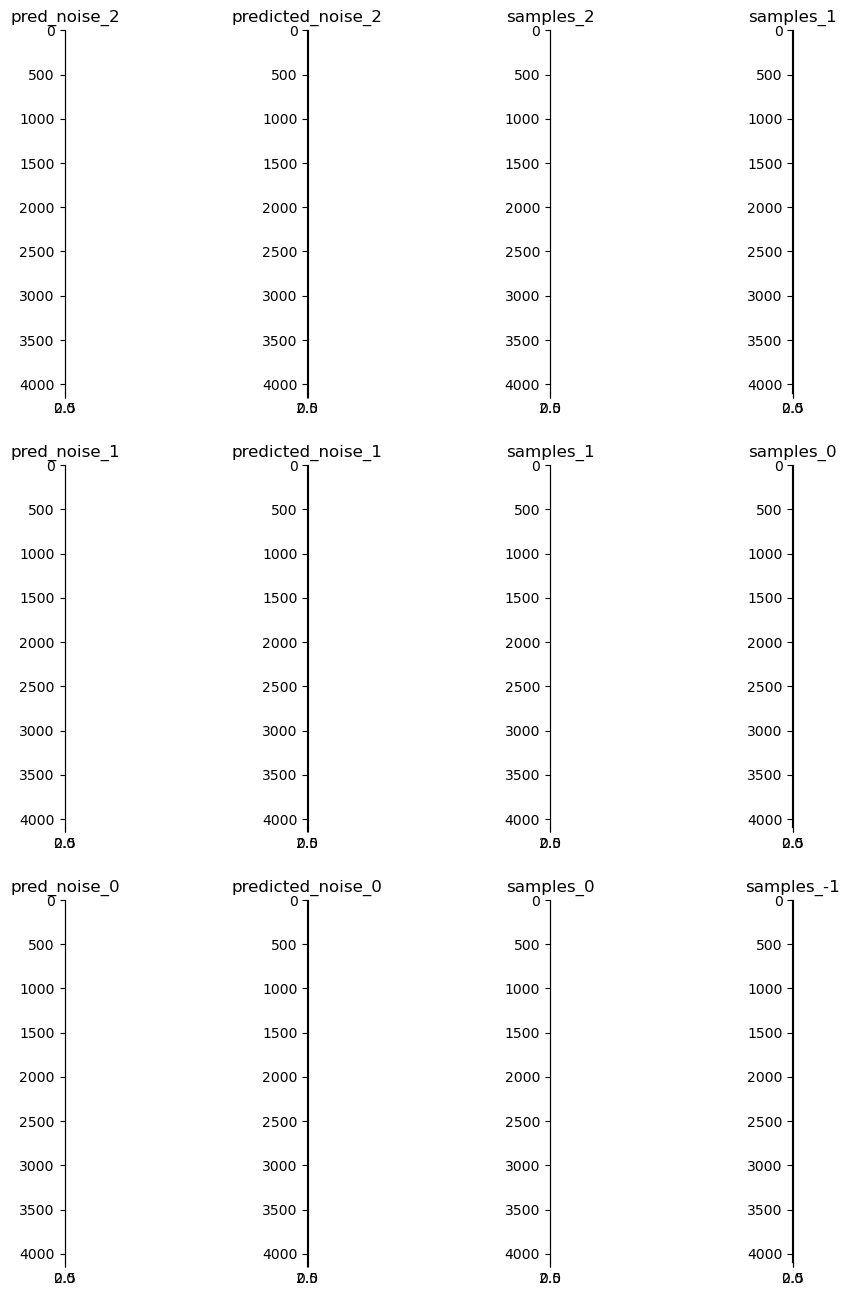

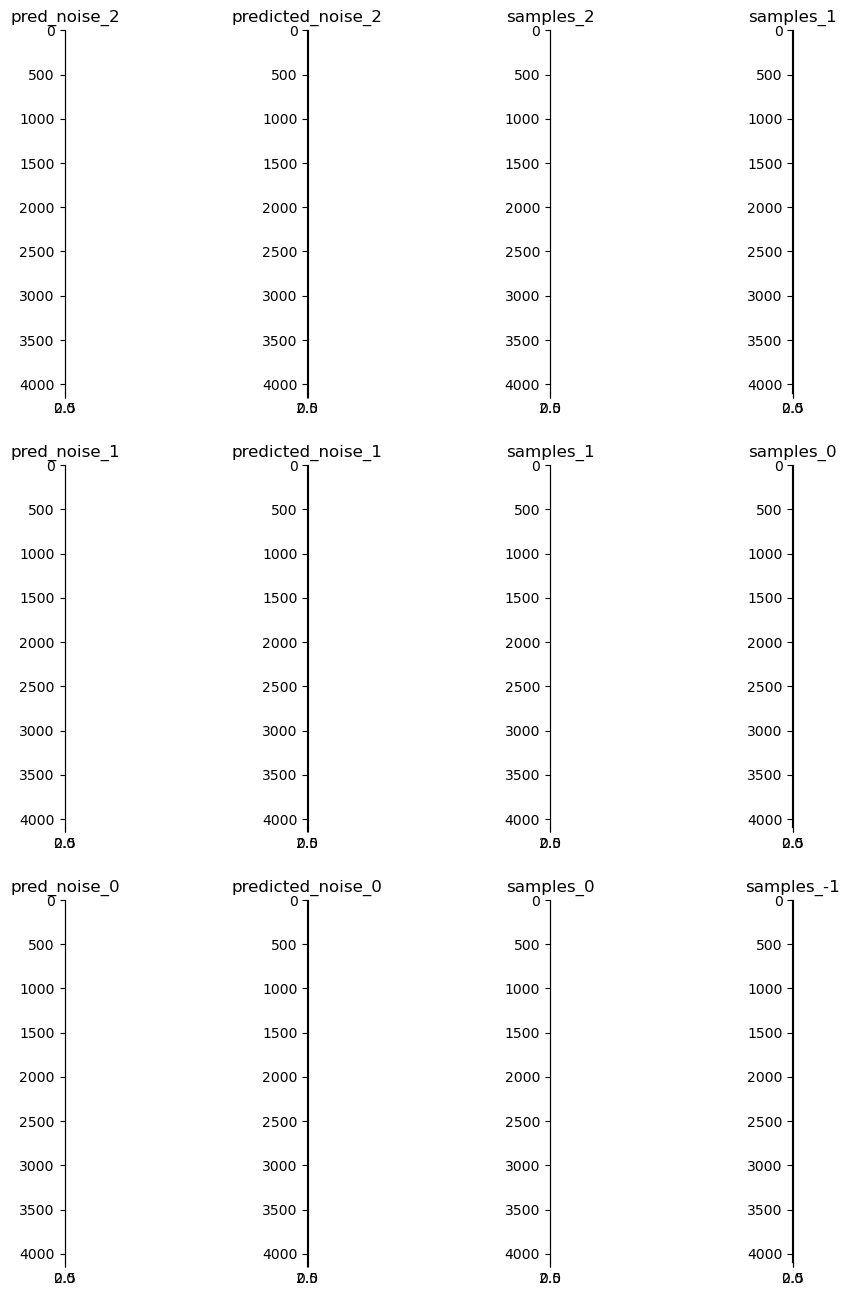

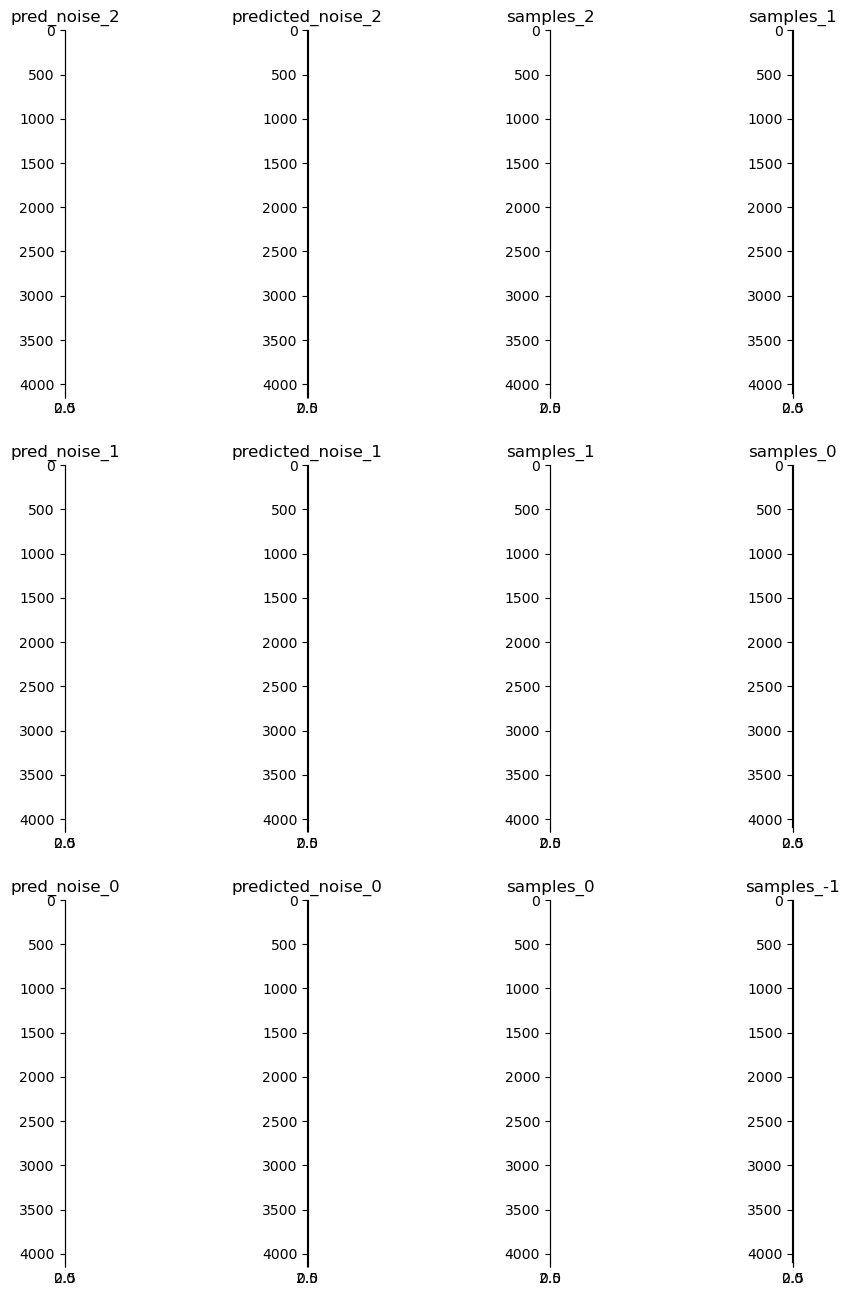

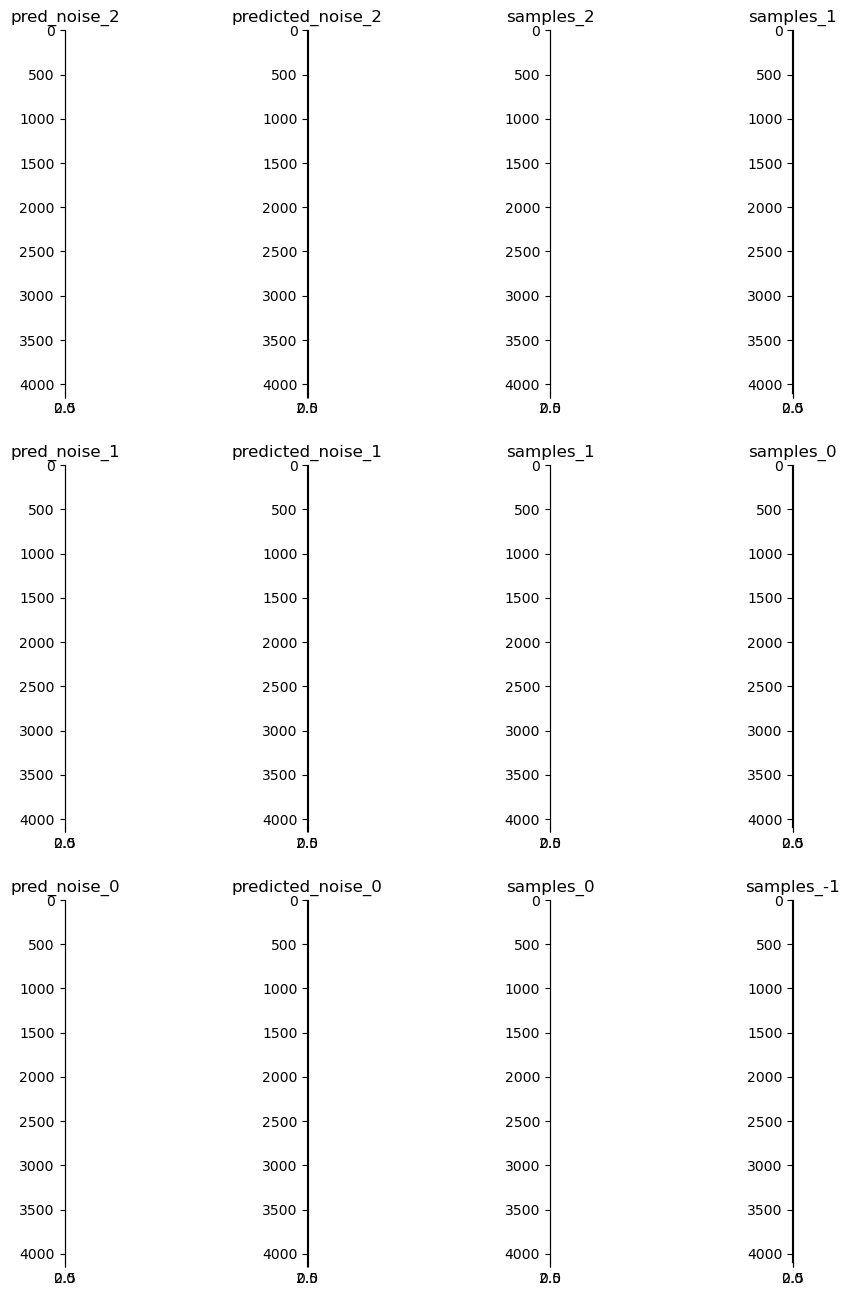

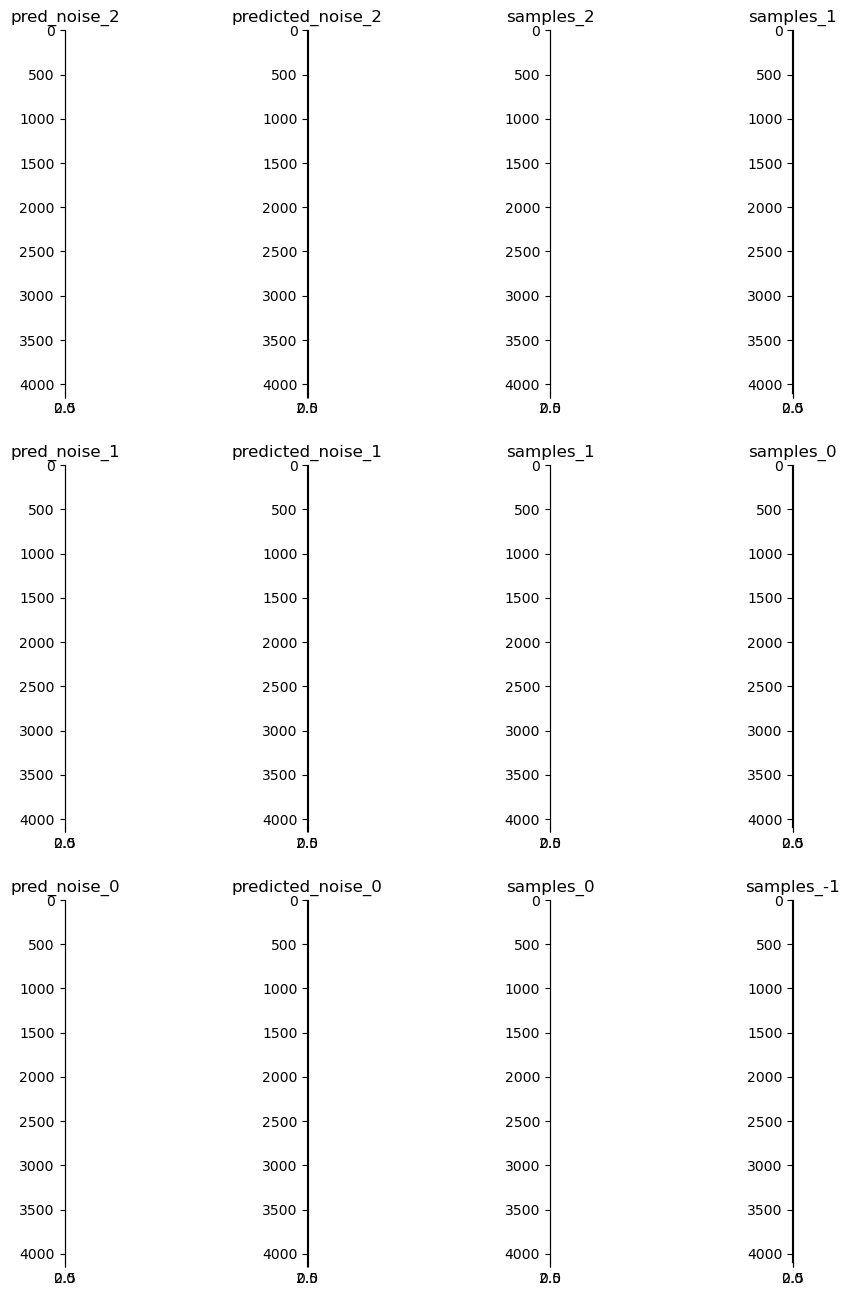

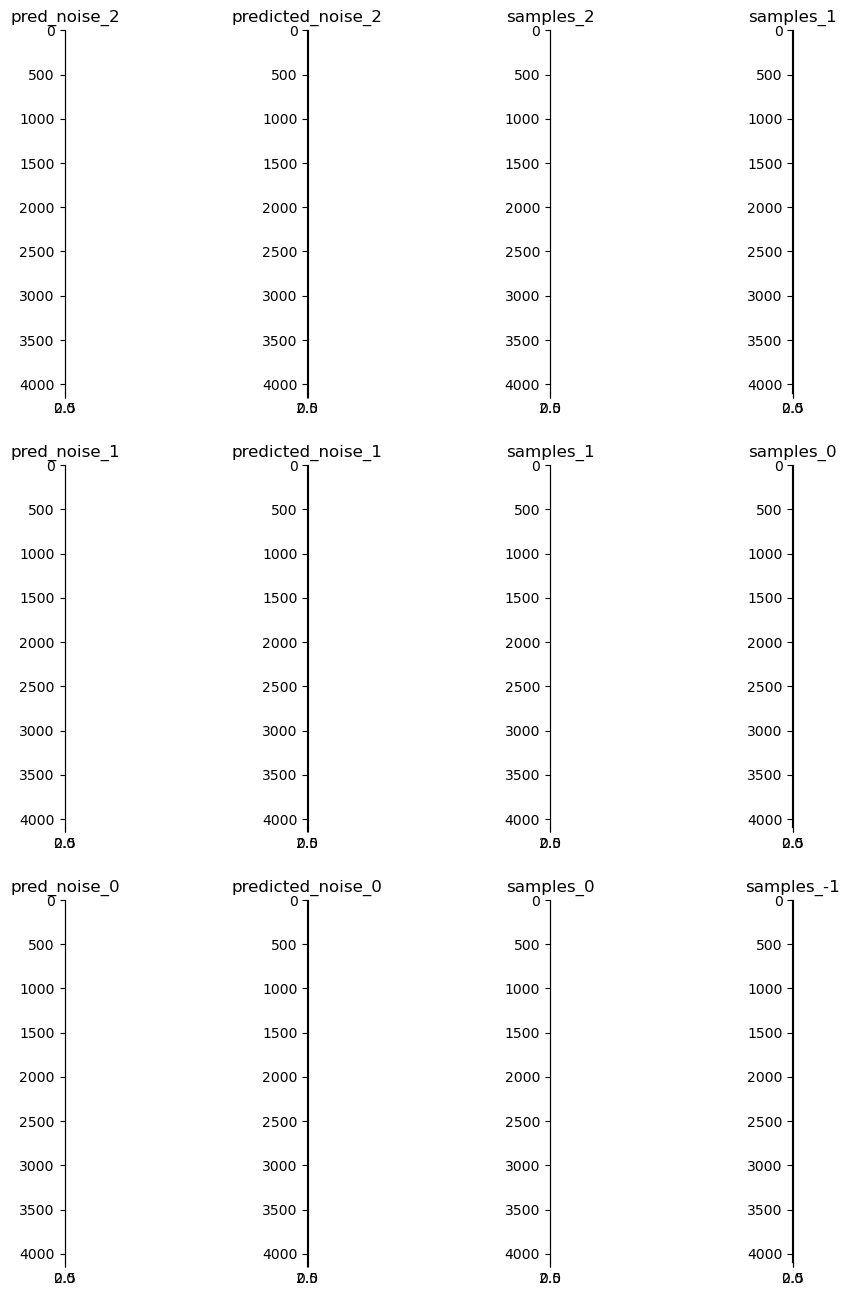

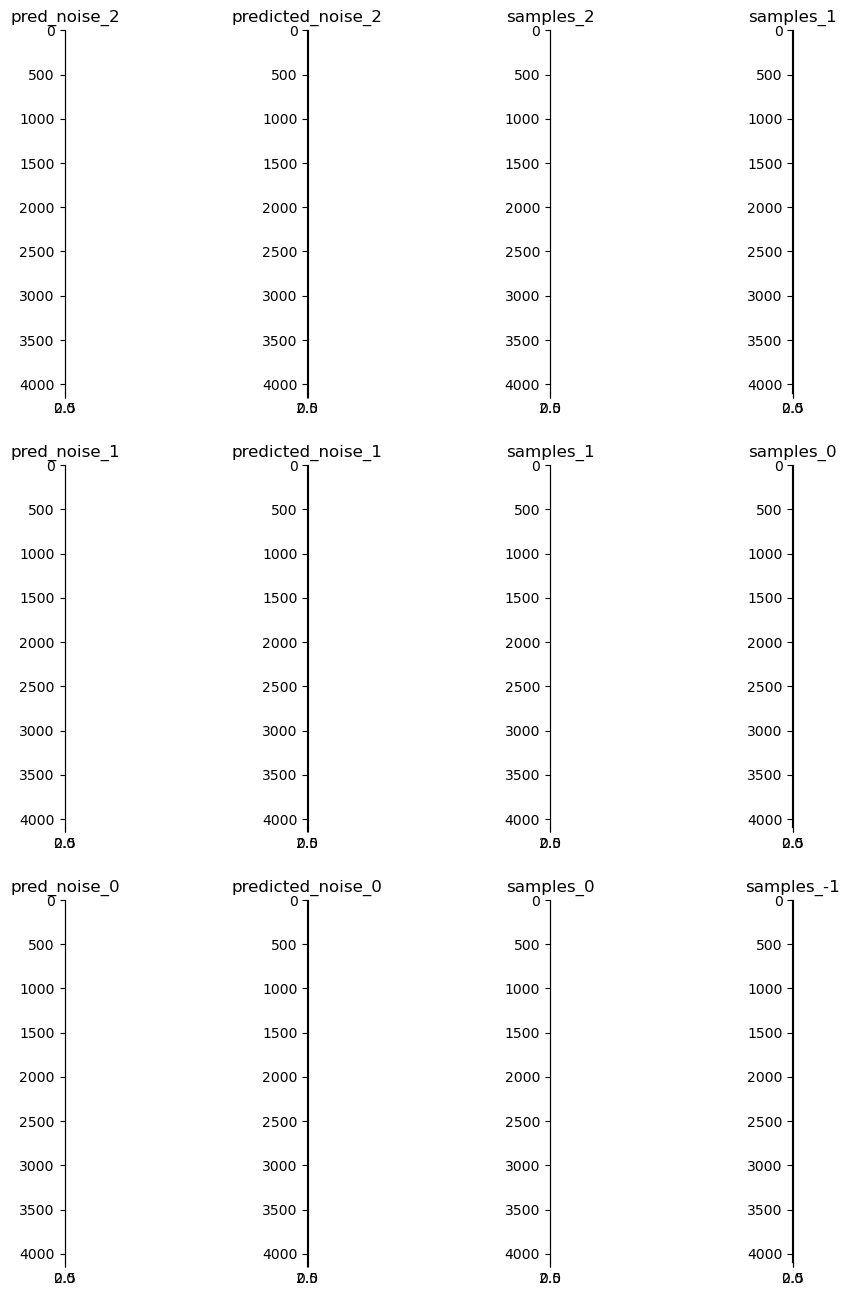

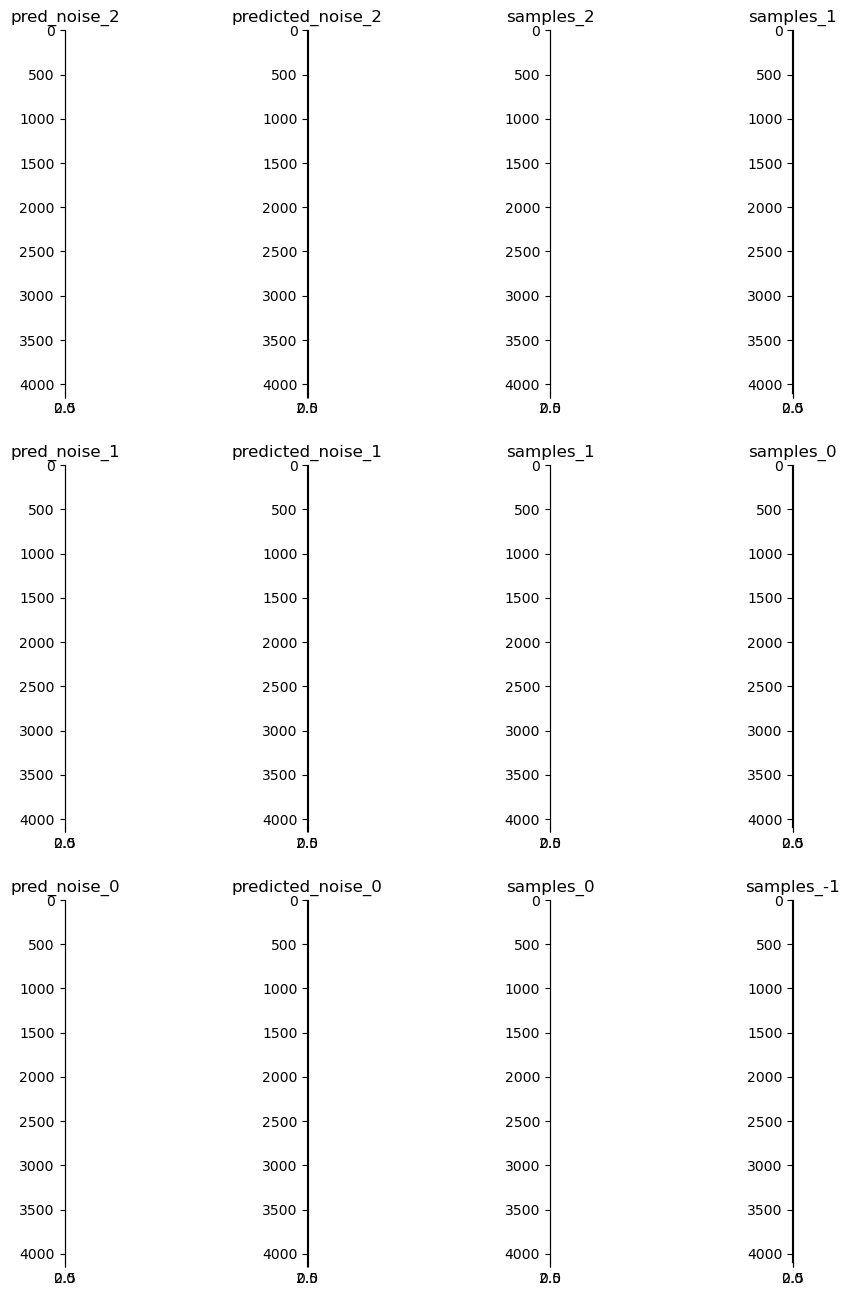

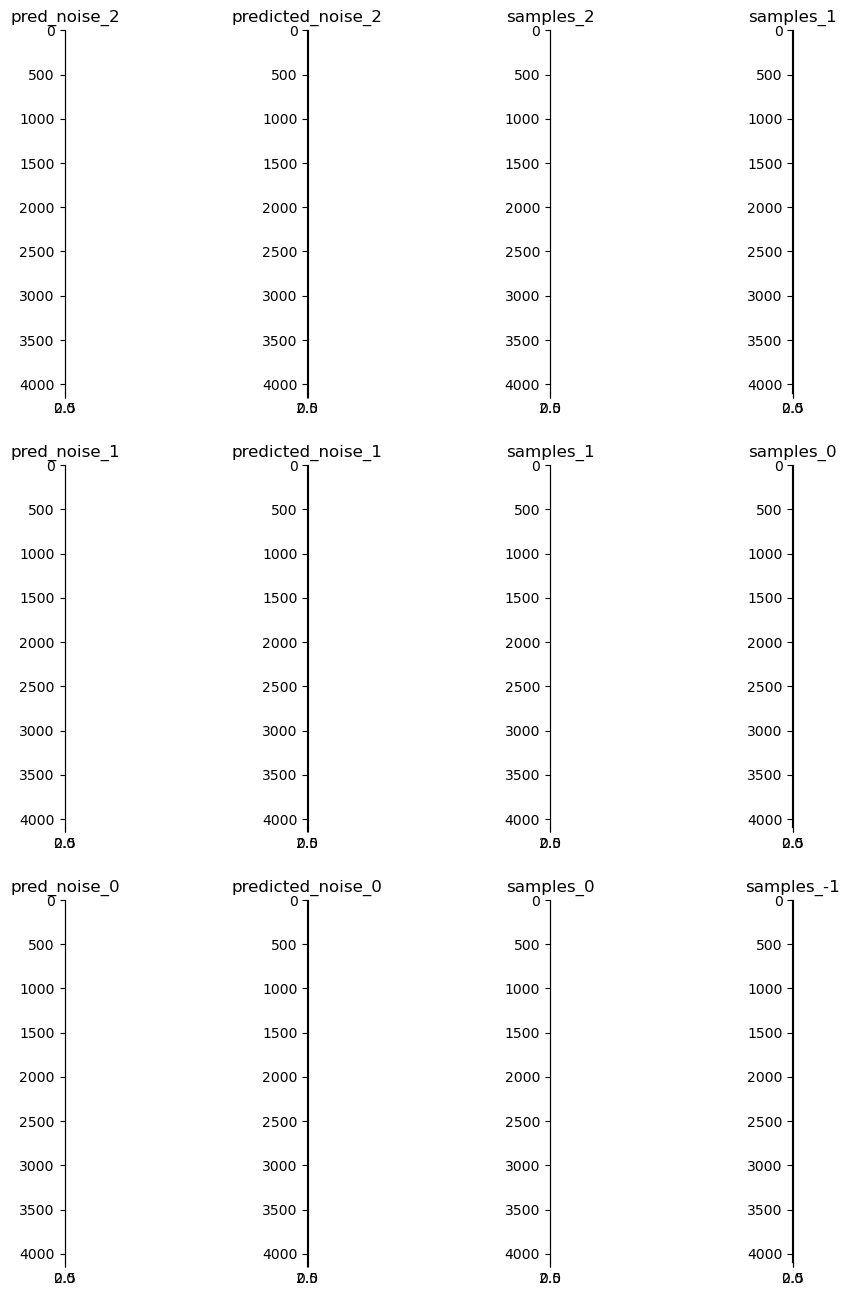

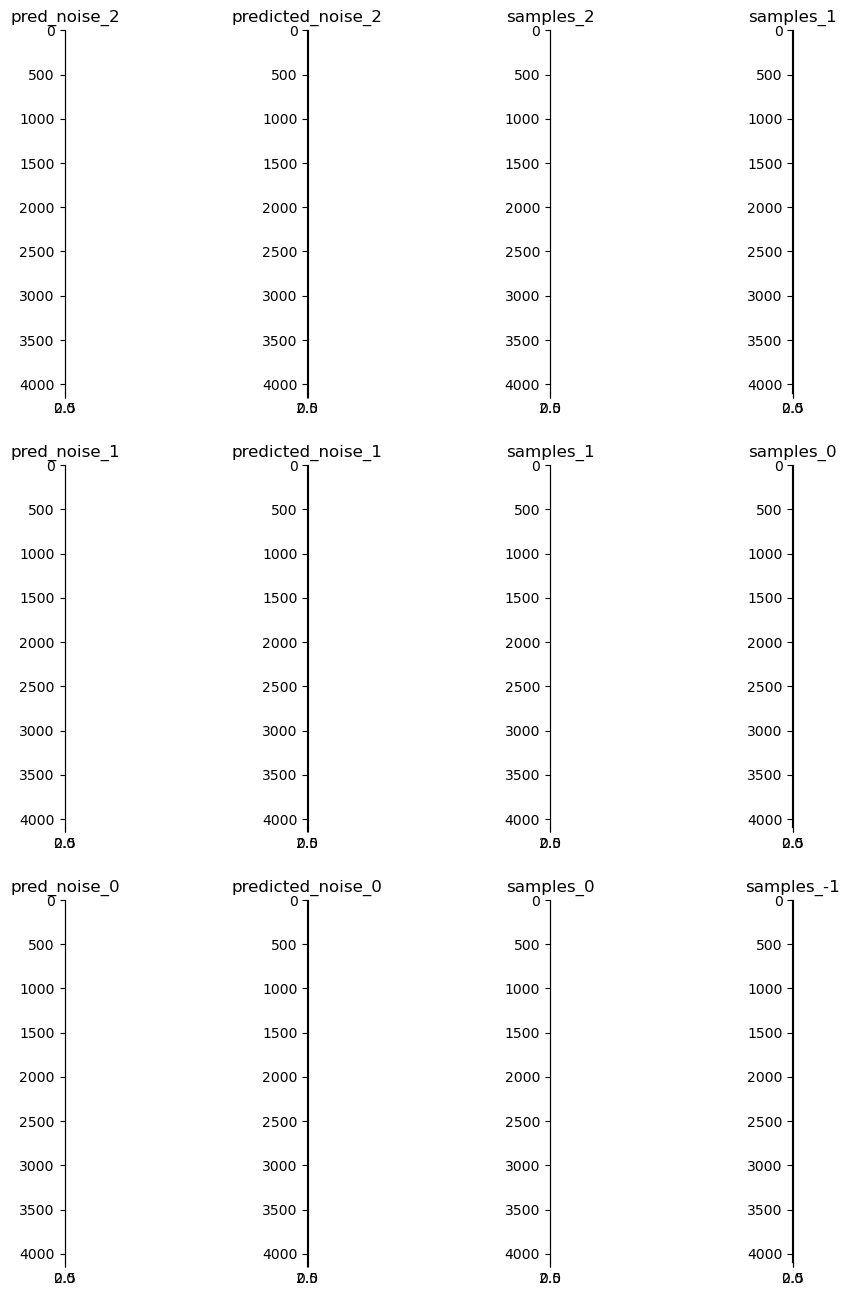

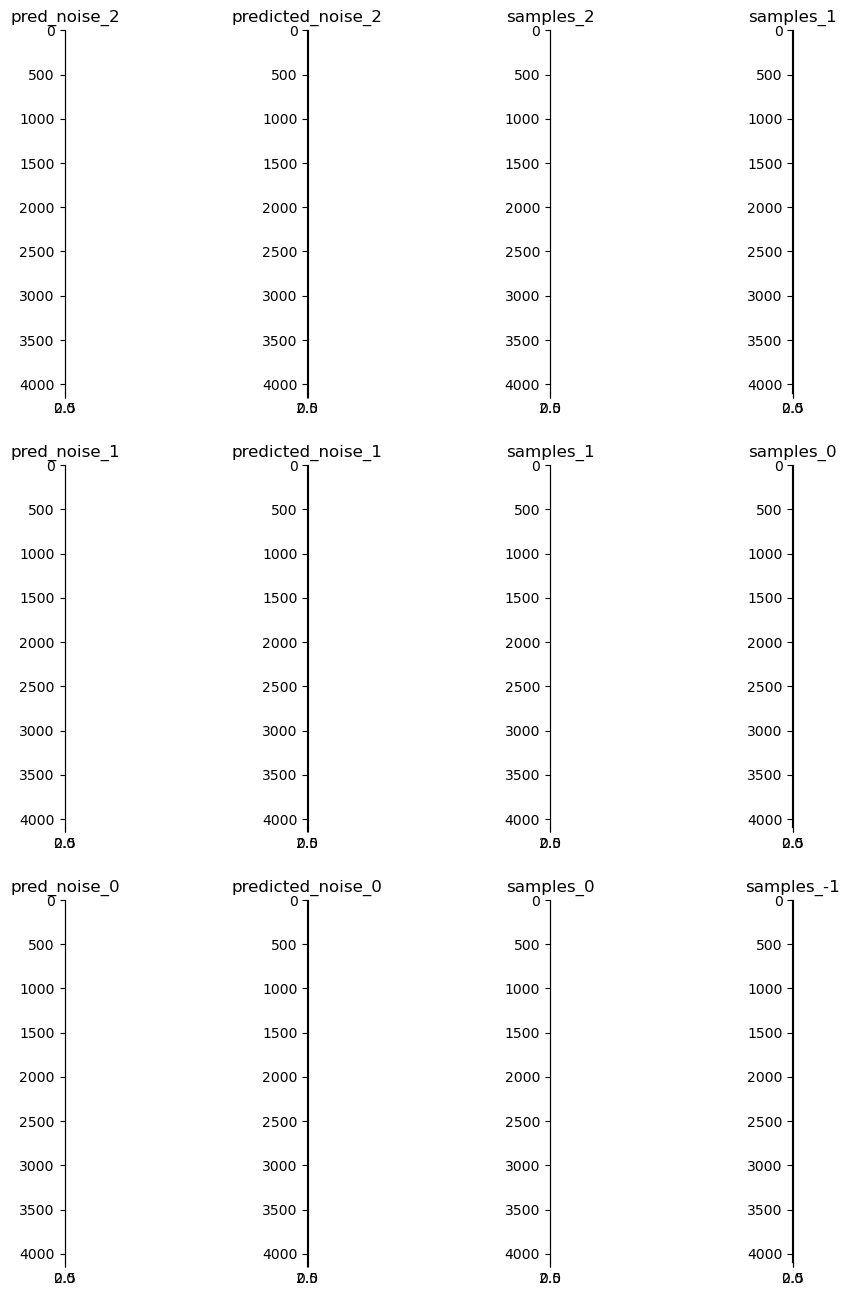

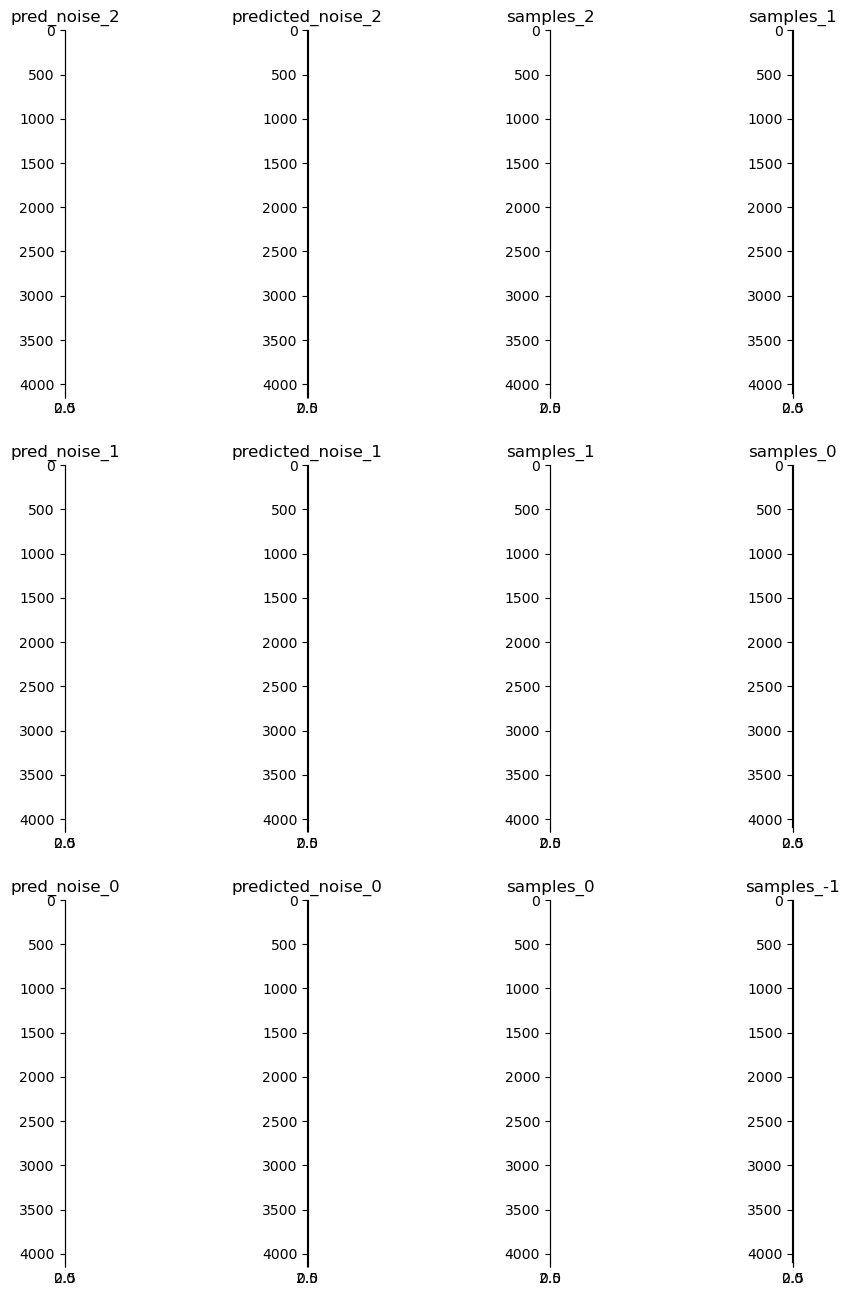

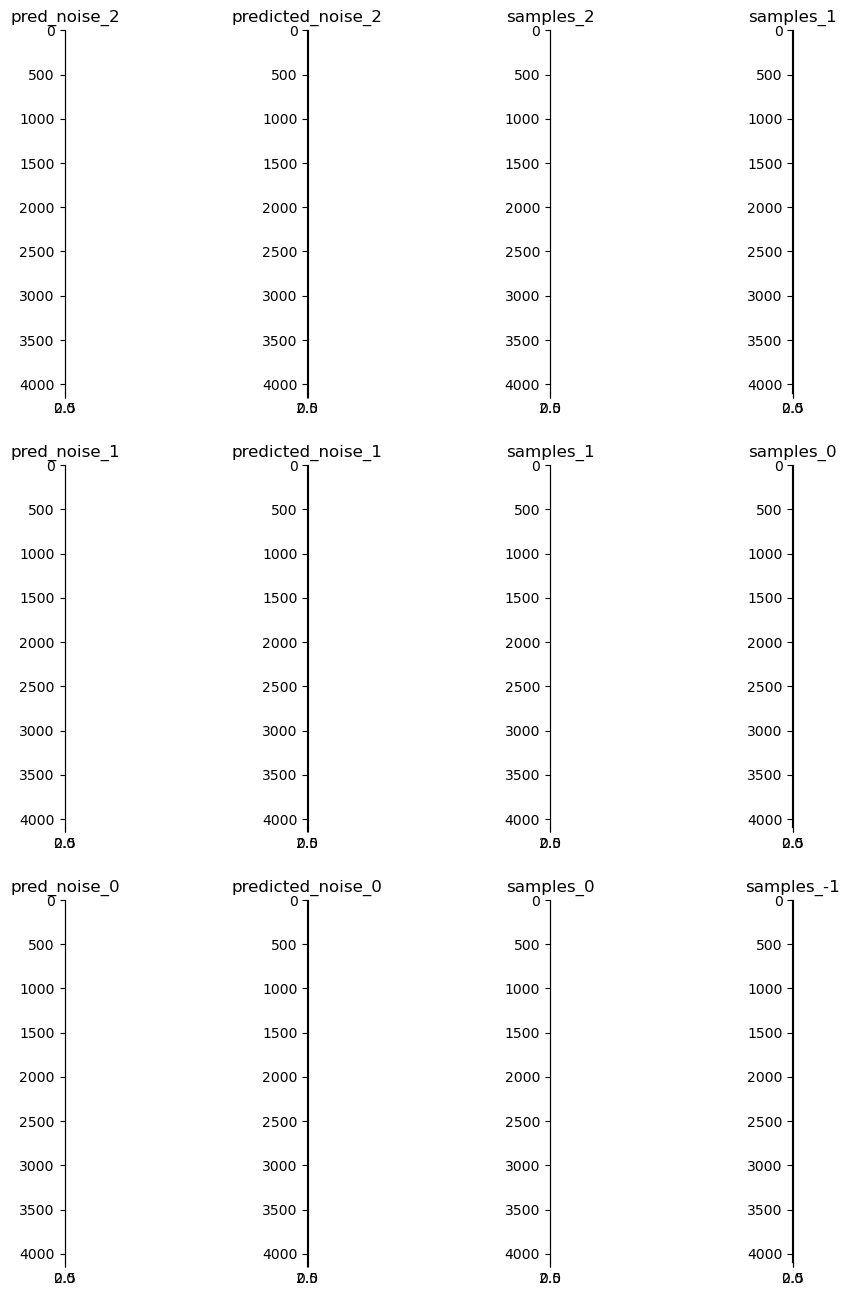

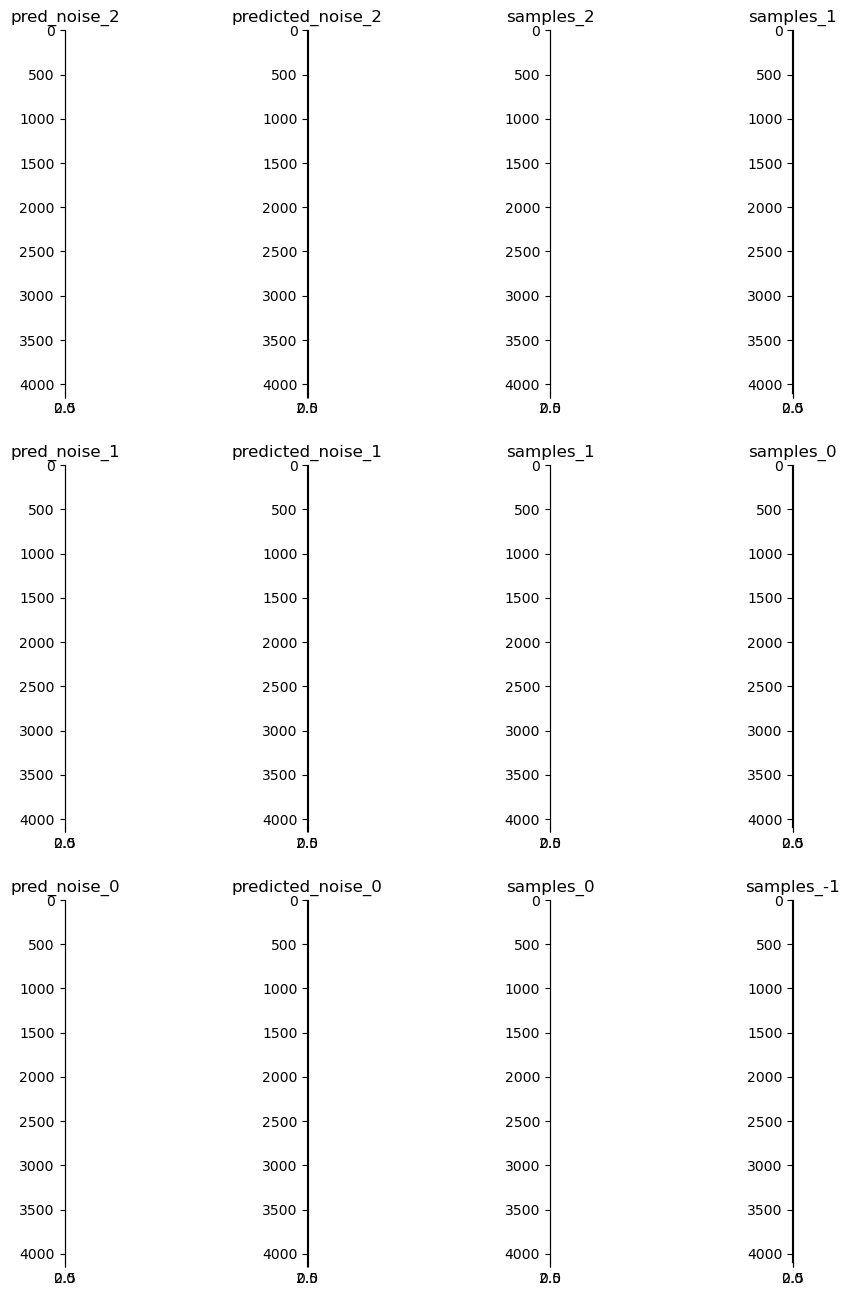

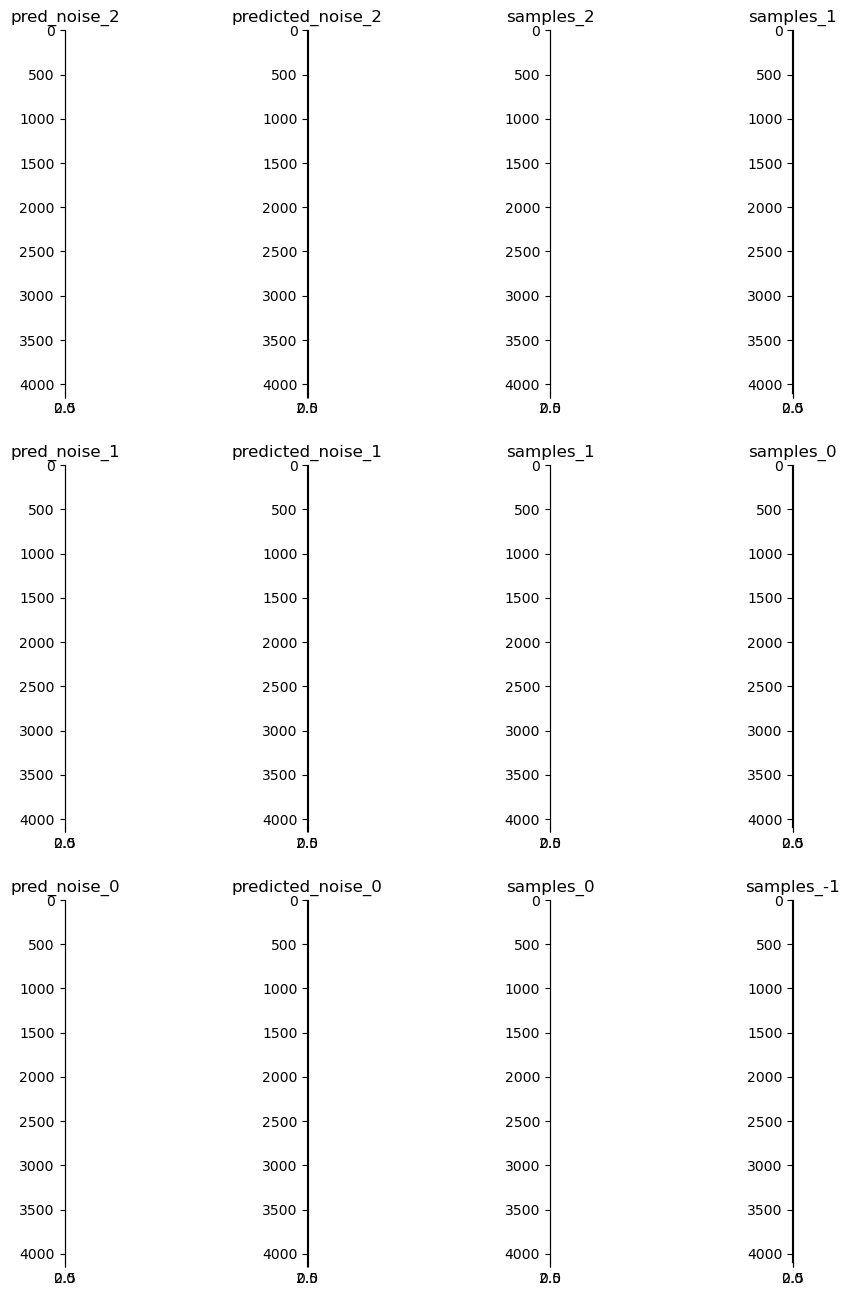

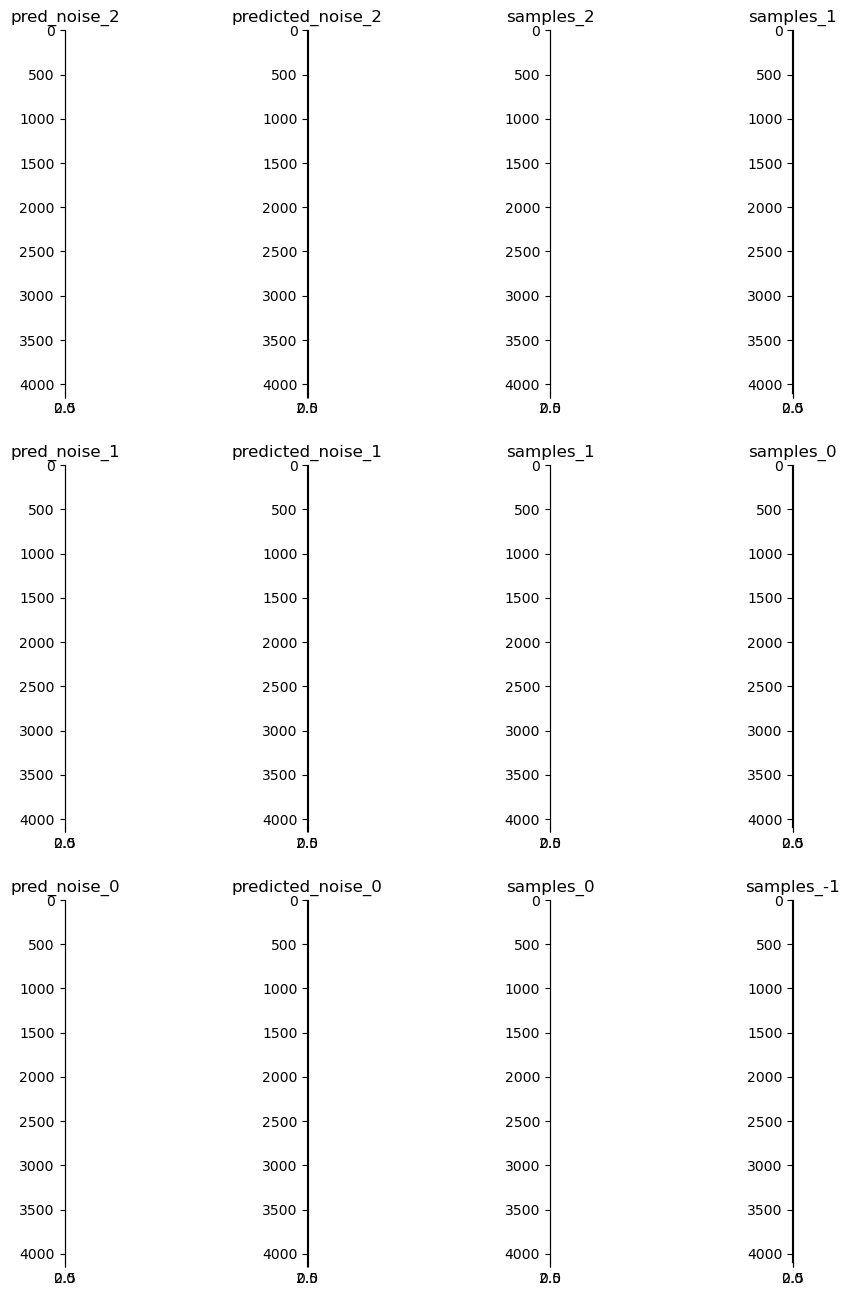

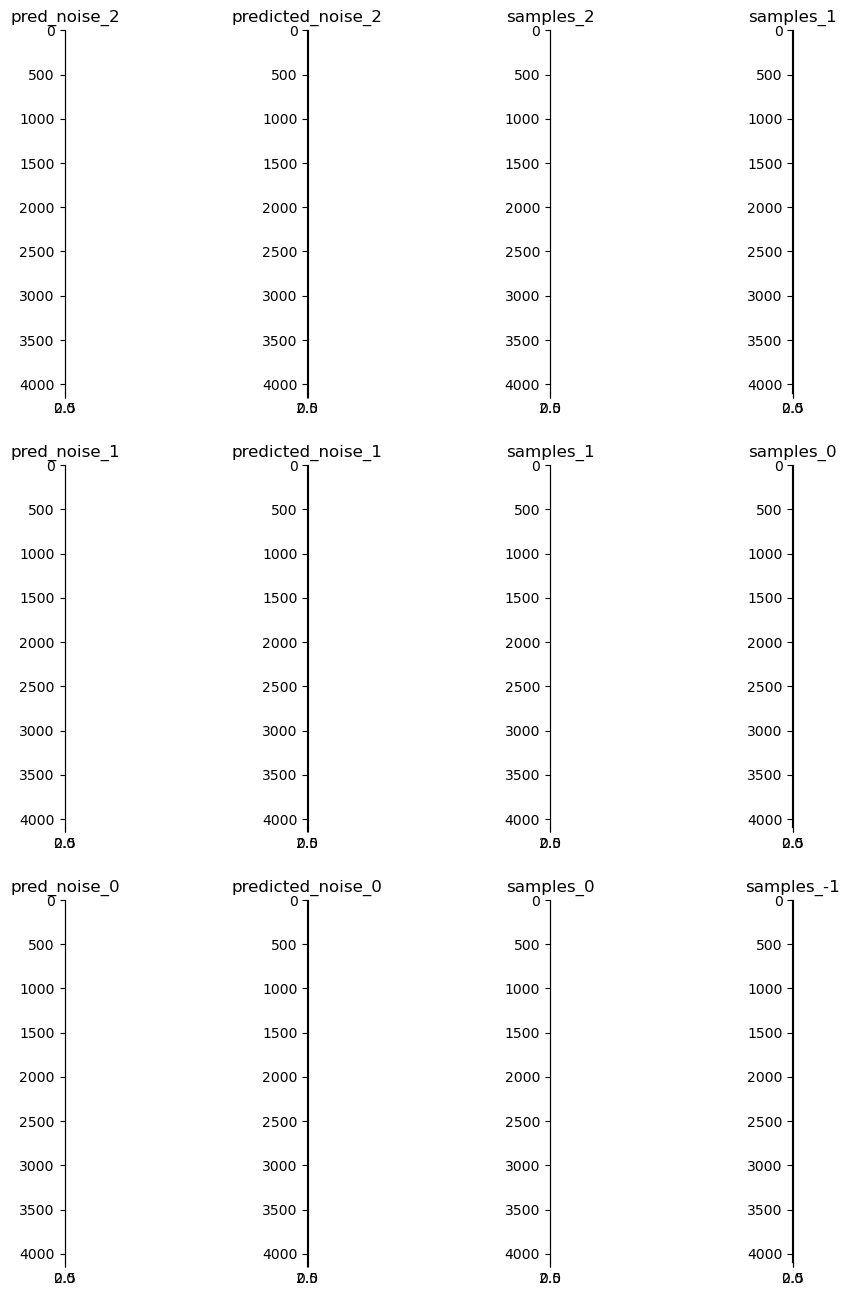

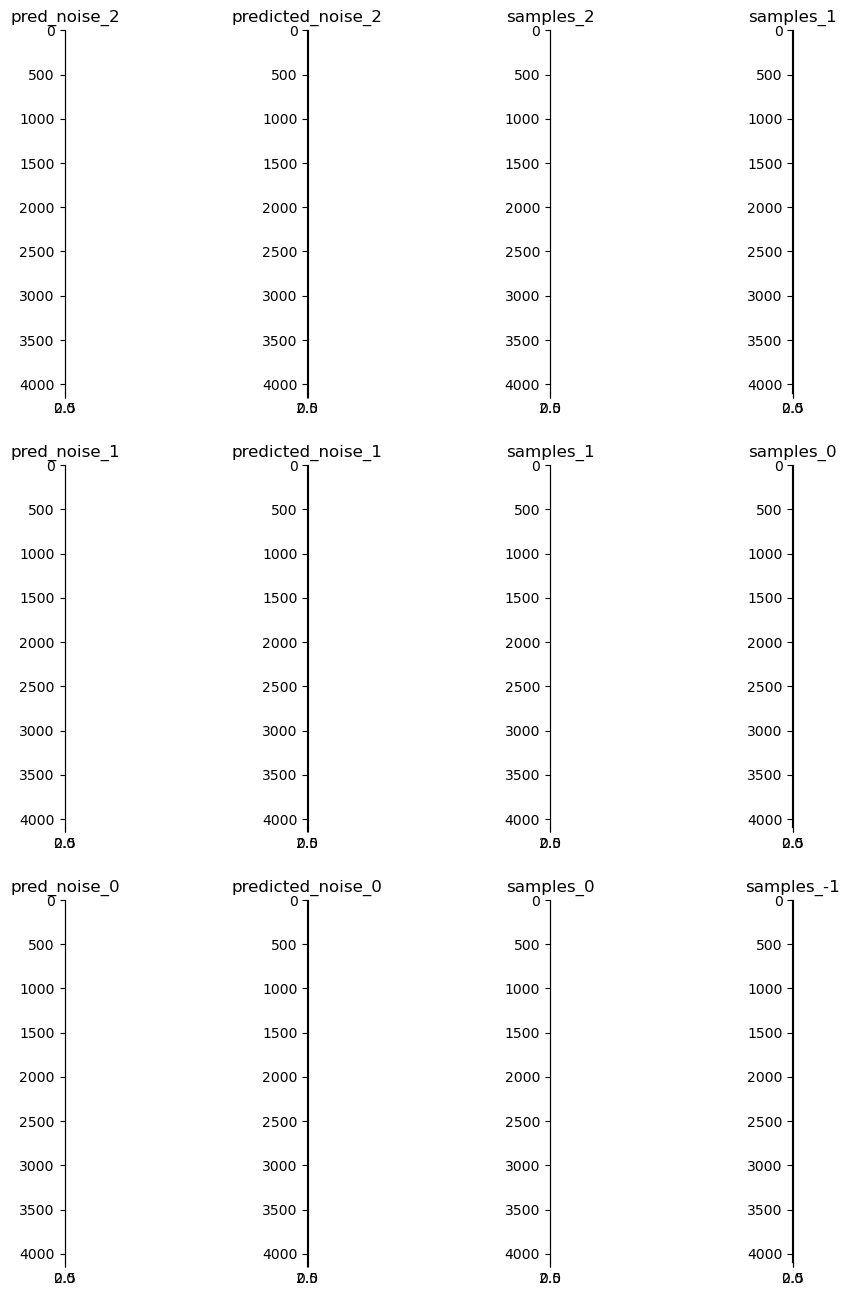

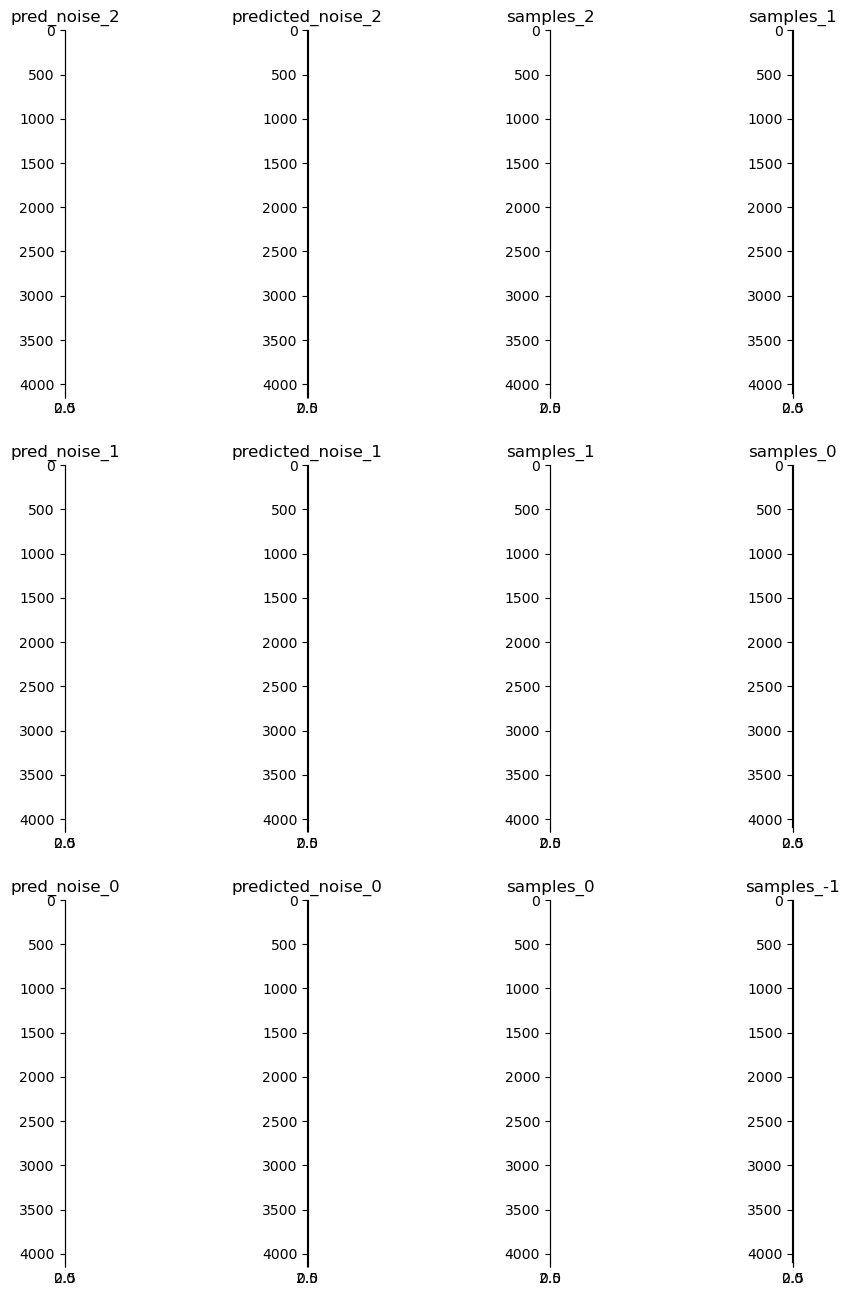

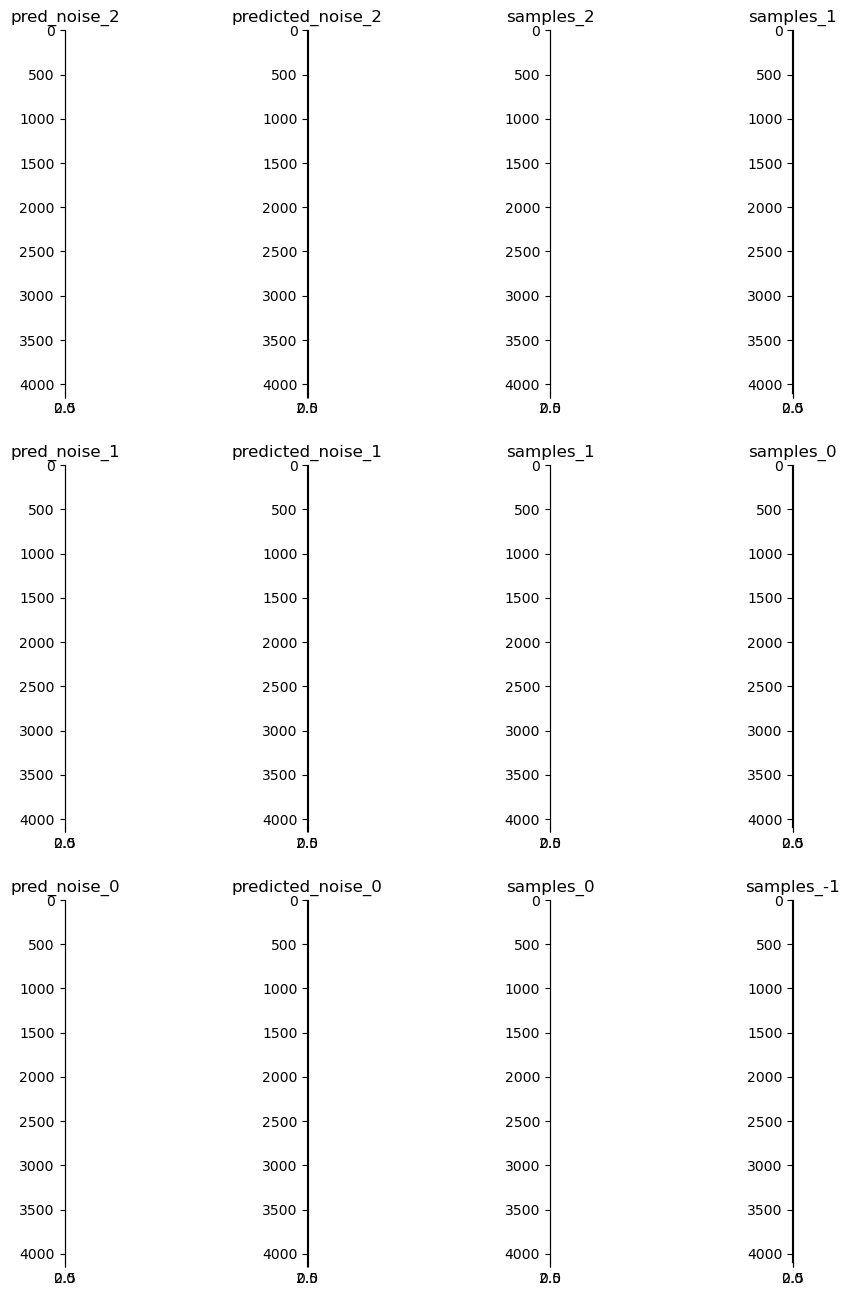

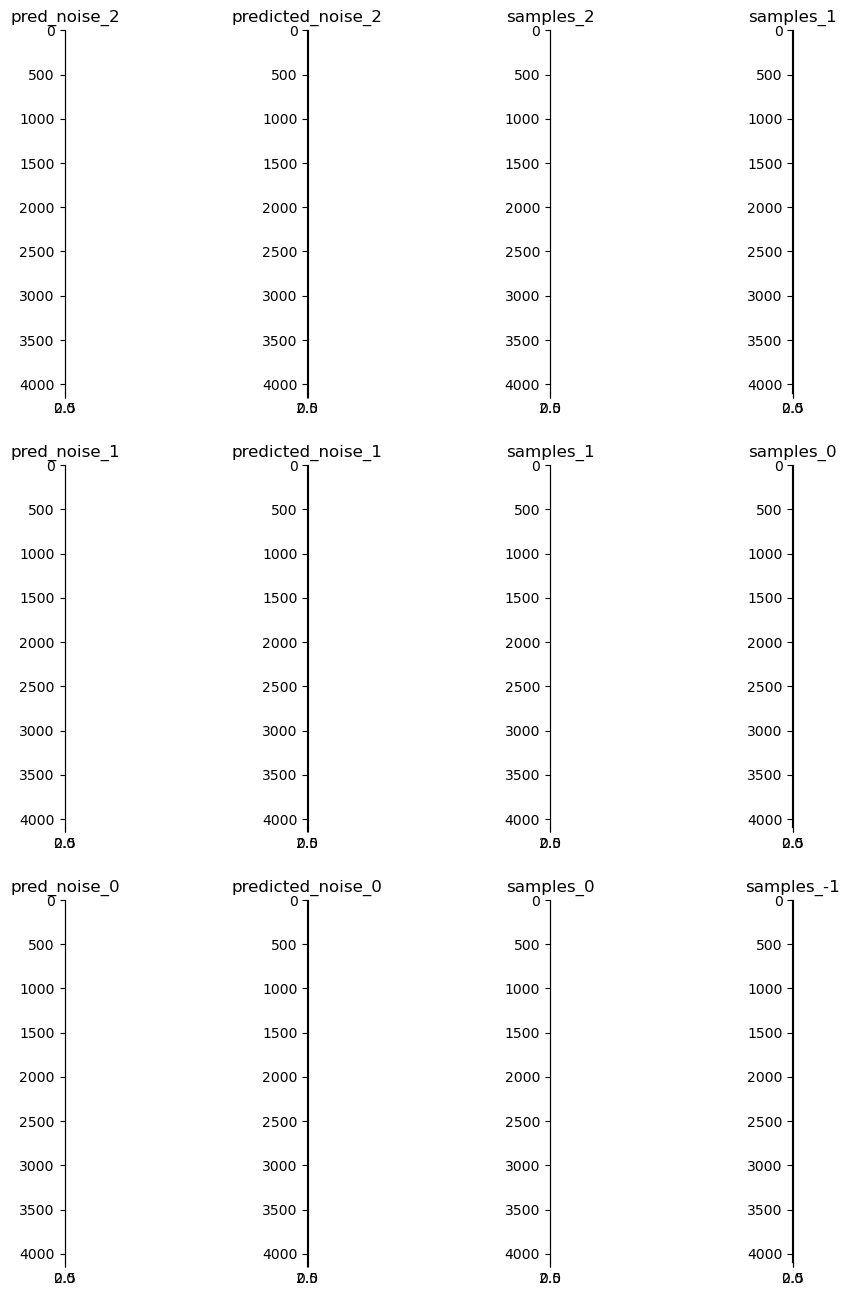

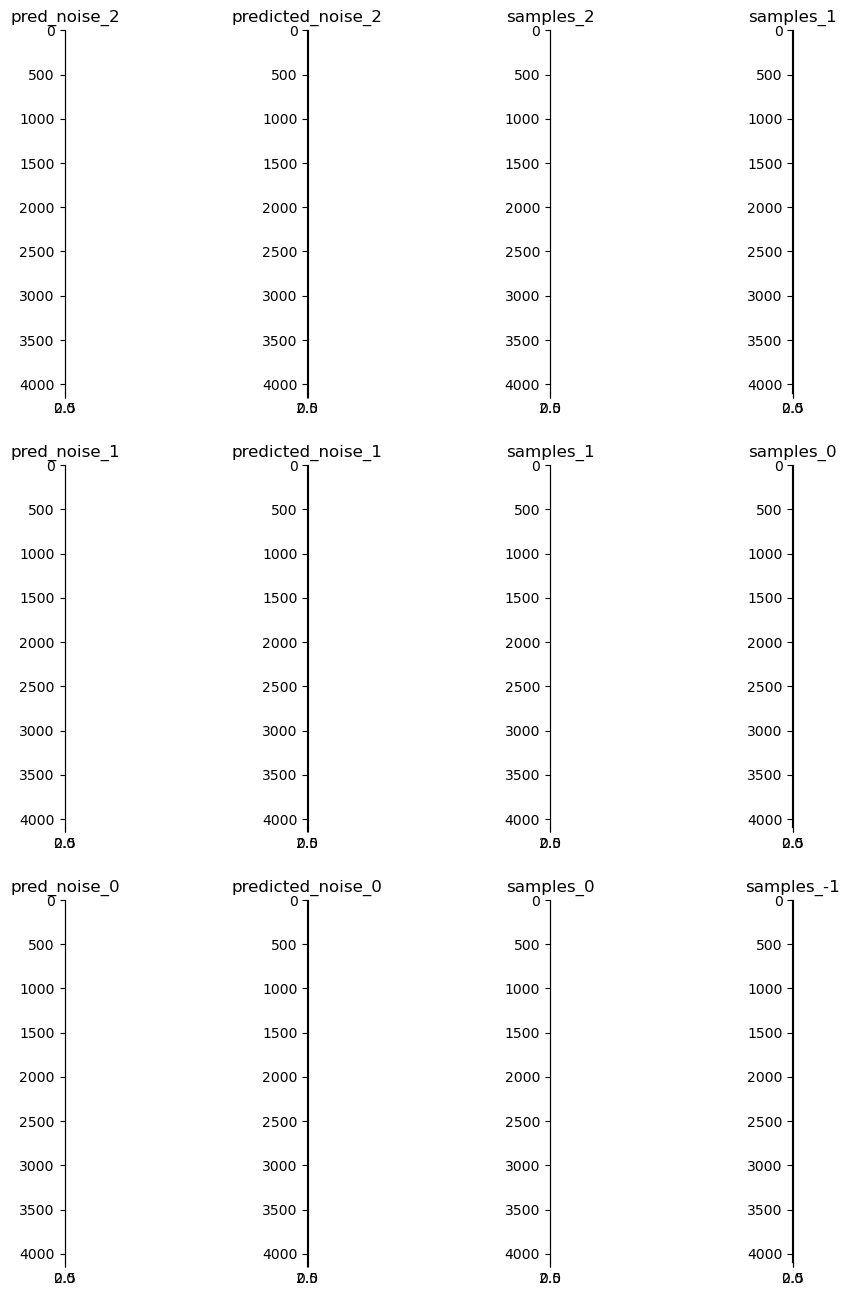

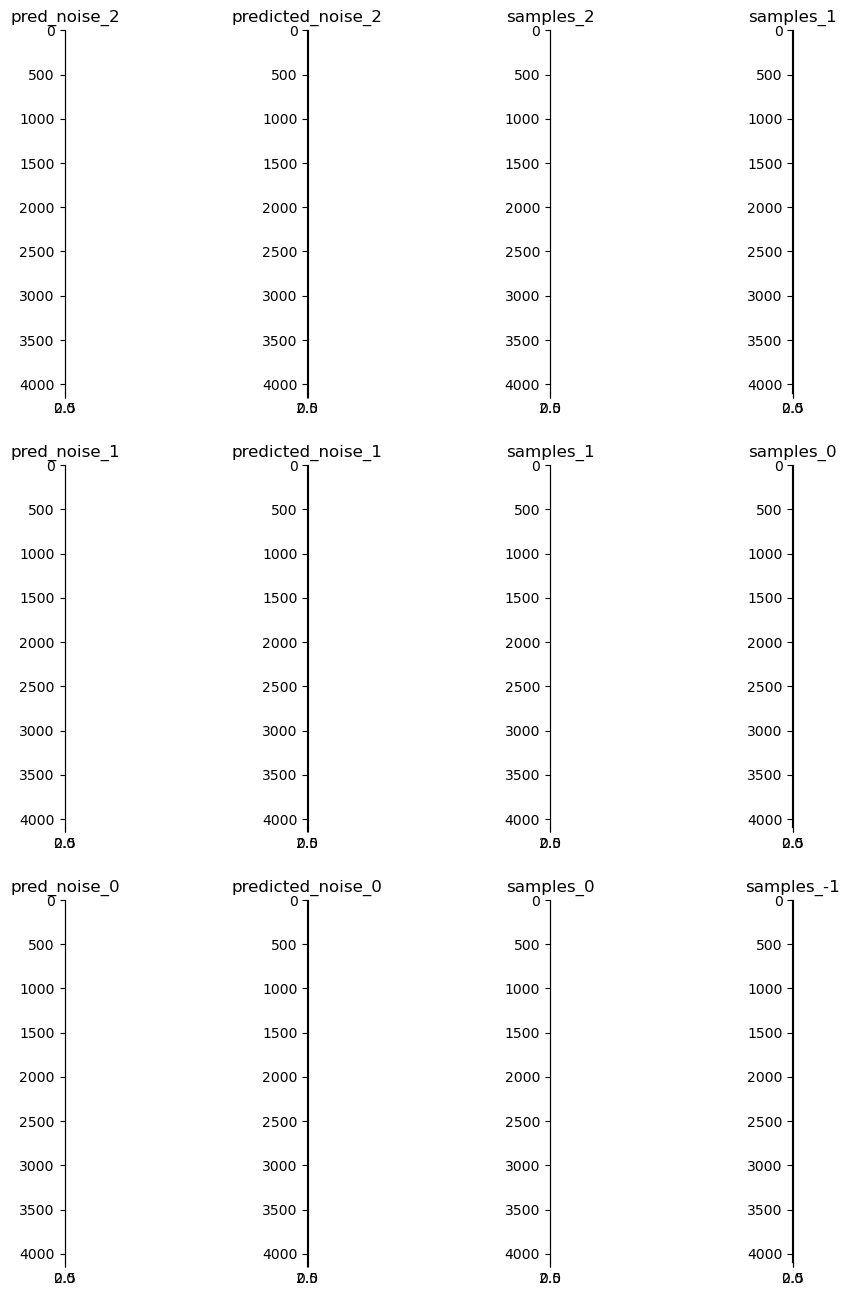

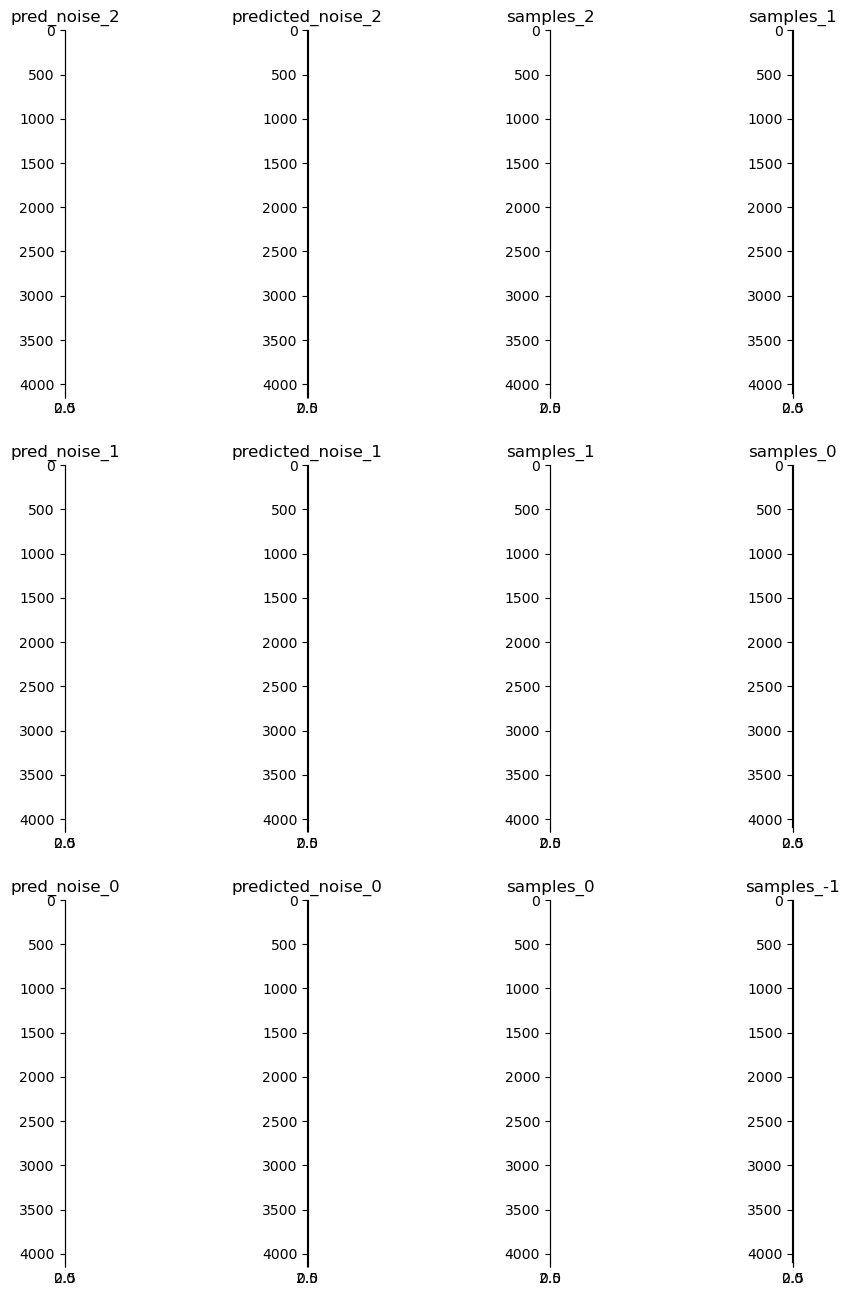

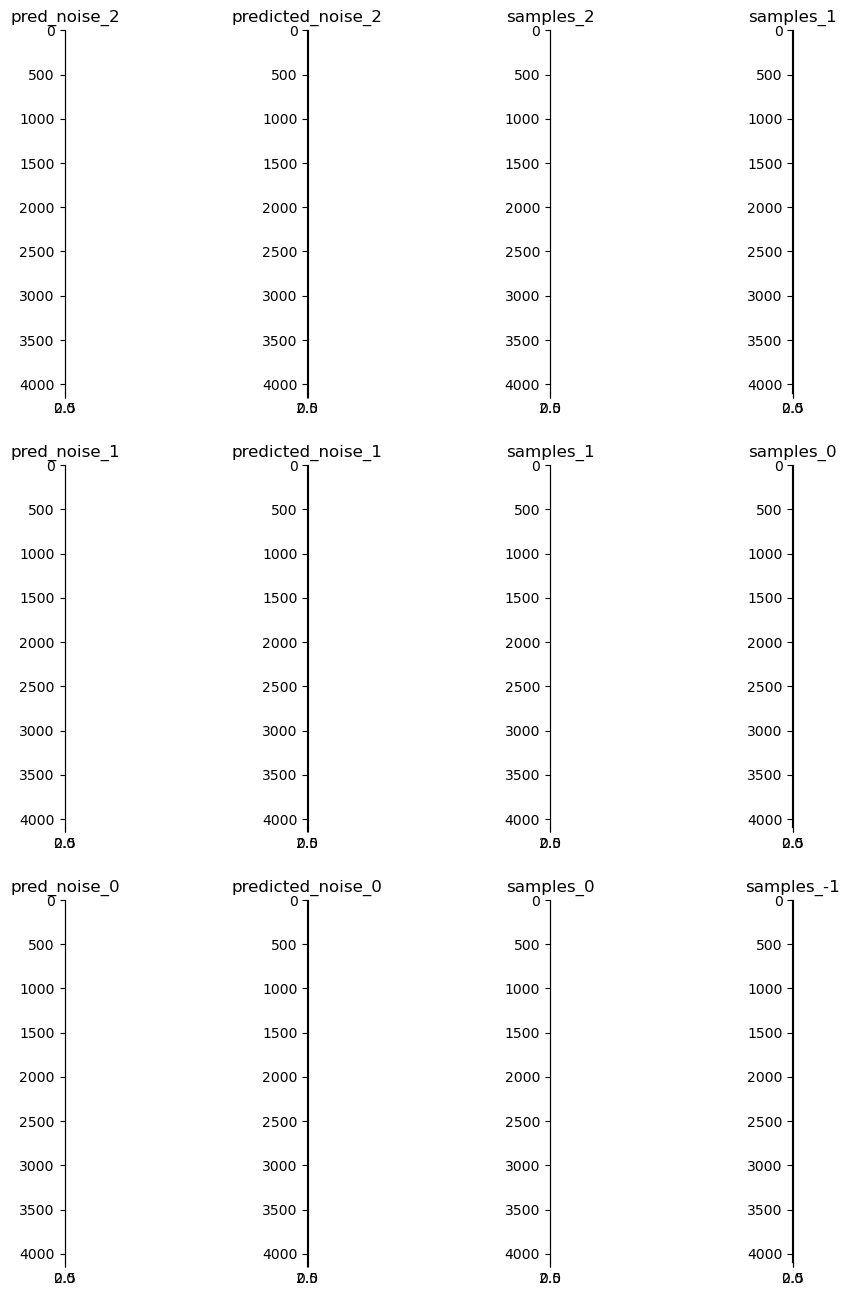

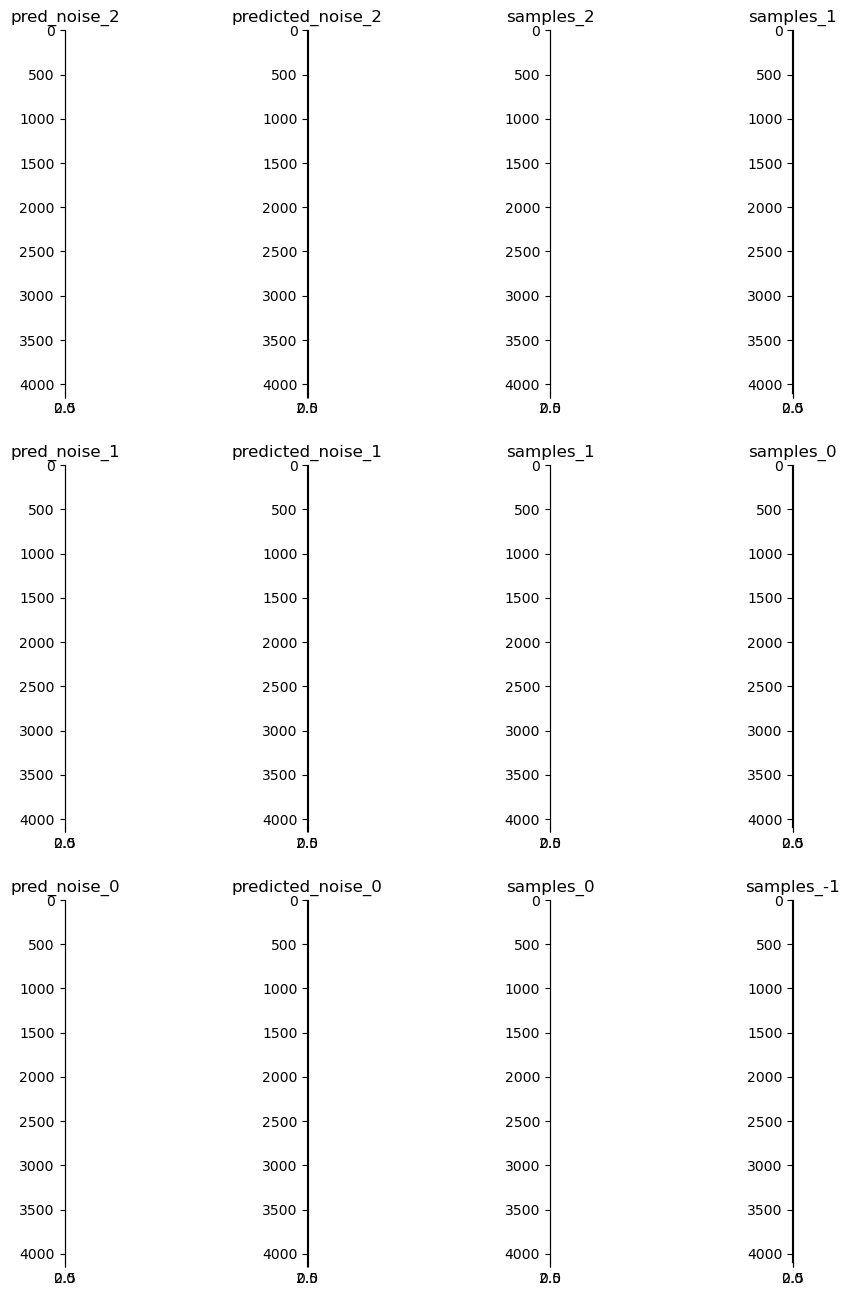

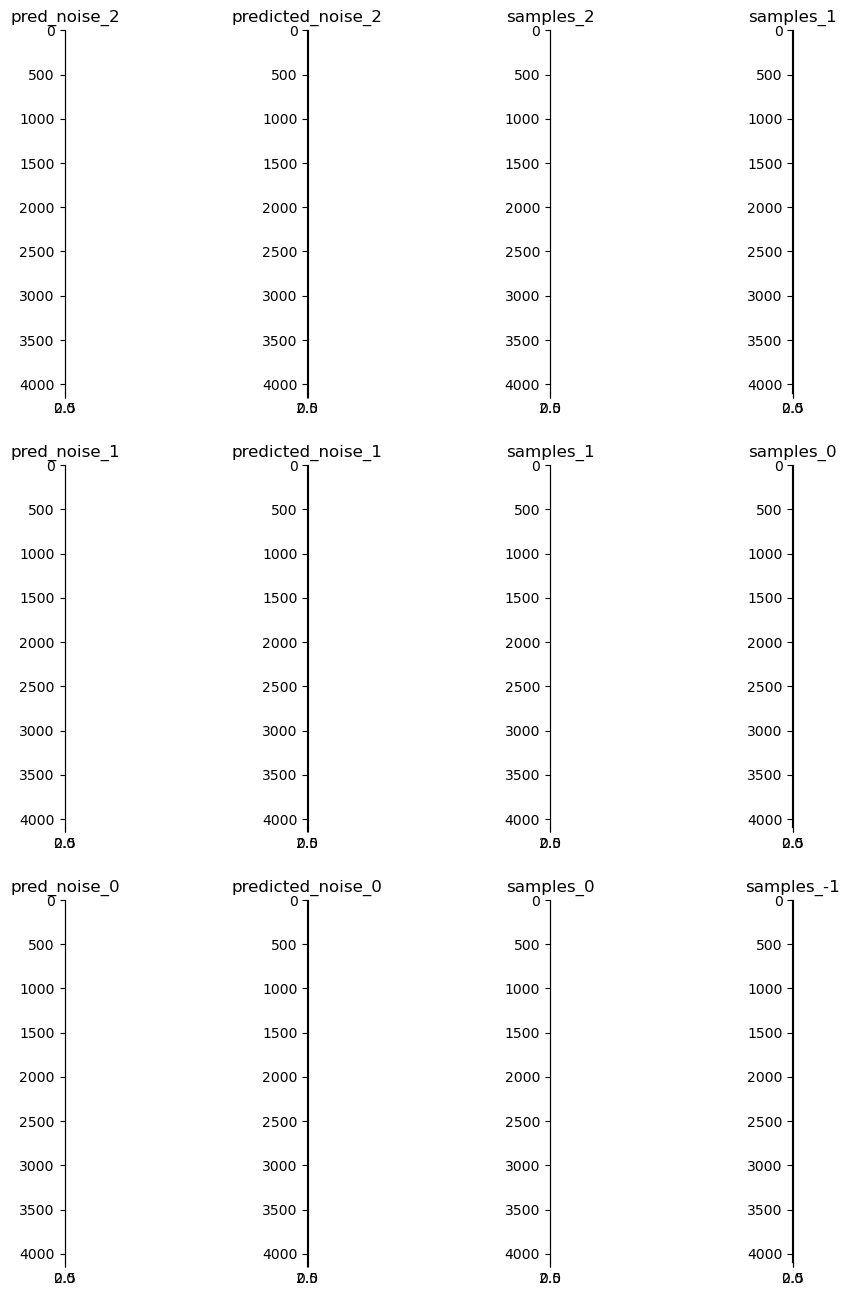

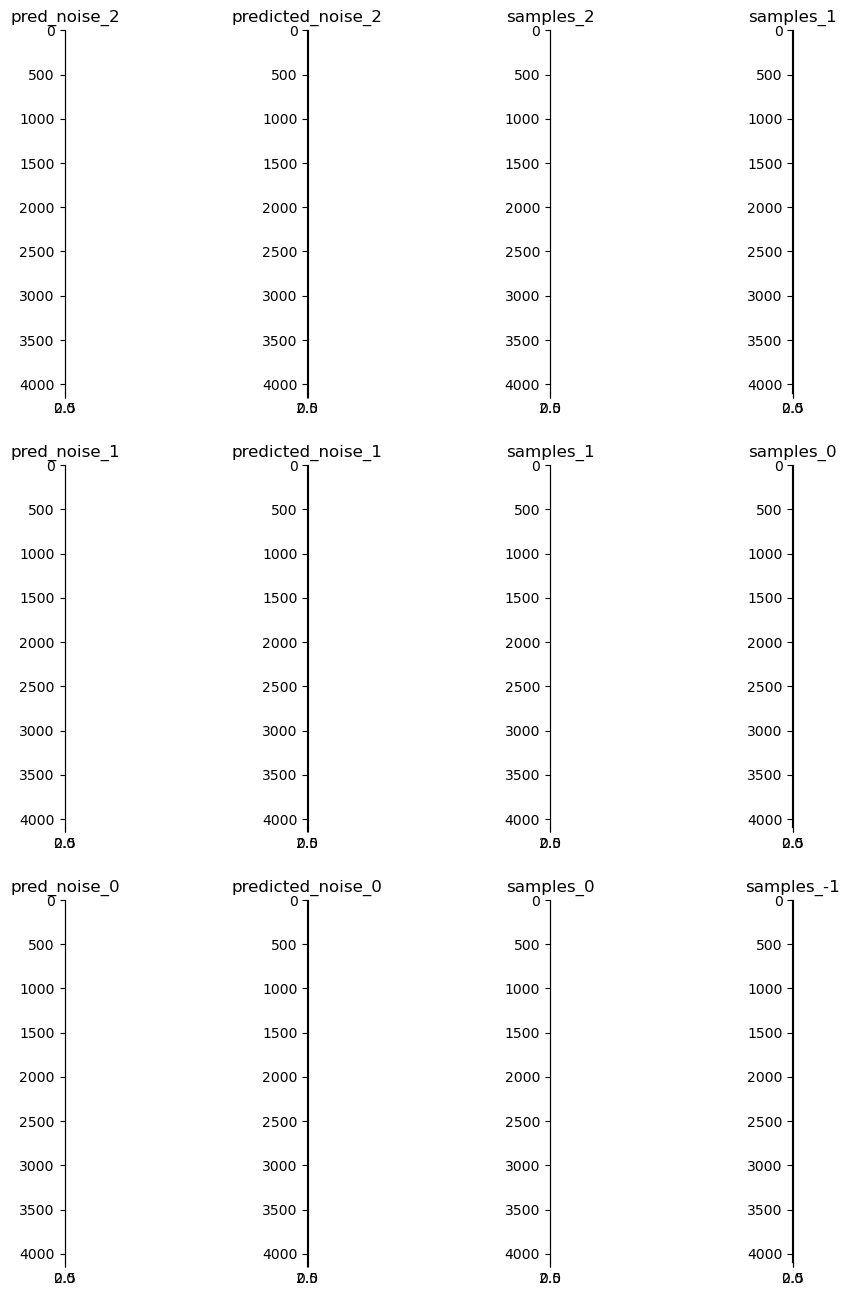

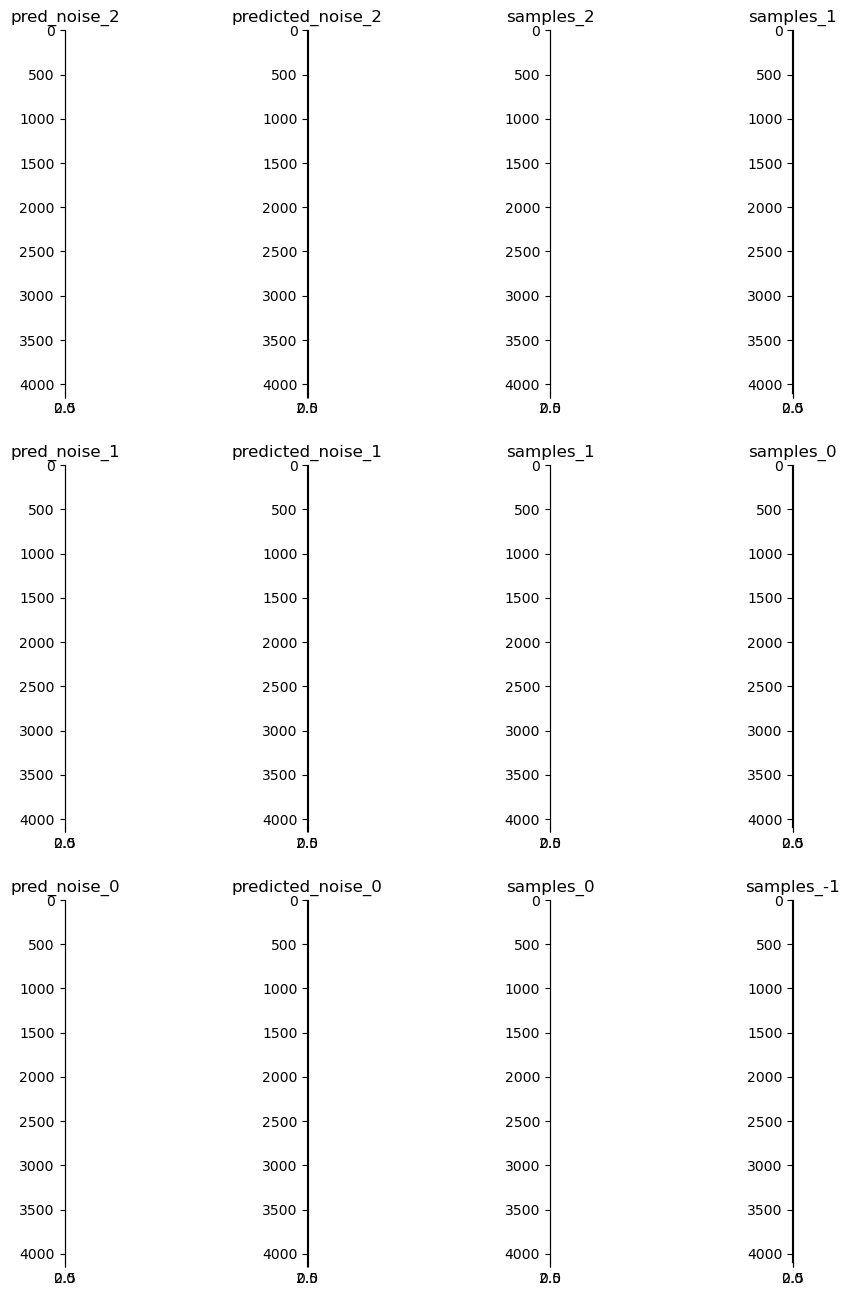

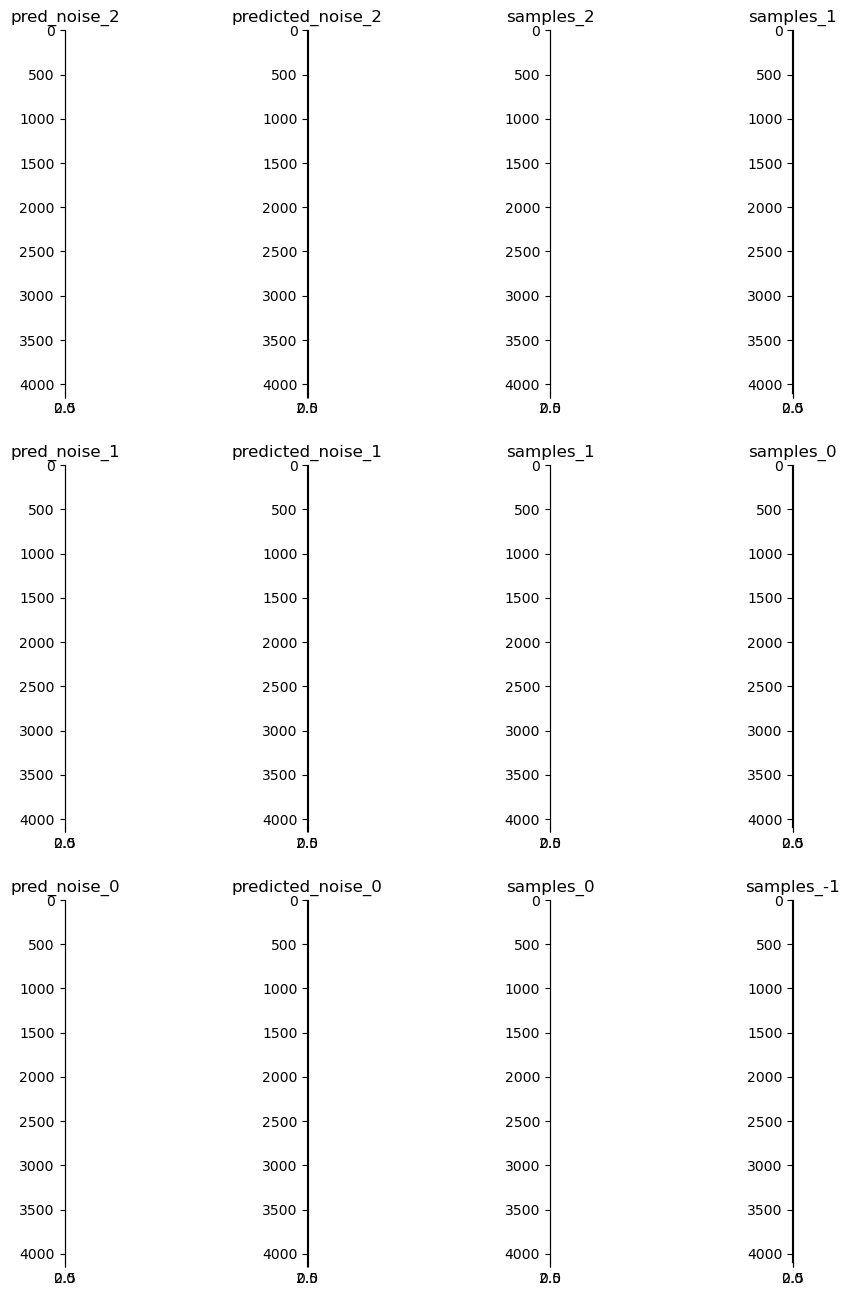

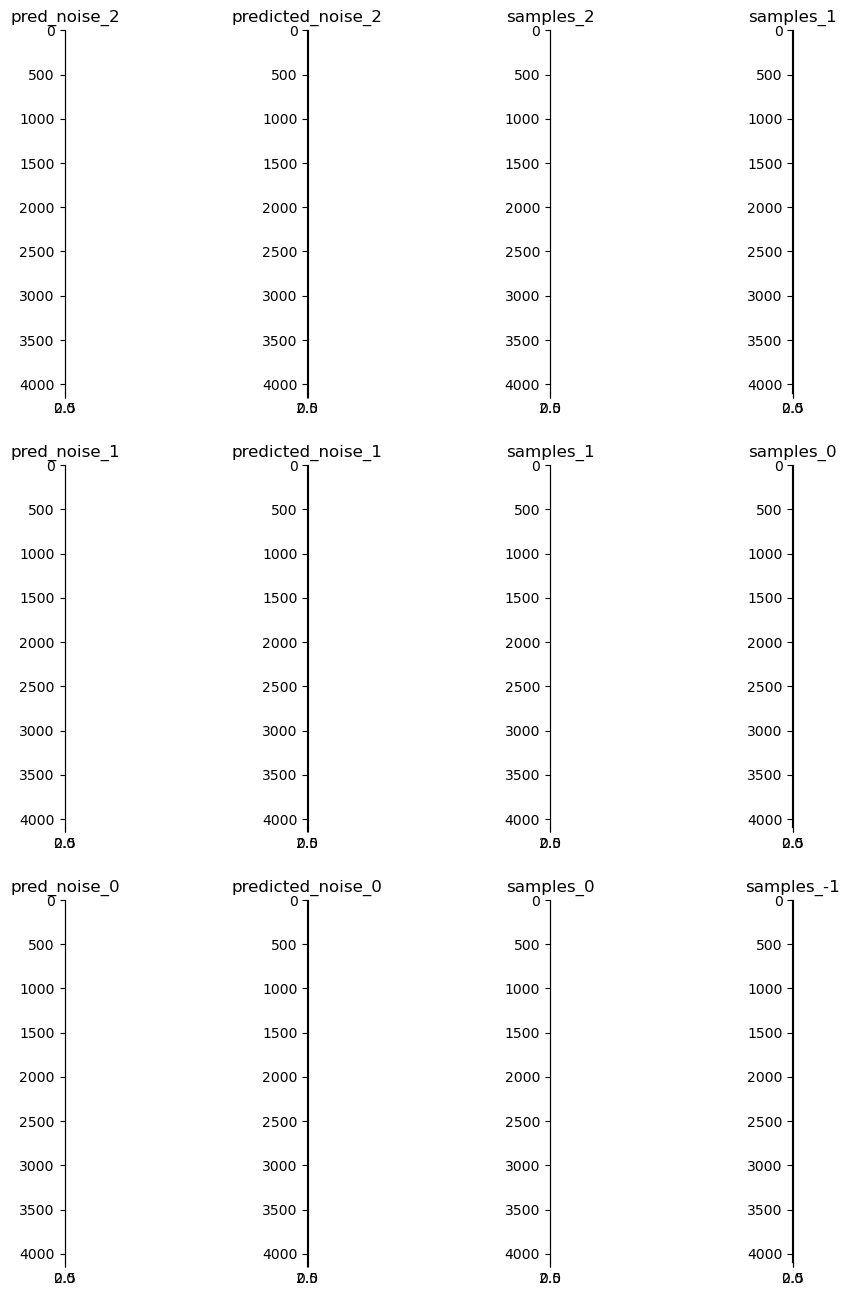

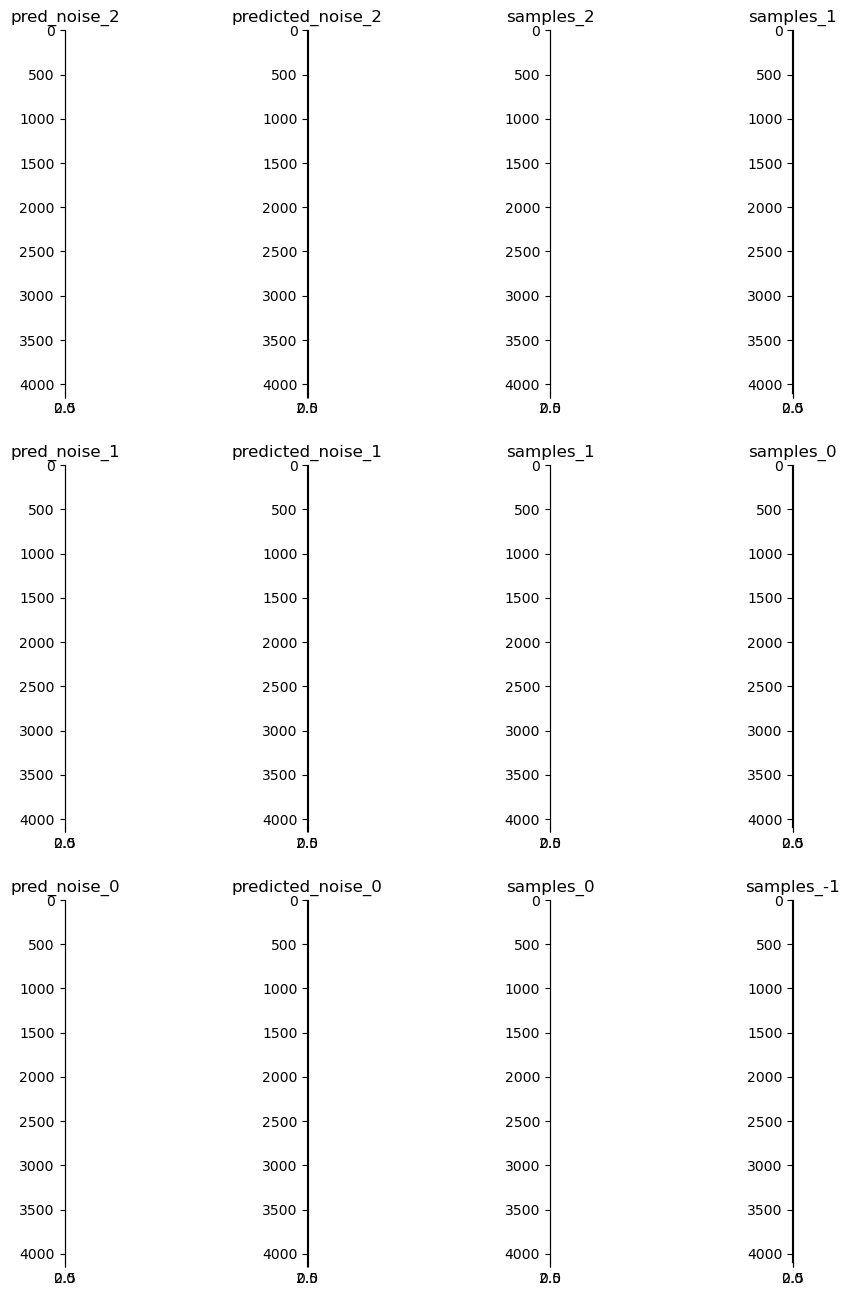

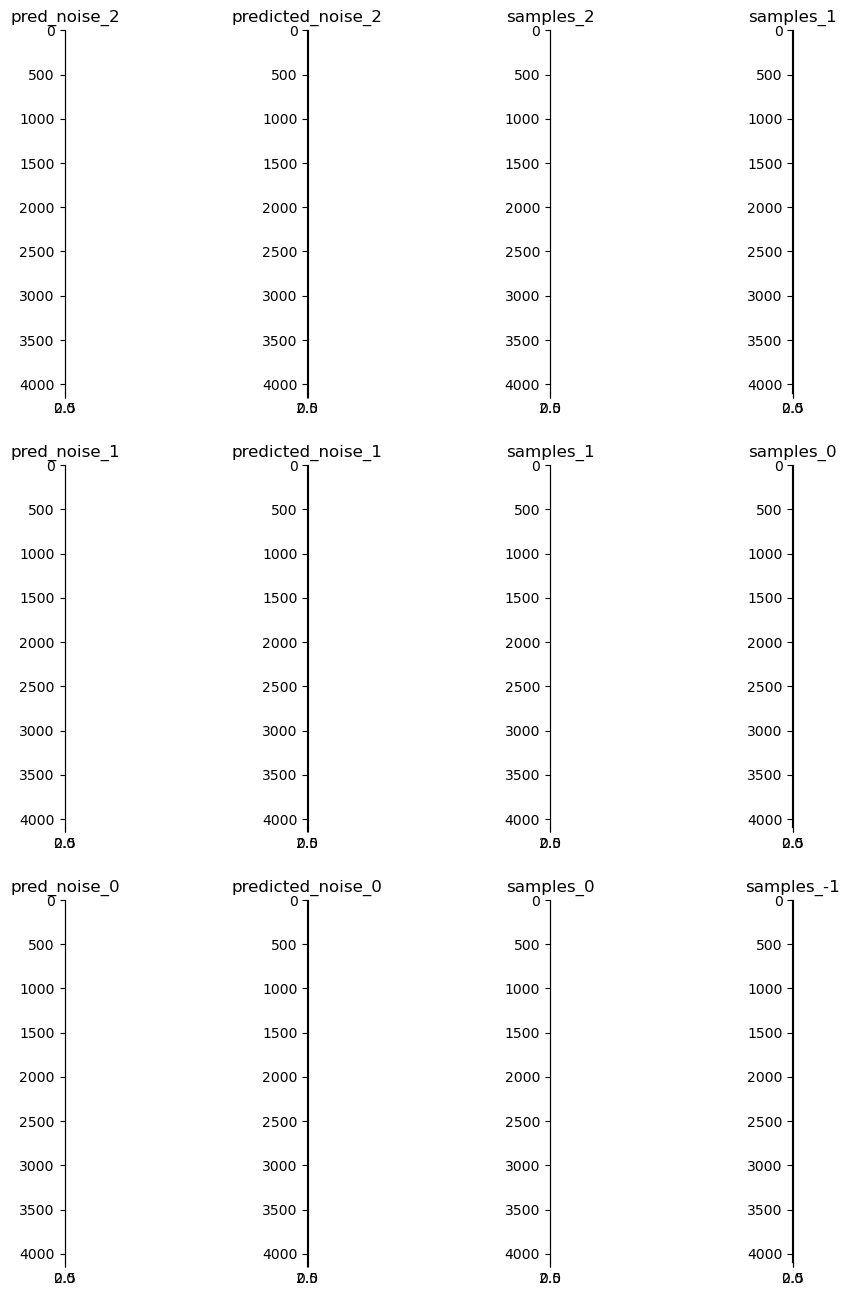

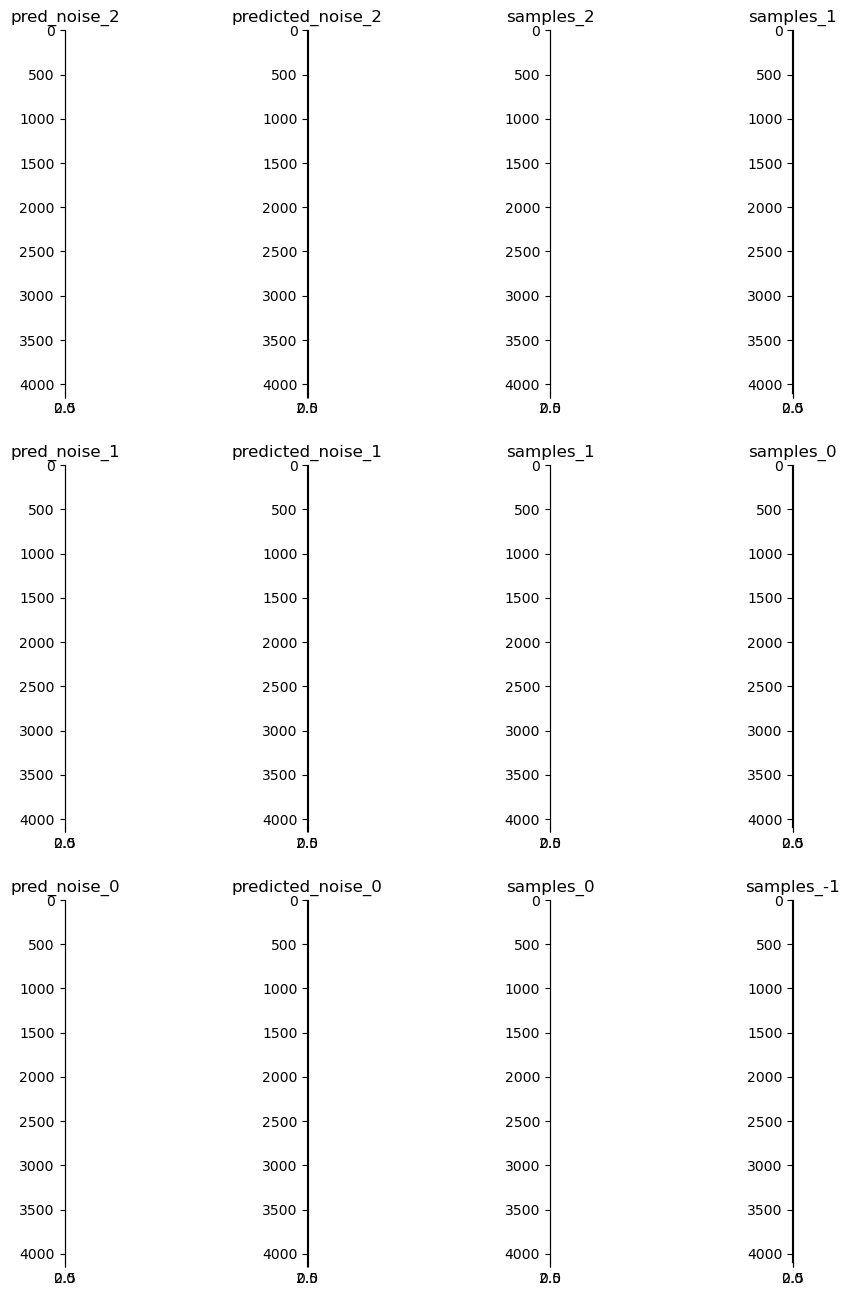

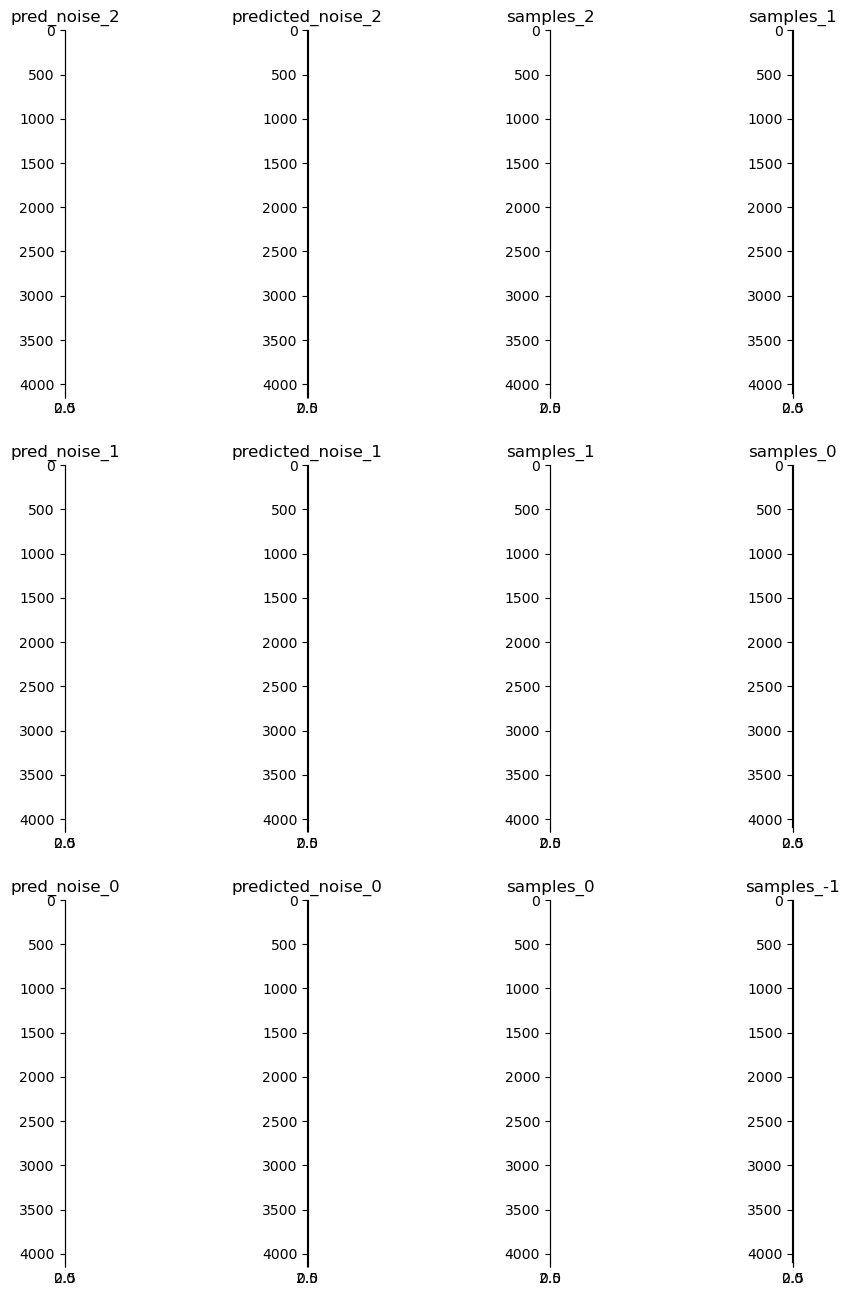

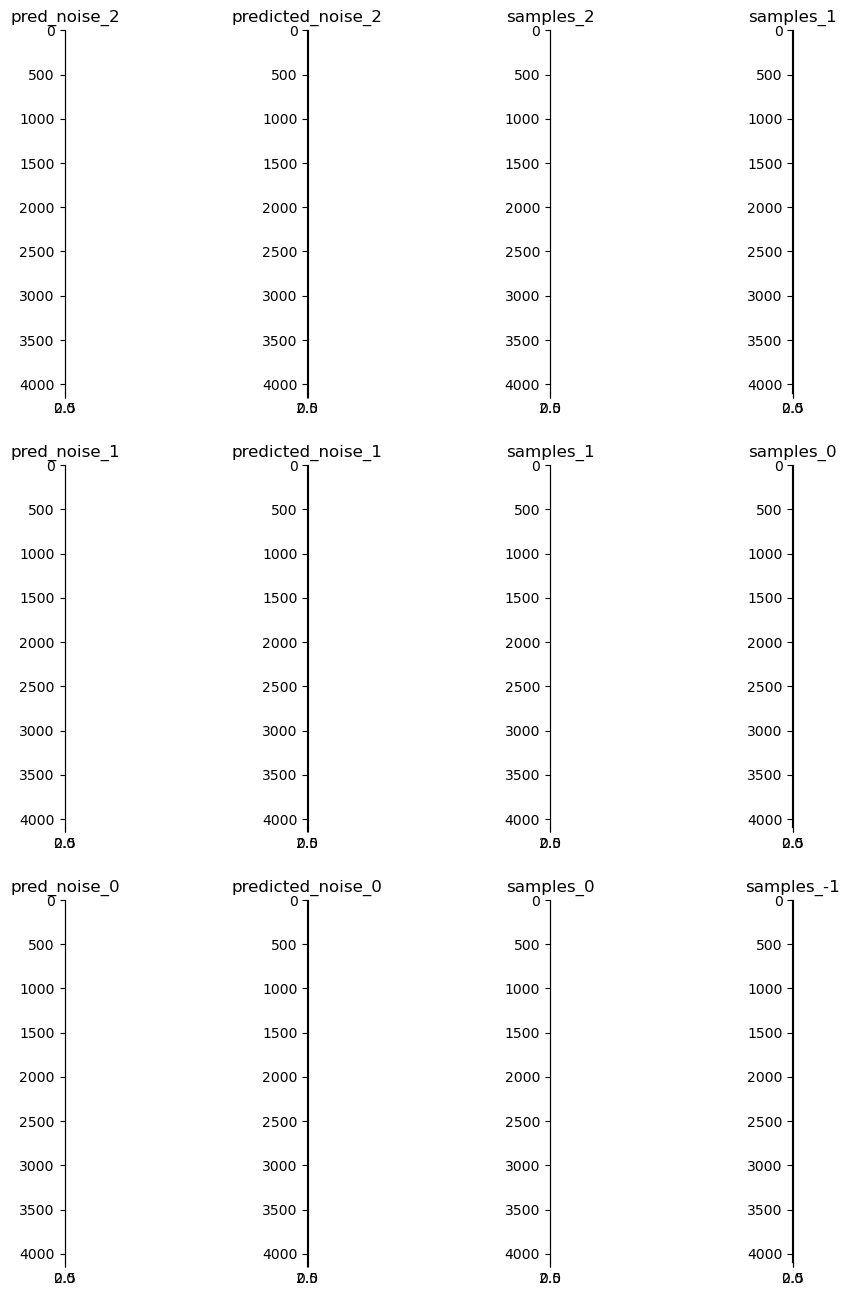

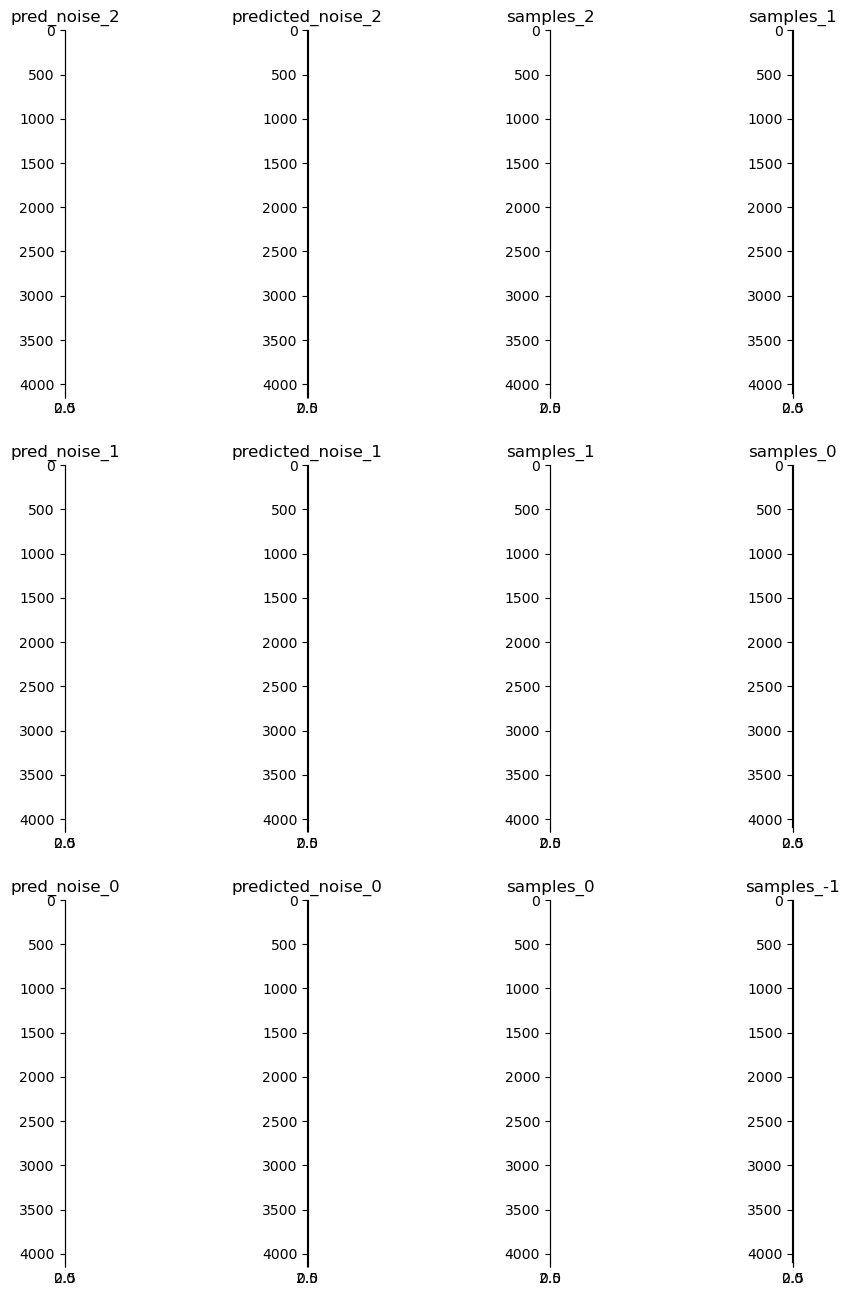

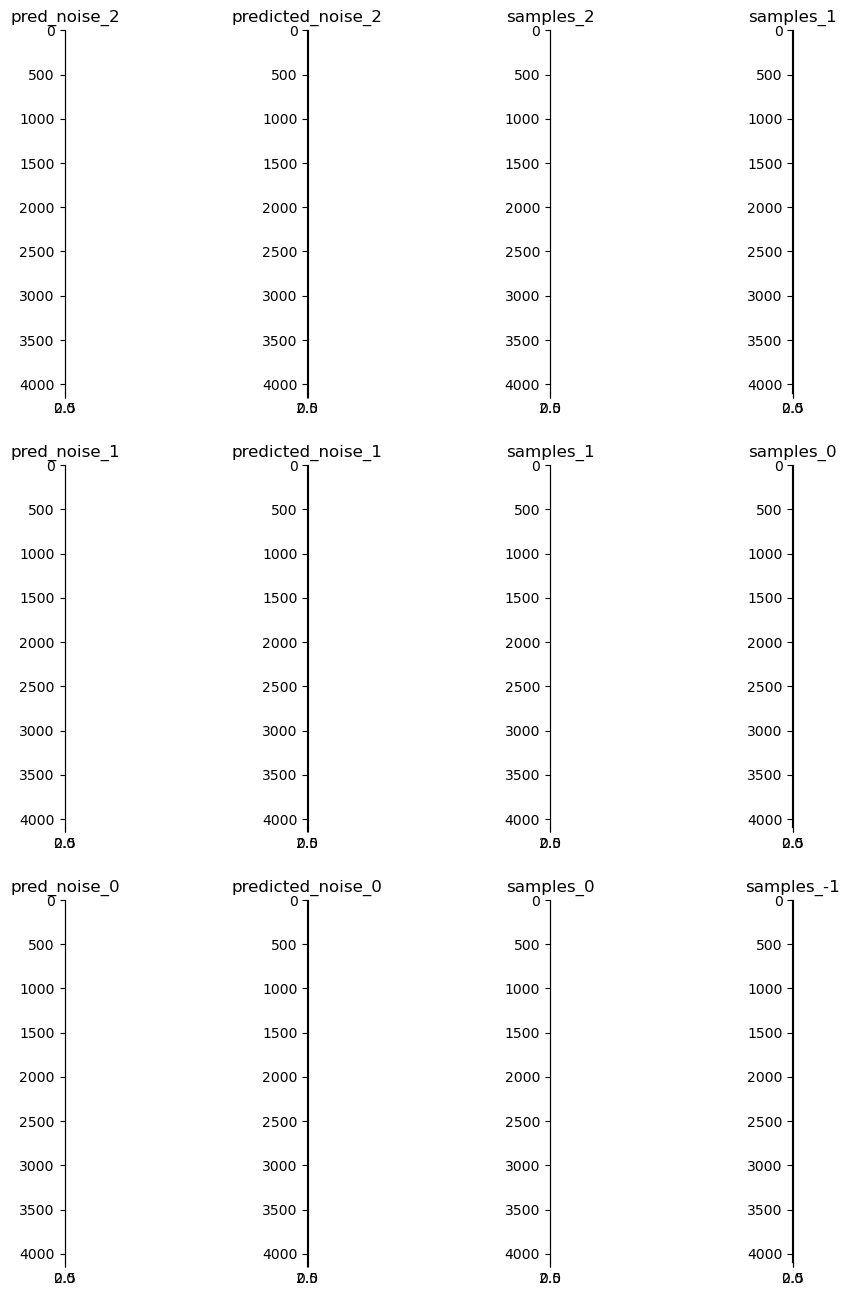

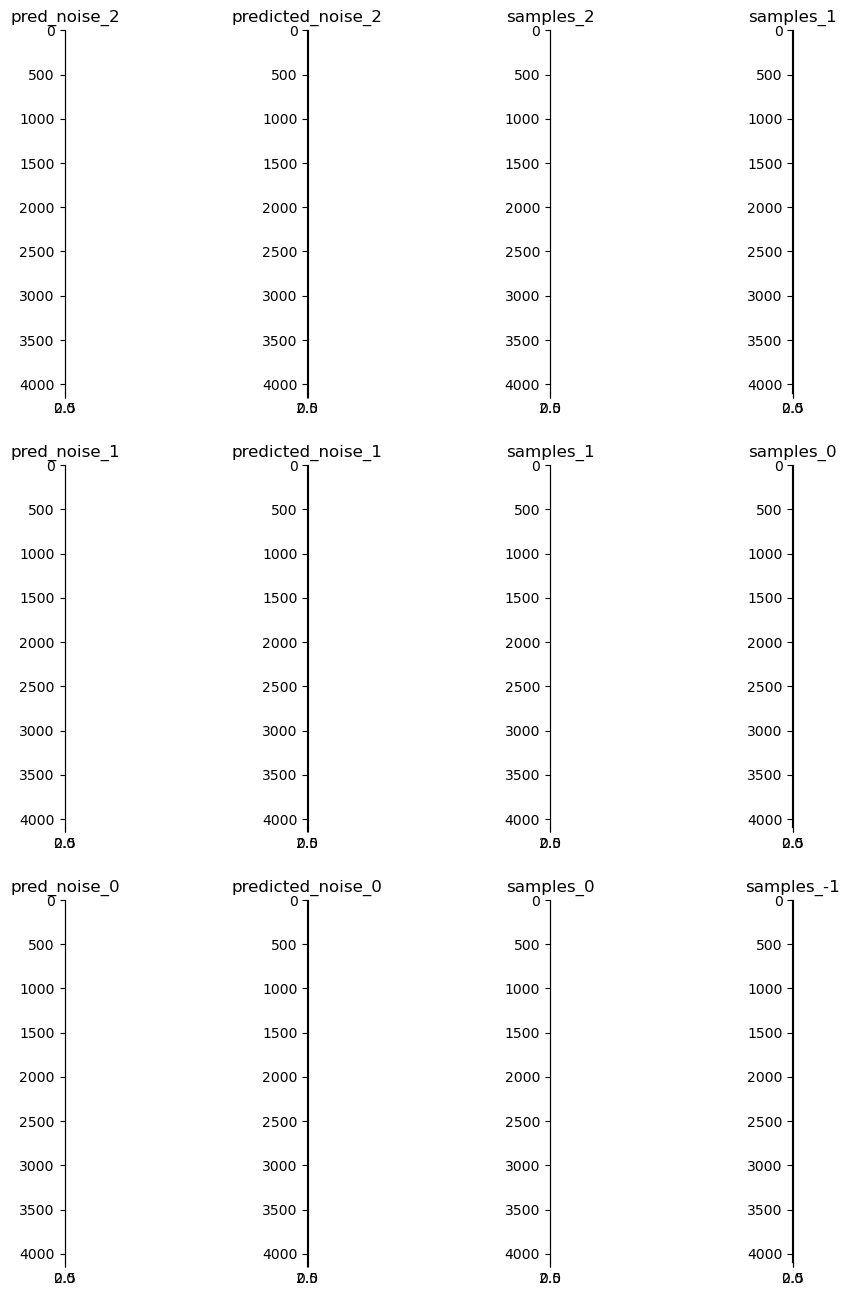

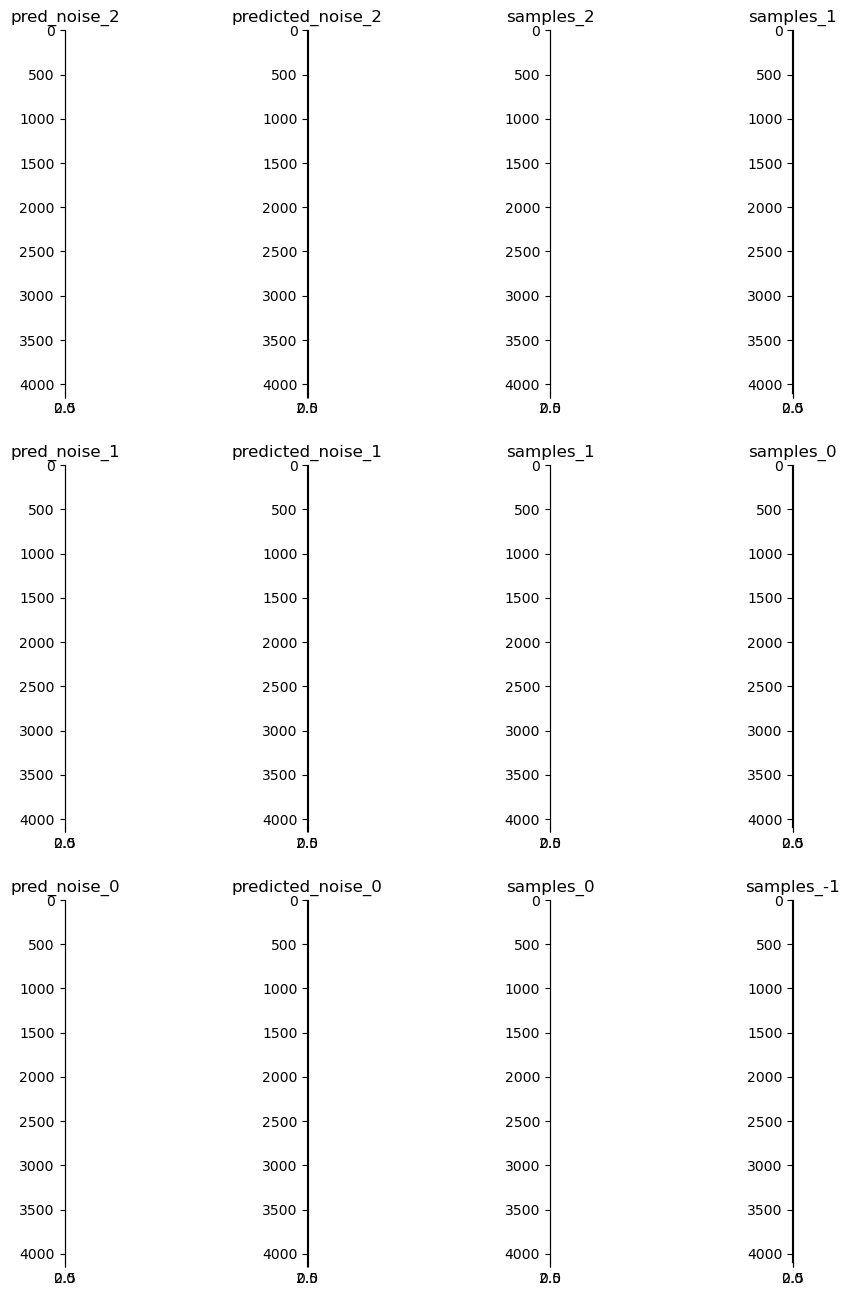

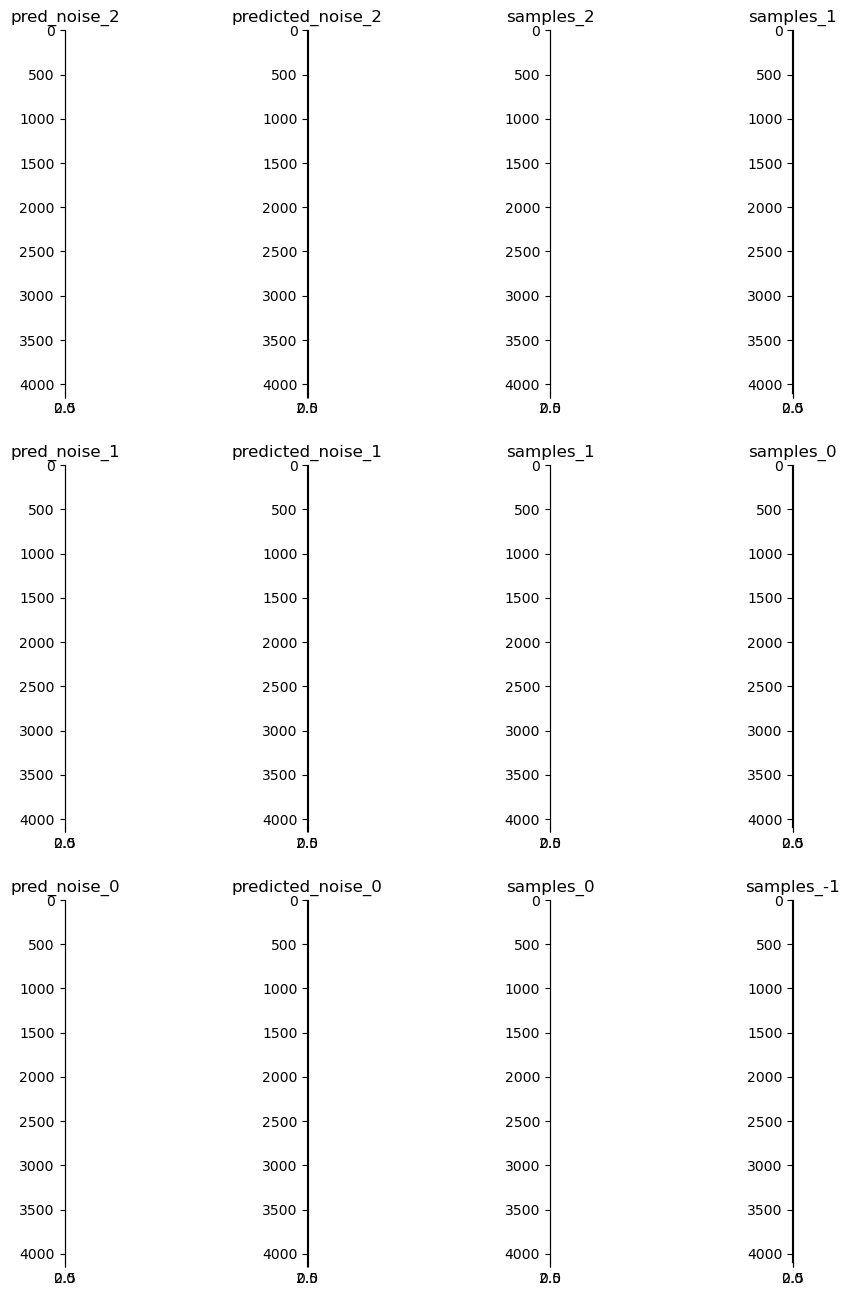

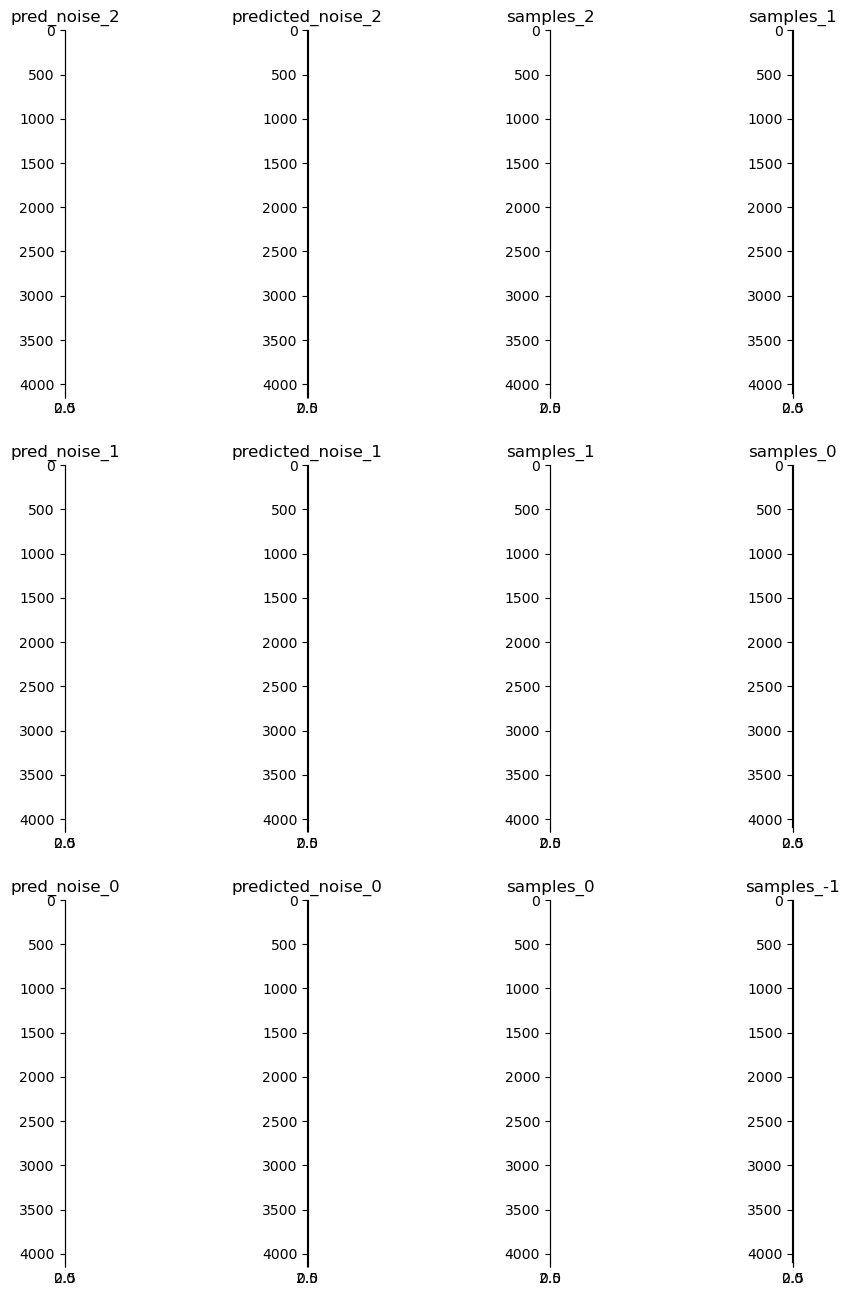

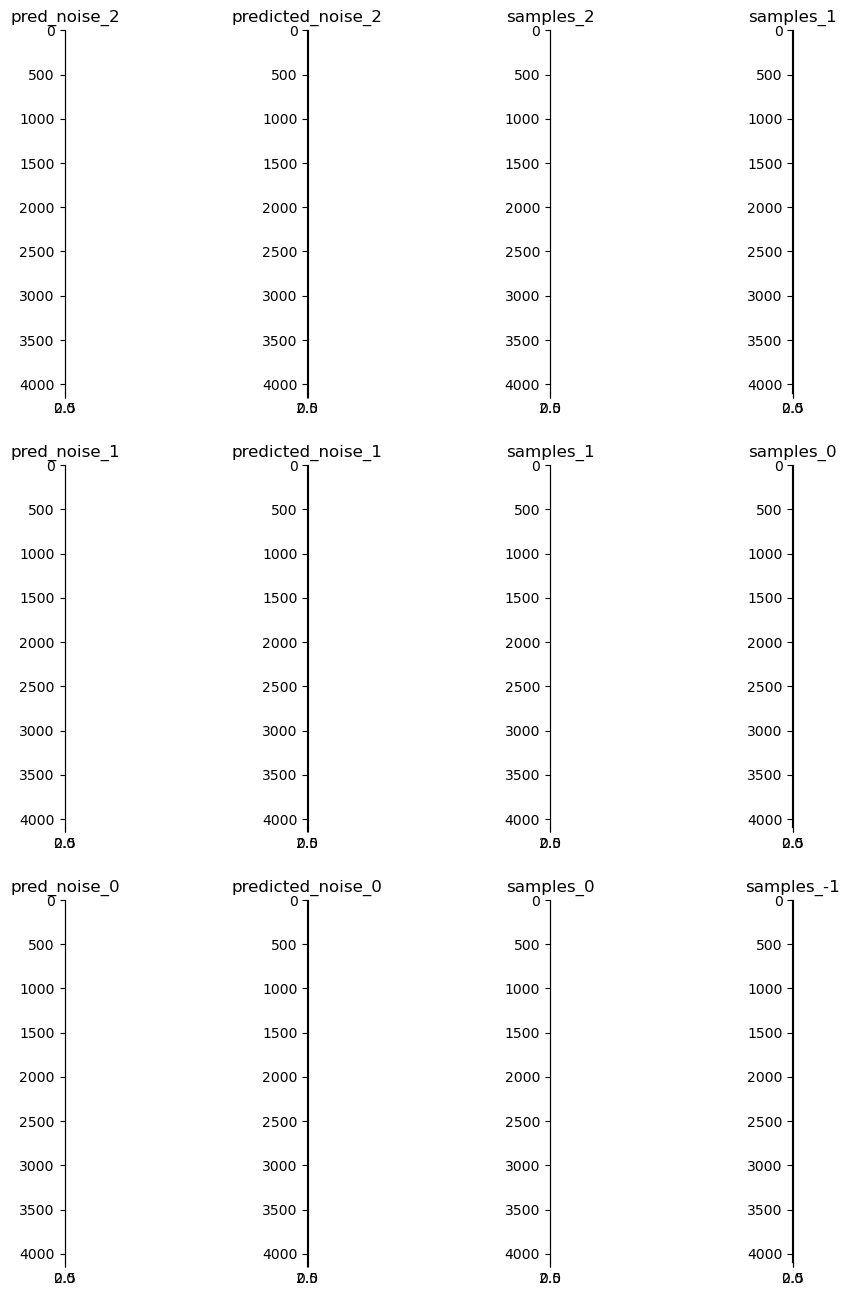

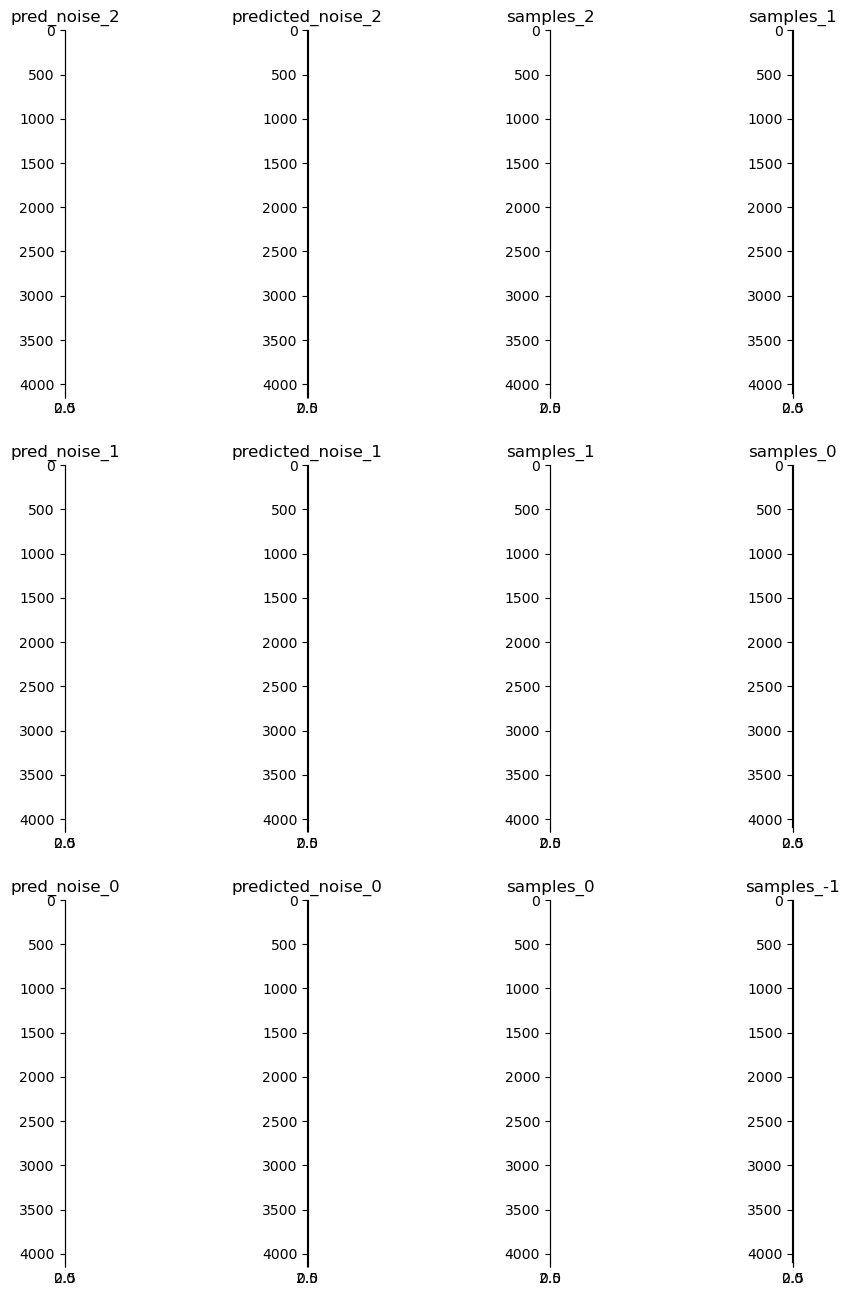

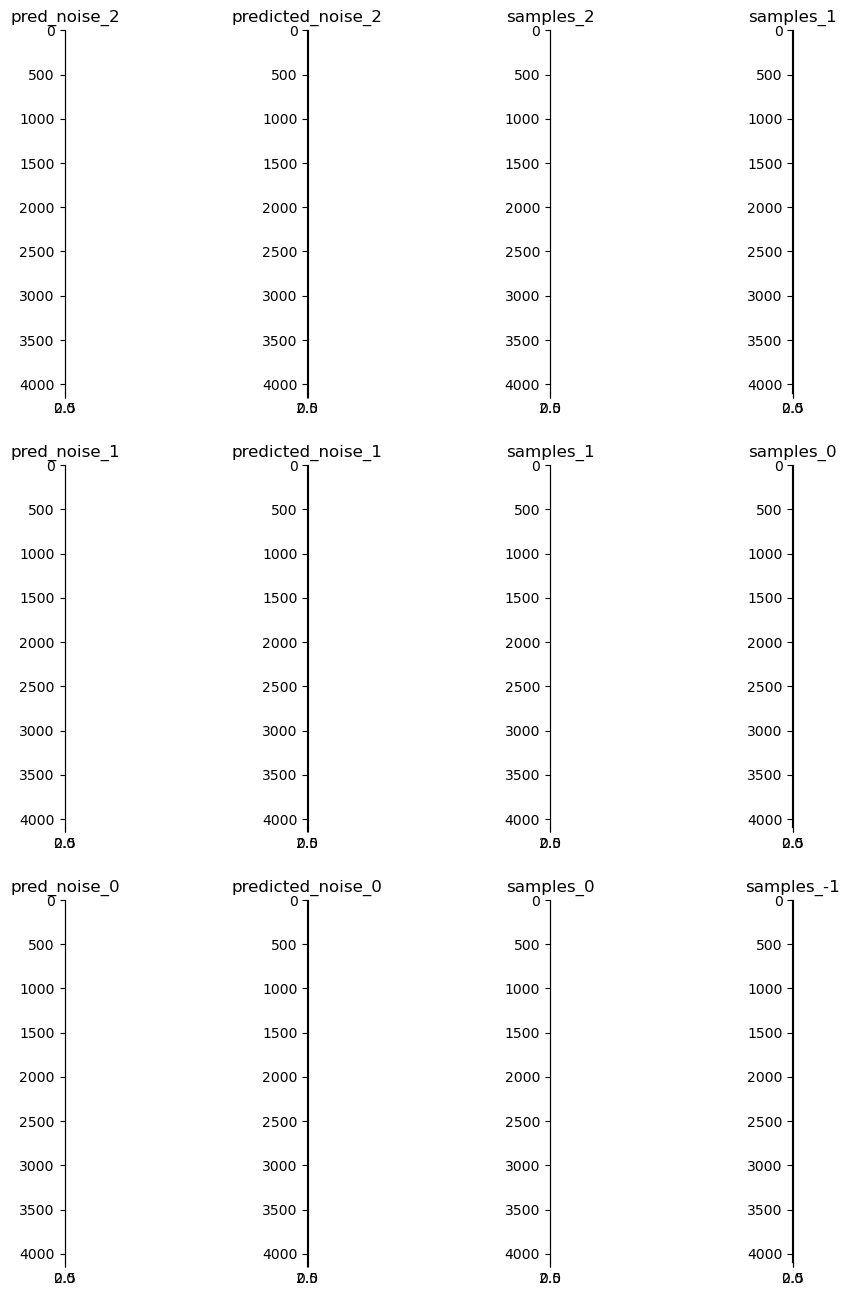

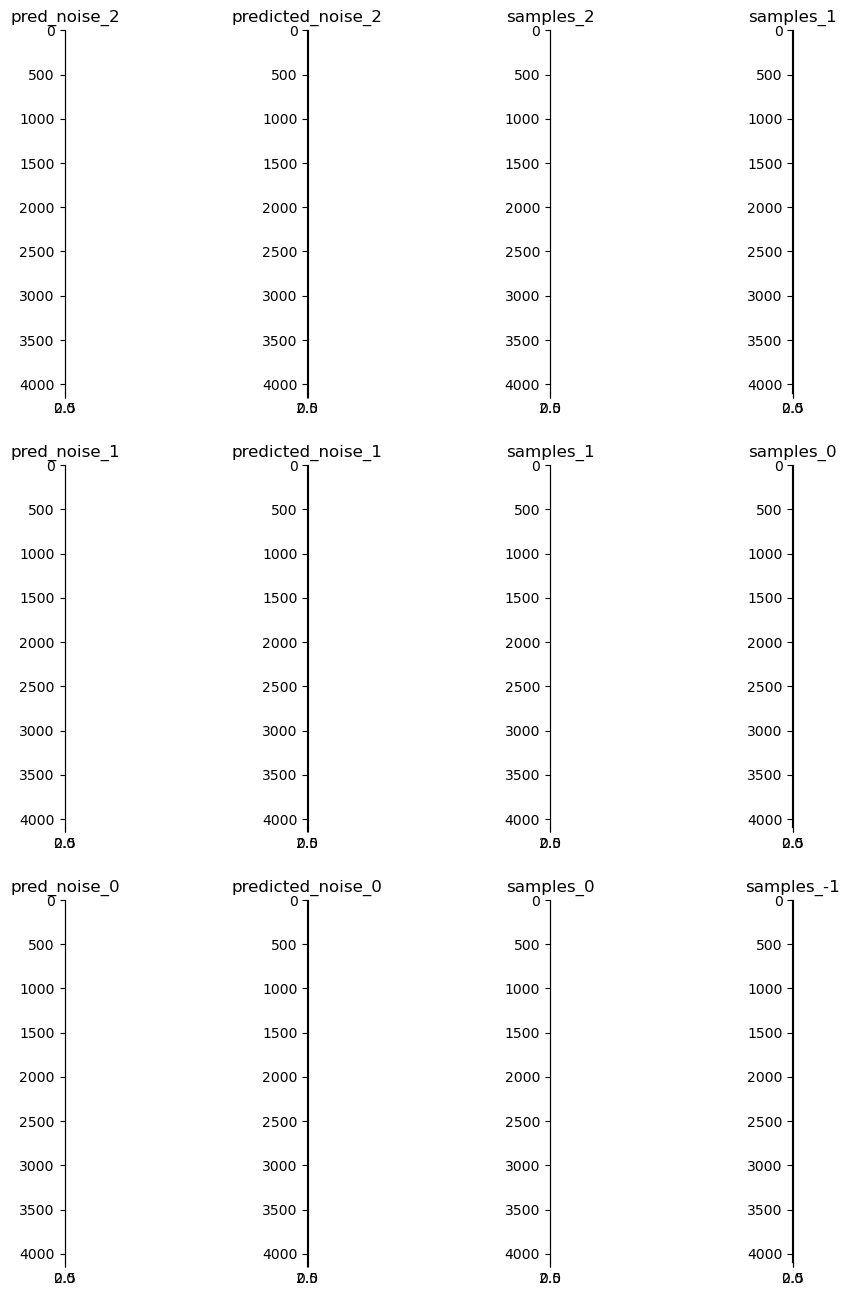

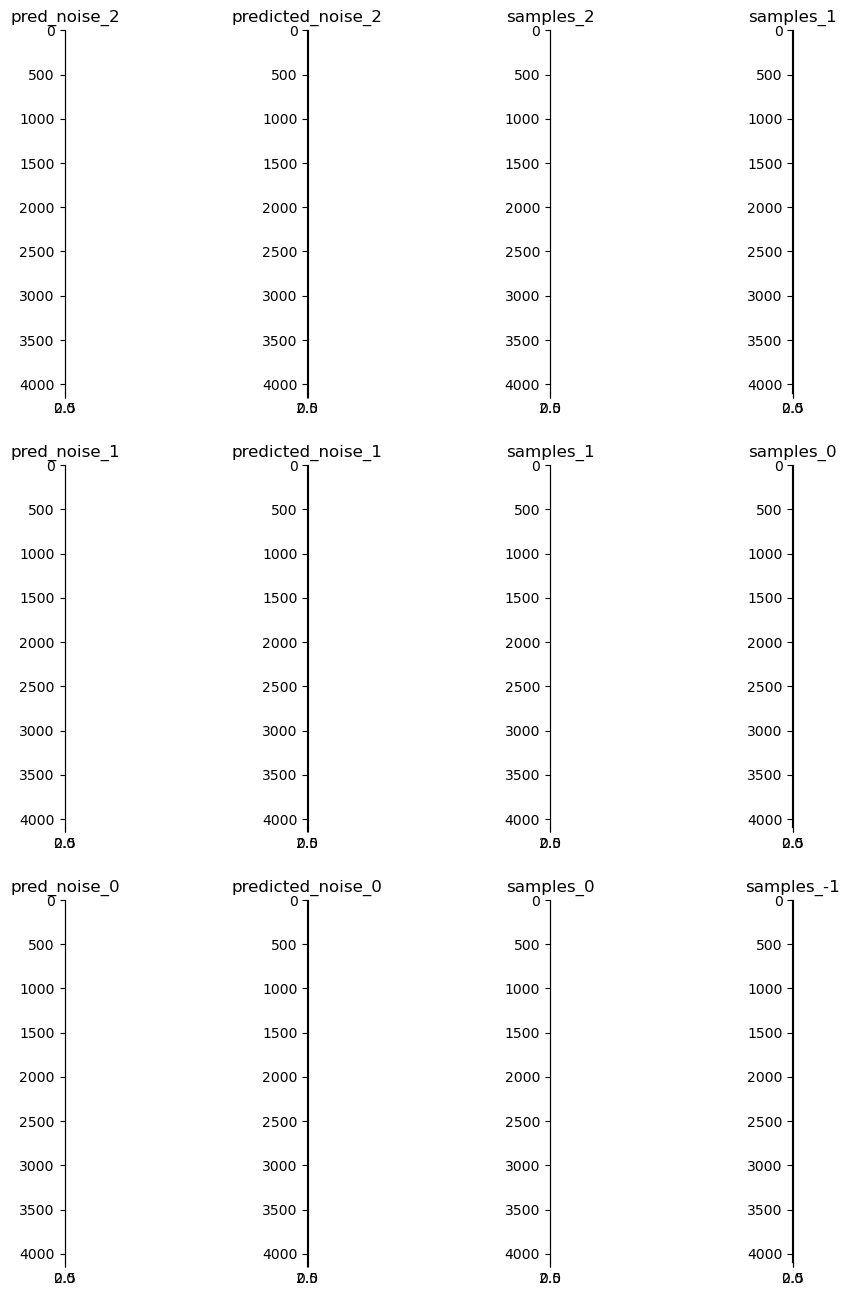

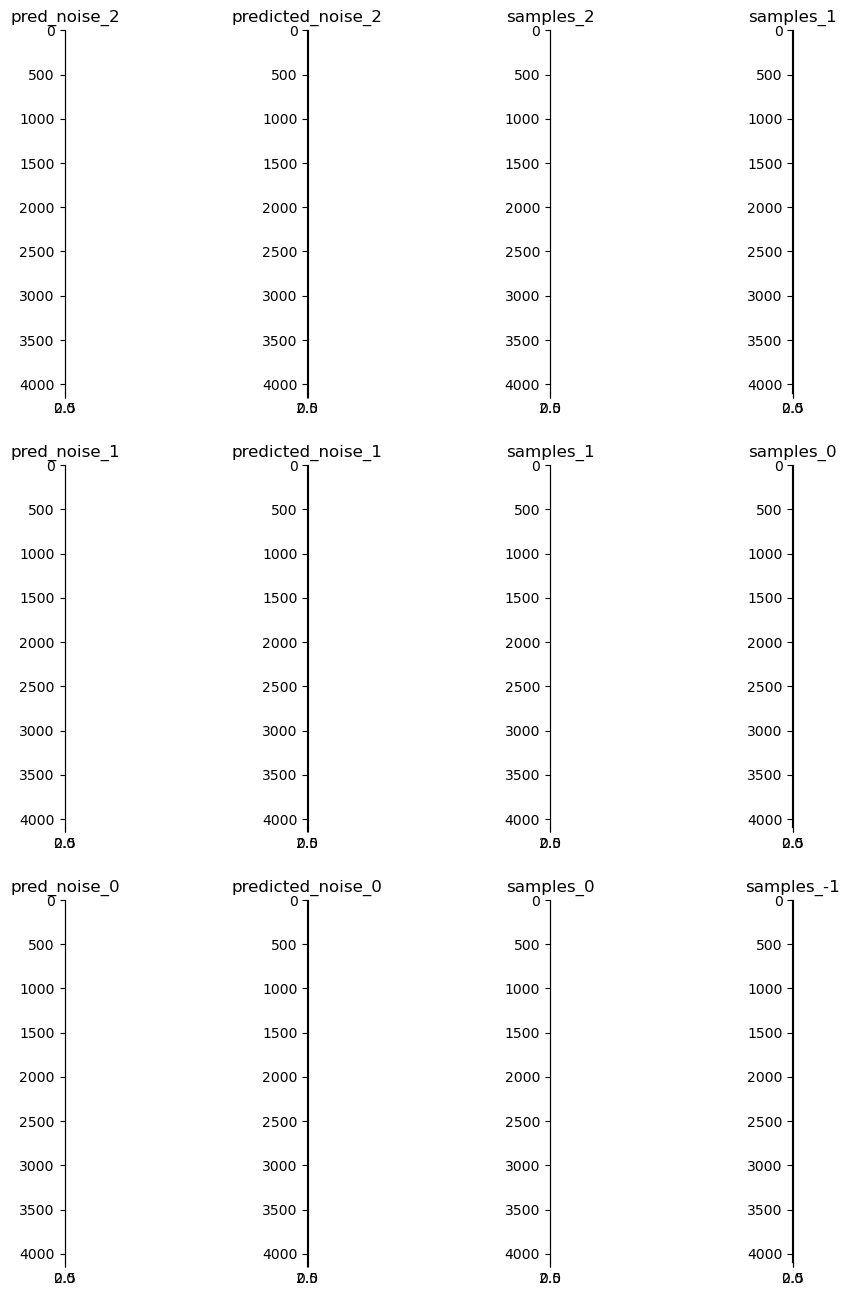

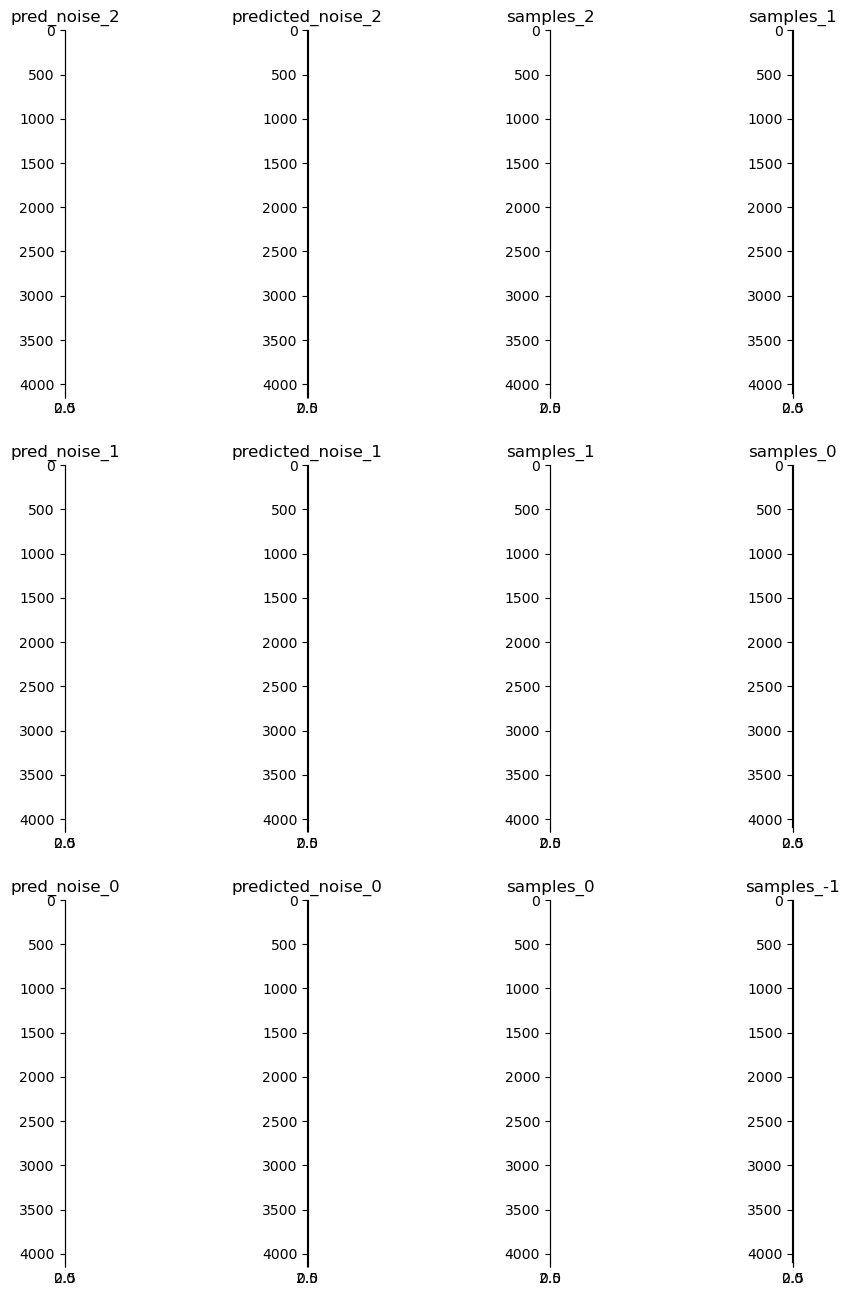

Error in callback <function flush_figures at 0x7b62ee3caa20> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

In [13]:
from tablediffusion.utilities import run_synthesisers
import time

dset_name = 'appraise'
datasets = {dset_name: config.datasets[dset_name]}

exp_hash = datetime.now().strftime("%y%m%d_%H%M%S")
EXP_NAME = f"exp_{exp_hash}"

# Make directories for experiment EXP_NAME
EXP_PATH = RESULTDIR / EXP_NAME
# FAKE_DSET_PATH = EXP_PATH / "fake_datasets"
FAKE_DSET_PATH = Path("/home/azureuser/drive1/syn")
if not os.path.exists(FAKE_DSET_PATH):
    os.makedirs(FAKE_DSET_PATH)

exp_id = mlflow.create_experiment(f"{EXP_NAME}")

print(f"\n\nRunning experiment: {EXP_NAME}\n\n")

start = time.time()

run_synthesisers(
    datasets=datasets,
    synthesisers=synthesisers,
    exp_name=EXP_NAME,
    exp_id=exp_id,
    datadir=DATADIR,
    repodir="./",
    epsilon_values=[2.0],
    repeats=1,
    metaseed=SEED,
    generate_fakes=True,
    fake_sample_path=EXP_PATH / "samples",
    fake_data_path=FAKE_DSET_PATH,
    cuda=True,
)

mlflow.end_run()

end = time.time()

print(f'Time Elapsed: {(end - start) / 60} min')